The associated dataset for this example can be obtained from https://zenodo.org/records/6624956. Download and extract all_flights.tar.gz into this directory. Information about this dataset can be found at https://github.com/hyang0129/NGAFIDDATASET.

In [6]:
import pandas as pd
import dask.dataframe as dd

import numpy as np
import matplotlib.pyplot as plt
import math

from causaljazz.visualiser import Visualiser
from causaljazz.inference import TEDAG
from causaljazz.inference import TEDAG_FUNCTION
from causaljazz.cpu import pmf
from causaljazz.cpu import CausalFunction
import causaljazz.data as data

import tensorflow as tf
from tensorflow.keras import layers

from scipy.stats import norm

Now some helper functions...

In [13]:
def build_pmf(sample, num_intervals = 100):
  vmin = np.min(sample)
  vmax = np.max(sample)

  if vmax-vmin == 0:
      vmin -= 0.005
      vmax += 0.005

  # Build a pmf for each latent variable
  num_points = sample.shape[0]
  mass_per_point = 1.0 / num_points
  interval_width = (vmax-vmin)/num_intervals
  pmf = np.zeros(num_intervals+1)
  for i in sample:
      idx = int((i - vmin) / interval_width)
      pmf[idx] += mass_per_point

  return pmf

# Return the approximate discretised probability mass function for a normal distribution with x_mean and x_sd. The discretisation goes from x_min to x_max with res bins.
def generateGaussianNoisePmf(x_min, x_max, x_mean, x_sd, res):
    x_space = np.linspace(x_min, x_max, res)
    x_dist = [a * ((x_max-x_min)/res) for a in norm.pdf(x_space, x_mean, x_sd)]
    x_pmf = [a / sum(x_dist) for a in x_dist]
    return x_pmf

# get the data we care about for all flights for a given timestep
def getFlightDataAtTimestep(dataset, current_timestep):
  if current_timestep == 0:
      current_timestep = 1

  training_data = []

  current_t = dataset[dataset['timestep'] == current_timestep]
  current_t = current_t[['E1 RPM', 'E1 FFlow', 'AltMSL', 'IAS',  'E1 OilP', 'E1 OilT']]
  previous_t = dataset[dataset['timestep'] == current_timestep-1]
  previous_t = previous_t[['E1 RPM',  'IAS']]

  # Loop through all flights up the max we want to view
  flight_count = 0

  for flight_index in [a for a in current_t.index]:
      if flight_count > max_flights:
          continue
      flight_count += 1

      if flight_index not in [a for a in current_t.index] or flight_index not in [a for a in previous_t.index]:
          continue

      vals_t = current_t.loc[flight_index].to_numpy().tolist()
      vals_prev_t = previous_t.loc[flight_index].to_numpy().tolist()

      # For the two variables we want, if either are NaN, just ignore this data point.
      if (np.any([math.isnan(x) for x in vals_t]) or np.any([math.isnan(x) for x in vals_prev_t])):
          continue

      #                                  'E1 RPM', 'E1 FFlow',  'AltMSL',   'IAS'   'OilP'    'OilT'
      training_data = training_data + [[vals_t[0], vals_t[1], vals_t[2], vals_t[3], vals_t[4], vals_t[5]]]

  return training_data

def normaliseAndFormatData(data, min_vals, max_vals):
  data = np.array(data)
  data = ((np.array(data)-min_vals) / (max_vals-min_vals))
  data_items = []
  for d in range(data.shape[1]):
      data_items = data_items + [np.reshape(data[:,d], [data[:,d].shape[0],1])]
  return data_items

# If we want to generate a pmf from a sample of points, we can use this function to get the desired cell widths
def calculateCellGridMetrics(data, res):
    in_mins = np.min(data, axis=1)
    in_maxs = np.max(data, axis=1)
    in_ranges = in_maxs - in_mins
    in_ranges = np.array([r if r > 0 else 0.00001 for r in in_ranges]) # make sure no range is zero and give it a small epsilon range if so
    return in_mins, in_maxs, in_ranges, np.divide(in_ranges,res)

def plotDistribution(var_names, data_comparison, timestep, transpose=False):
  space = [0.0, 1.0, 0.0, 1.0]

  fig = plt.figure(1, dpi=200)

  tedag_pmf = tedag.getPmfForIteration(var_names, timestep)
  if tedag_pmf is not None:
      node_indices = [[n.key for n in tedag_pmf.nodes].index(a+str(timestep)) for a in var_names]
      coords, centroids, vals = tedag_pmf.pmf.calcMarginal(node_indices)

      vals = np.array(vals)
      coords = np.array(coords)
      grid = np.zeros((output_res,output_res))
      for c in range(len(vals)):
          ws = [tedag_pmf.pmf.cell_widths[node_indices[0]],tedag_pmf.pmf.cell_widths[node_indices[1]]]
          os = [tedag_pmf.pmf.origin[node_indices[0]], tedag_pmf.pmf.origin[node_indices[1]]]
          cs = [coords[c][0]+(int((os[0]-space[0])/ws[0])), coords[c][1]+(int((os[1]-space[2])/ws[1]))]
          cs = [c if c < output_res else output_res-1 for c in cs]
          cs = [c if c >= 0 else 0 for c in cs]
          grid[int(cs[0]),int(cs[1])] = vals[c]
      if not transpose:
        grid = np.transpose(grid)

      plt.xlim([space[0],space[1]])
      plt.xlabel(var_names[0])
      plt.ylabel(var_names[1])
      plt.ylim([space[2],space[3]])
      plt.imshow(grid, cmap='hot', origin='lower', extent=(space[0],space[1],space[2],space[3]), aspect='auto')

      plt.scatter(data_comparison[0],data_comparison[1],s=1.0,color='#FF00FF')
      filename = var_names[0] + '_' + var_names[1]
      if transpose:
        filename += '_t'
      filename += '_' + str(timestep) + '.png'
      plt.savefig(filename)

  plt.show(block=False)
  plt.close()

Now load the data. This takes some time but luckily only needs to be called once then later processing can be repeated - the magic of iPython!

In [8]:
observed_variables = ['E1 RPM', 'E1 FFlow', 'AltMSL', 'IAS',  'E1 OilP', 'E1 OilT'] # In the future, add all four EGTs?

# Define a maximum number of timesteps and flights to load
max_flights = 100
start_timesteps =  100
end_timesteps = 2000

# Load the flight header info
flight_header_df = pd.read_csv('all_flights/flight_header.csv', index_col='Master Index')
# Optionally search only for flights corresponding to a specific maintenance label
flight_header_df = flight_header_df[flight_header_df['label'].str.contains('intake')]

# Split flights into those before maintenance and after maintenance
after_flights = flight_header_df[flight_header_df['number_flights_before'] == -1].index # -1 == flight after
before_flights = flight_header_df[flight_header_df['number_flights_before'] == 0].index # >=0 == flight before

# Load the flight data - to speed things up, only select the two (or more) variabels we care about olus timestep
all_interested_columns = observed_variables + ['timestep']
flight_data_ddf = dd.read_parquet('all_flights/one_parq', columns=all_interested_columns, index_col='Master Index')

# Using the header data, split the flight data into before and after maintenance flights
# Only read timesteps below the max required
indices = [a for a in after_flights]
flight_data_ddf_after = flight_data_ddf.loc[flight_data_ddf.index.isin(indices)]
flight_data_ddf_after = flight_data_ddf_after.loc[flight_data_ddf_after['timestep'] > start_timesteps]
flight_data_ddf_after = flight_data_ddf_after.loc[flight_data_ddf_after['timestep'] < end_timesteps]
flight_data_ddf_after = flight_data_ddf_after.loc[flight_data_ddf_after['AltMSL'] > 200] # avoid planes at ground level
flight_data_df_after = flight_data_ddf_after.compute()

indices = [a for a in before_flights]
flight_data_ddf_before = flight_data_ddf.loc[flight_data_ddf.index.isin(indices)]
flight_data_ddf_before = flight_data_ddf_before.loc[flight_data_ddf_before['timestep'] > start_timesteps]
flight_data_ddf_before = flight_data_ddf_before.loc[flight_data_ddf_before['timestep'] < end_timesteps]
flight_data_ddf_before = flight_data_ddf_before.loc[flight_data_ddf_before['AltMSL'] > 200]
flight_data_df_before = flight_data_ddf_before.compute()

Format the data into a nice structure. See getFlightDataAtTimestep for the order of variables.

In [9]:
training_data_after = []
# load training data for flights after maintenance
for current_timestep in [a+1+start_timesteps for a in range((end_timesteps-start_timesteps)-1)]:
    training_data_after = training_data_after + getFlightDataAtTimestep(flight_data_df_after, current_timestep)

min_vals = np.min(training_data_after, axis=0)
max_vals  = np.max(training_data_after, axis=0)

training_data_after = ((np.array(training_data_after)-min_vals) / (max_vals-min_vals))

training_data_before = []
# load training data for flights before maintenance
for current_timestep in [a+1+start_timesteps for a in range((end_timesteps-start_timesteps)-1)]:
    training_data_before = training_data_before + getFlightDataAtTimestep(flight_data_df_before, current_timestep)

training_data_before = ((np.array(training_data_before)-min_vals) / (max_vals-min_vals))


Set Grid resolution and flags

In [10]:
generate_models = True

input_res = 10
output_res = 20
output_buffer = 5
total_output_size = 2*(output_res+output_buffer)

Train the functions

In [11]:
data_points = np.stack([training_data_after[:,0], training_data_after[:,3], training_data_after[:,1]])
func_e_fflow, func_fflow_noise = data.trainANN('fflow_given_rpm_ias_alt', generate_models, data_points, [input_res,input_res], output_res, output_buffer)

# Stationary values
data_points = np.stack([training_data_after[:,0], training_data_after[:,1], training_data_after[:,5]])
func_e_oiltstat, func_oiltstat_noise = data.trainANN('oiltstat_given_rpm_fflow', generate_models, data_points, [input_res, input_res], output_res, output_buffer)

data_points = np.stack([training_data_after[:,0], training_data_after[:,3]])
func_e_iasstat, func_iasstat_noise = data.trainANN('iasstat_given_rpm', generate_models, data_points, [input_res], output_res, output_buffer)

Epoch 1/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 2/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0030 - val_loss: 0.0055
Epoch 3/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0030 - val_loss: 0.0075
Epoch 4/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0029 - val_loss: 0.0060
Epoch 5/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0029 - val_loss: 0.0080
Epoch 6/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0028 - val_loss: 0.0064
Epoch 7/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0028 - val_loss: 0.0095
Epoch 8/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 9/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 10/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027 - val_loss: 0.0071
Epoch 11/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027 - val_loss: 0.0062
Epoch 12

1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.4728e-05 - val_loss: 2.1466e-04
Epoch 113/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.5600e-05 - val_loss: 2.1972e-04
Epoch 114/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.5903e-05 - val_loss: 2.1023e-04
Epoch 115/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.5264e-05 - val_loss: 2.2462e-04
Epoch 116/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5013e-05 - val_loss: 2.1580e-04
Epoch 117/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5441e-05 - val_loss: 2.1891e-04
Epoch 118/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.4453e-05 - val_loss: 2.2003e-04
Epoch 119/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.3511e-05 - val_loss: 2.1549e-04
Epoch 120/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.4497e-05 - val_loss: 2.1319e-04
Epoch 121/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.4518e-05 - val_loss: 2.1967e-04
Epoch 122/2000


1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.5395e-05 - val_loss: 1.0082e-04
Epoch 95/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.4091e-05 - val_loss: 1.0386e-04
Epoch 96/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.4186e-05 - val_loss: 9.4516e-05
Epoch 97/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.5039e-05 - val_loss: 9.4291e-05
Epoch 98/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.4183e-05 - val_loss: 9.7117e-05
Epoch 99/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3993e-05 - val_loss: 9.8527e-05
Epoch 100/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3773e-05 - val_loss: 1.0634e-04
Epoch 101/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3561e-05 - val_loss: 1.0376e-04
Epoch 102/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3750e-05 - val_loss: 9.1711e-05
Epoch 103/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3870e-05 - val_loss: 9.0004e-05
Epoch 104/2000
1342/

Epoch 10/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.2739e-05 - val_loss: 1.2532e-04
Epoch 11/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.4741e-05 - val_loss: 1.1814e-04
Epoch 12/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.7457e-05 - val_loss: 1.1399e-04
Epoch 13/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.1746e-05 - val_loss: 1.2276e-04
Epoch 14/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.6676e-05 - val_loss: 1.0754e-04
Epoch 15/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.4533e-05 - val_loss: 1.0605e-04
Epoch 16/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.2383e-05 - val_loss: 1.0039e-04
Epoch 17/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.9429e-05 - val_loss: 9.4684e-05
Epoch 18/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.5503e-05 - val_loss: 9.5695e-05
Epoch 19/2000
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.3552e-05 - val_loss: 9.3153e-05
Epoch 20/2

Build the TEDAG

In findNextFunctionAndApply, found function FFLOW_E at iteration 0
Required input variables are: ['RPM0', 'IAS0']
Input pmf is ['RPM0', 'OILT0', 'IAS0', 'ALT0', 'OILTSTAT0', 'IASSTAT0']
Output pmf has variables ['RPM0', 'OILT0', 'IAS0', 'ALT0', 'OILTSTAT0', 'IASSTAT0', 'FFLOW_E0']
Variables in the input pmf required by the function are [0, 2]
Current Nodes: ['RPM0', 'OILT0', 'IAS0', 'ALT0', 'OILTSTAT0', 'IASSTAT0', 'RPM3', 'FFLOW_E0']
In findNextFunctionAndApply, found function FFLOW_N at iteration 0
Required input variables are: ['RPM0', 'IAS0']
Input pmf is ['RPM0', 'OILT0', 'IAS0', 'ALT0', 'OILTSTAT0', 'IASSTAT0', 'FFLOW_E0']
Output pmf has variables ['RPM0', 'OILT0', 'IAS0', 'ALT0', 'OILTSTAT0', 'IASSTAT0', 'FFLOW_E0', 'FFLOW_N0']
Variables in the input pmf required by the function are [0, 2]
Current Nodes: ['RPM0', 'OILT0', 'IAS0', 'ALT0', 'OILTSTAT0', 'IASSTAT0', 'RPM3', 'FFLOW_E0', 'FFLOW_N0']
In findNextFunctionAndApply, found function FFLOW at iteration 0
Required input variab

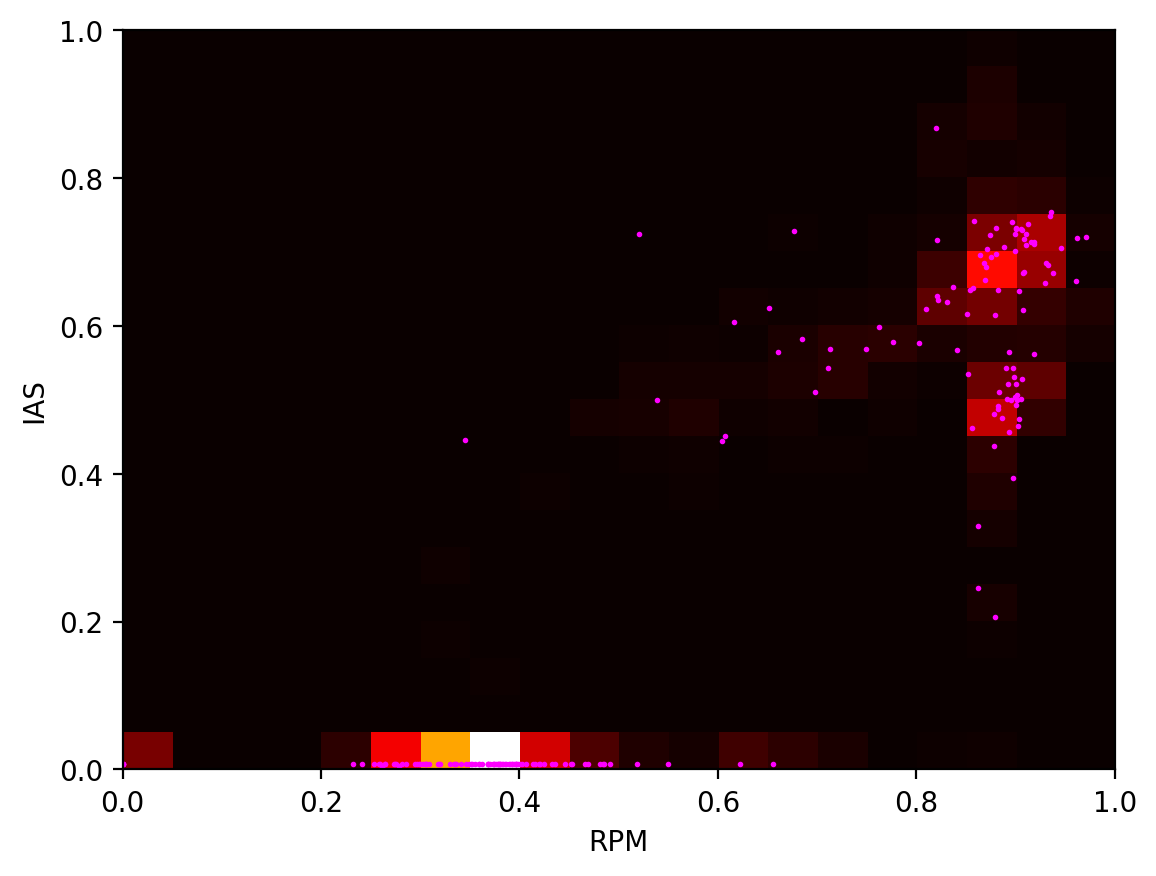

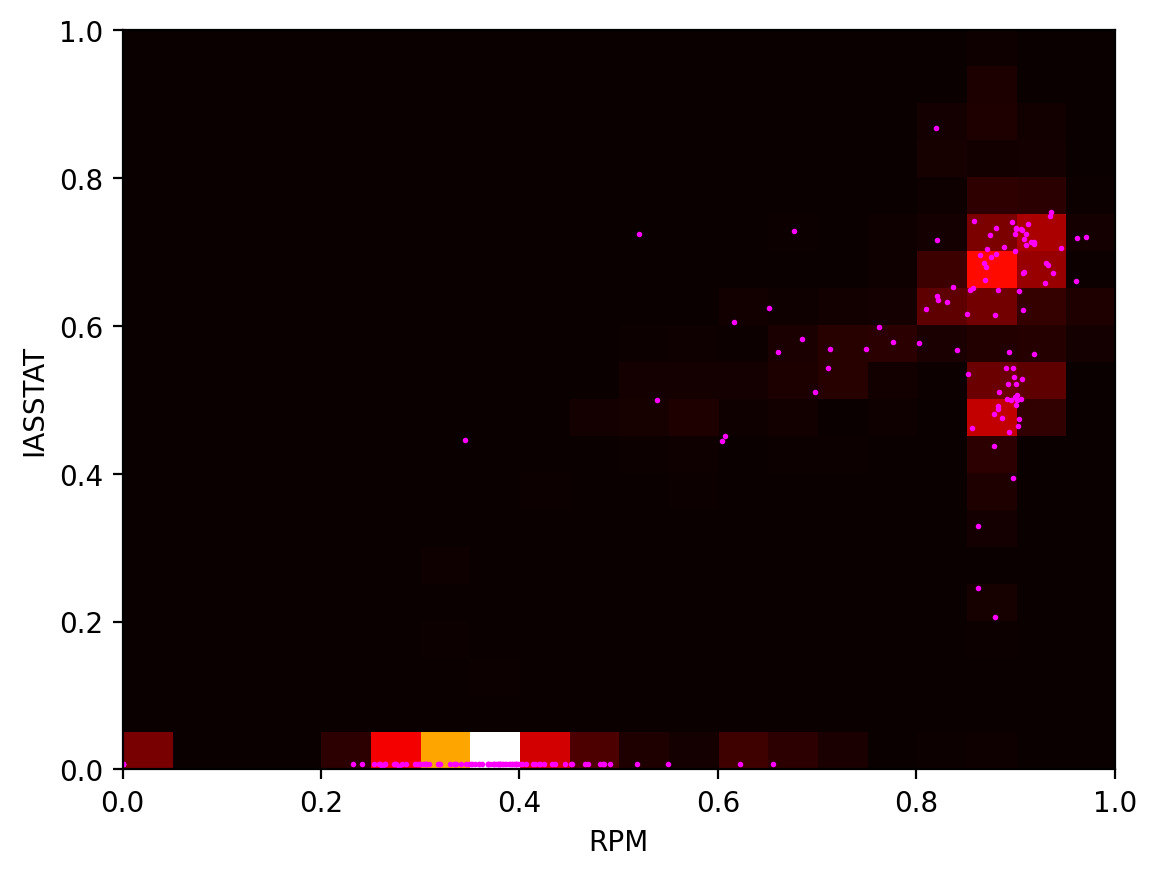

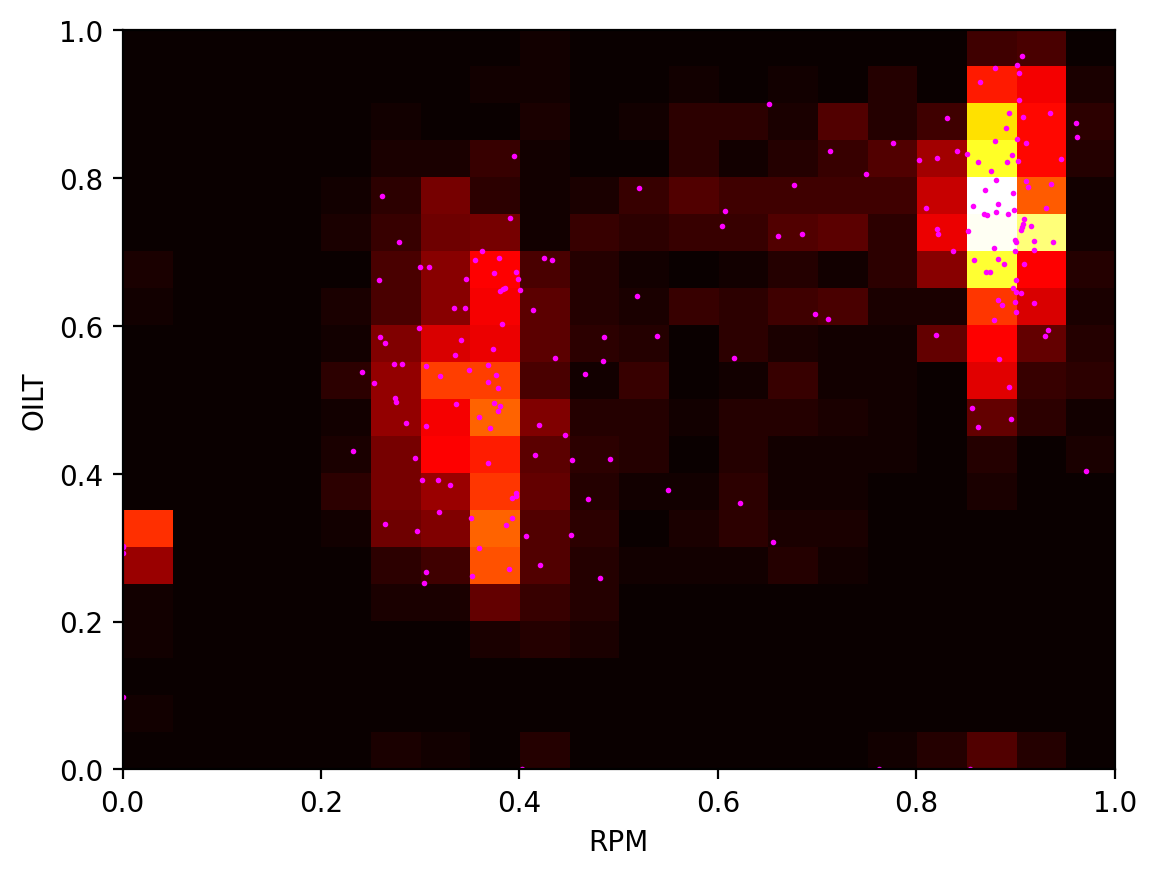

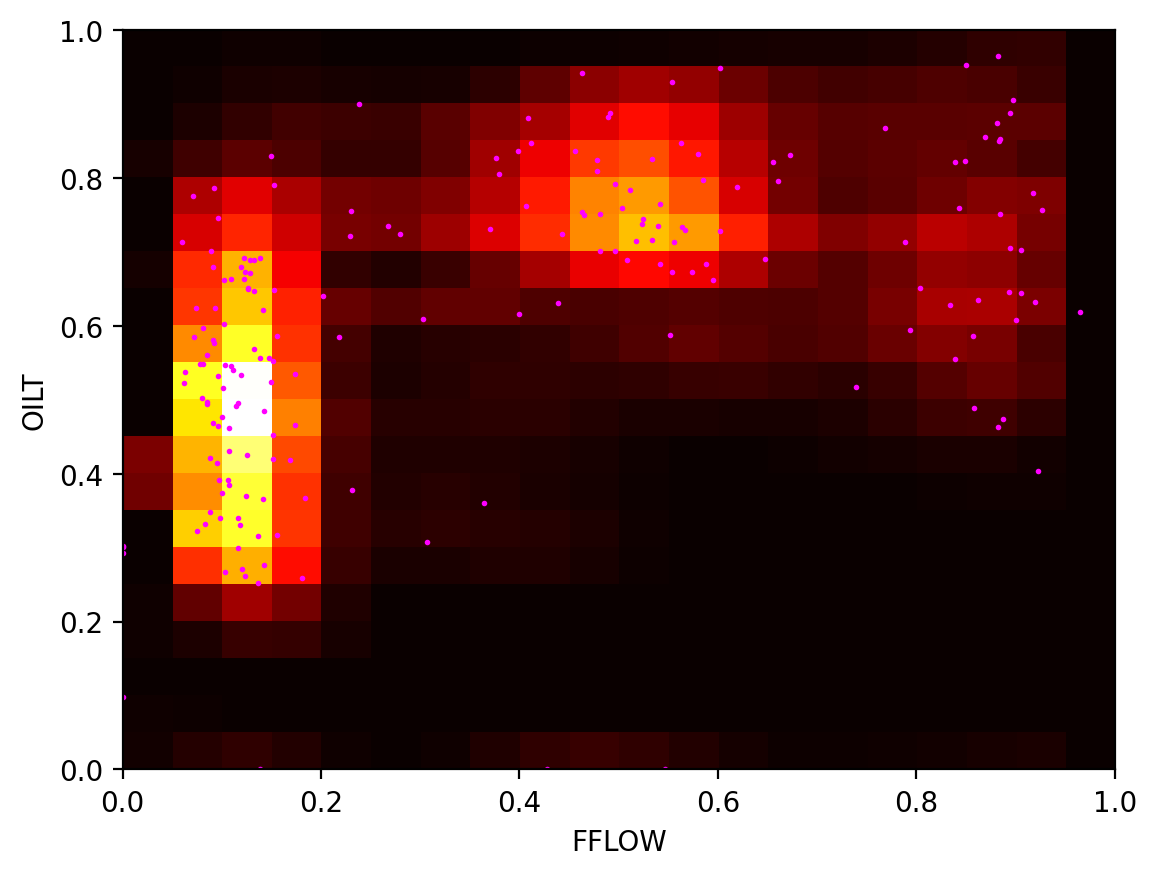

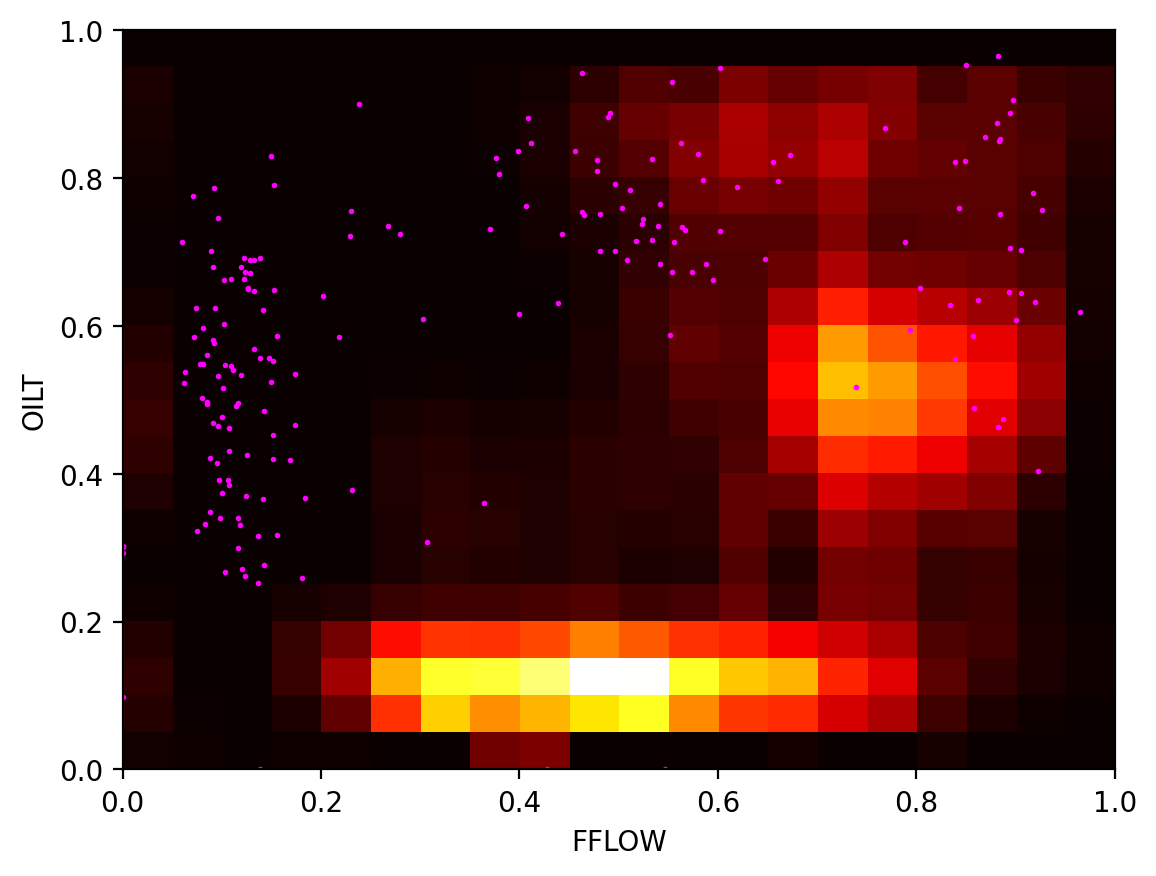

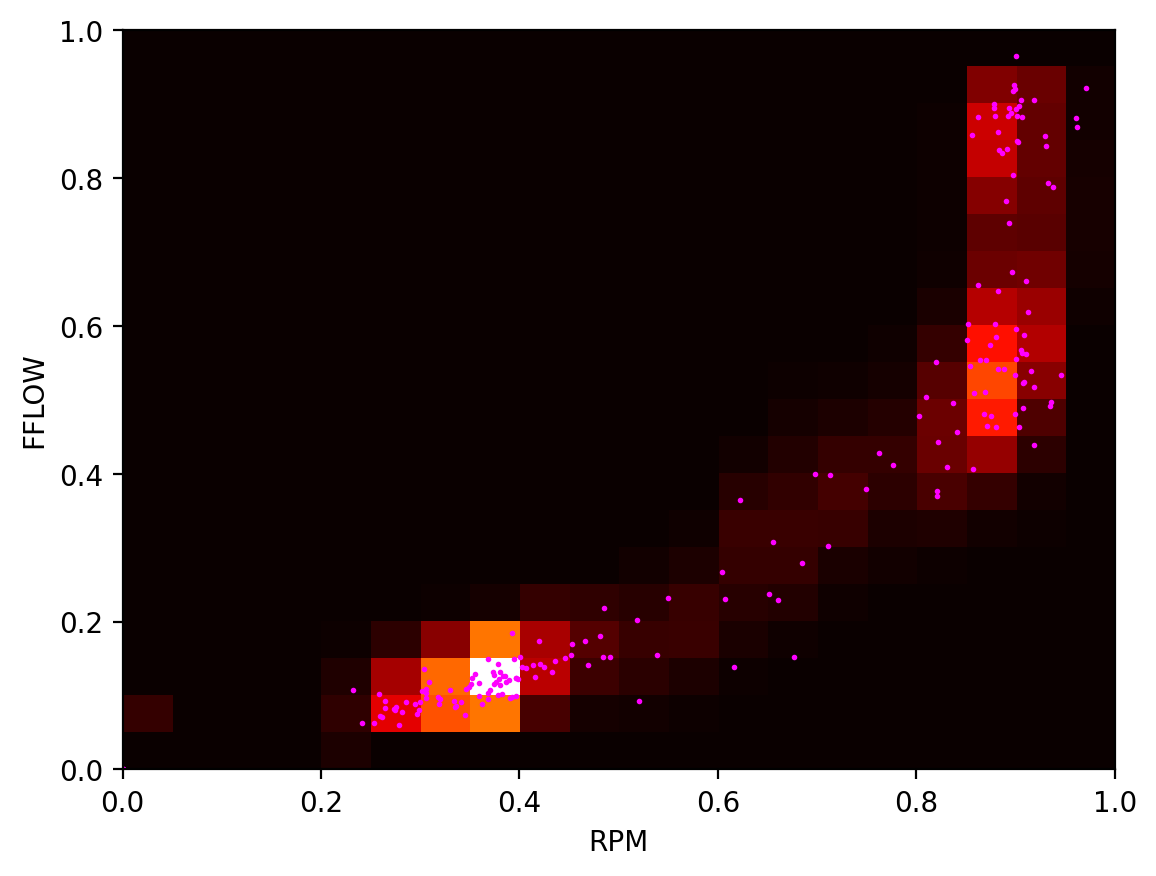

In findNextFunctionAndApply, found function IAS at iteration 1
Required input variables are: ['IASSTAT0', 'IAS0']
Input pmf is ['RPM0', 'OILT0', 'IAS0', 'ALT0', 'OILTSTAT0', 'IASSTAT0', 'FFLOW0']
Output pmf has variables ['RPM0', 'OILT0', 'IAS0', 'ALT0', 'OILTSTAT0', 'IASSTAT0', 'FFLOW0', 'IAS1']
Variables in the input pmf required by the function are [5, 2]
Node IAS0 no longer required. Deleting...
Node IASSTAT0 no longer required. Deleting...
Node FFLOW0 no longer required. Deleting...
Current Nodes: ['RPM0', 'OILT0', 'ALT0', 'OILTSTAT0', 'RPM3', 'IAS1']
In findNextFunctionAndApply, found function OILT at iteration 1
Required input variables are: ['OILTSTAT0', 'OILT0']
Input pmf is ['RPM0', 'OILT0', 'ALT0', 'OILTSTAT0', 'IAS1']
Output pmf has variables ['RPM0', 'OILT0', 'ALT0', 'OILTSTAT0', 'IAS1', 'OILT1']
Variables in the input pmf required by the function are [3, 1]
Node OILT0 no longer required. Deleting...
Node OILTSTAT0 no longer required. Deleting...
Current Nodes: ['RPM0', 'A

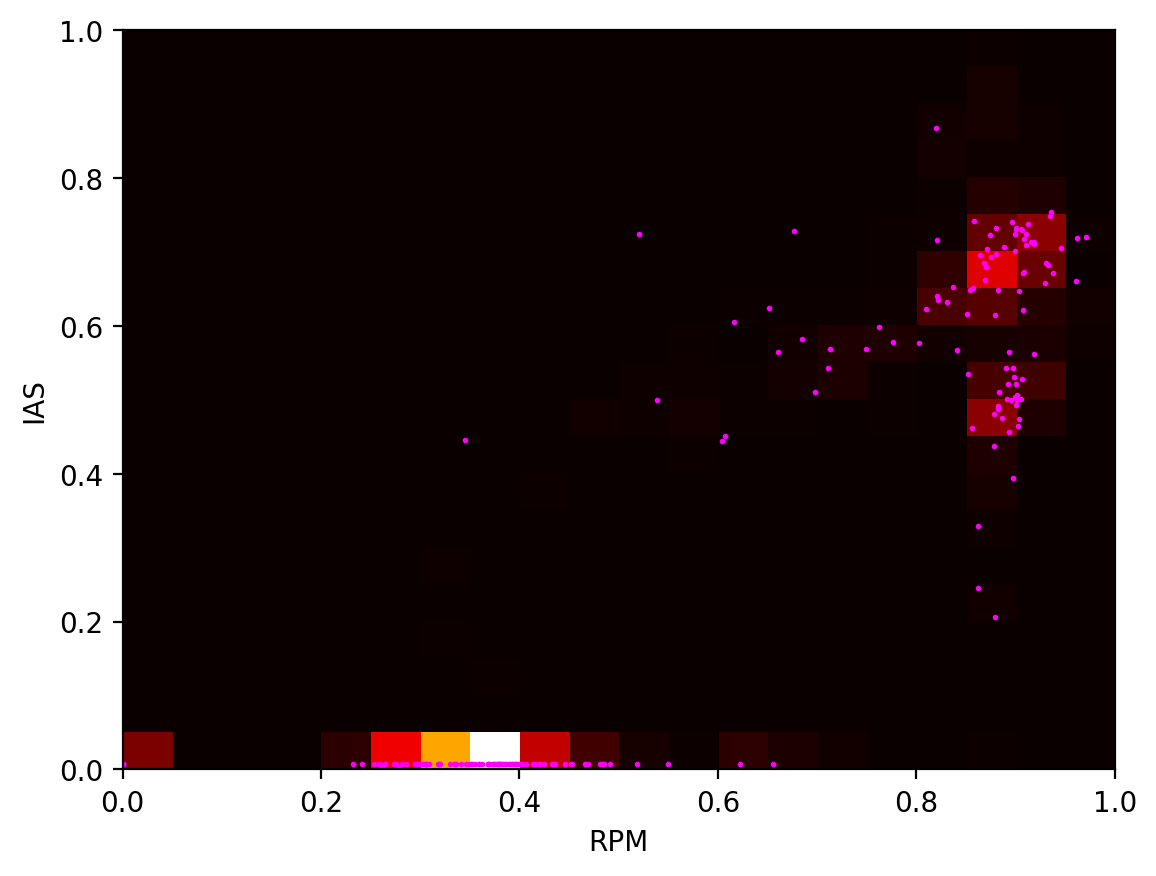

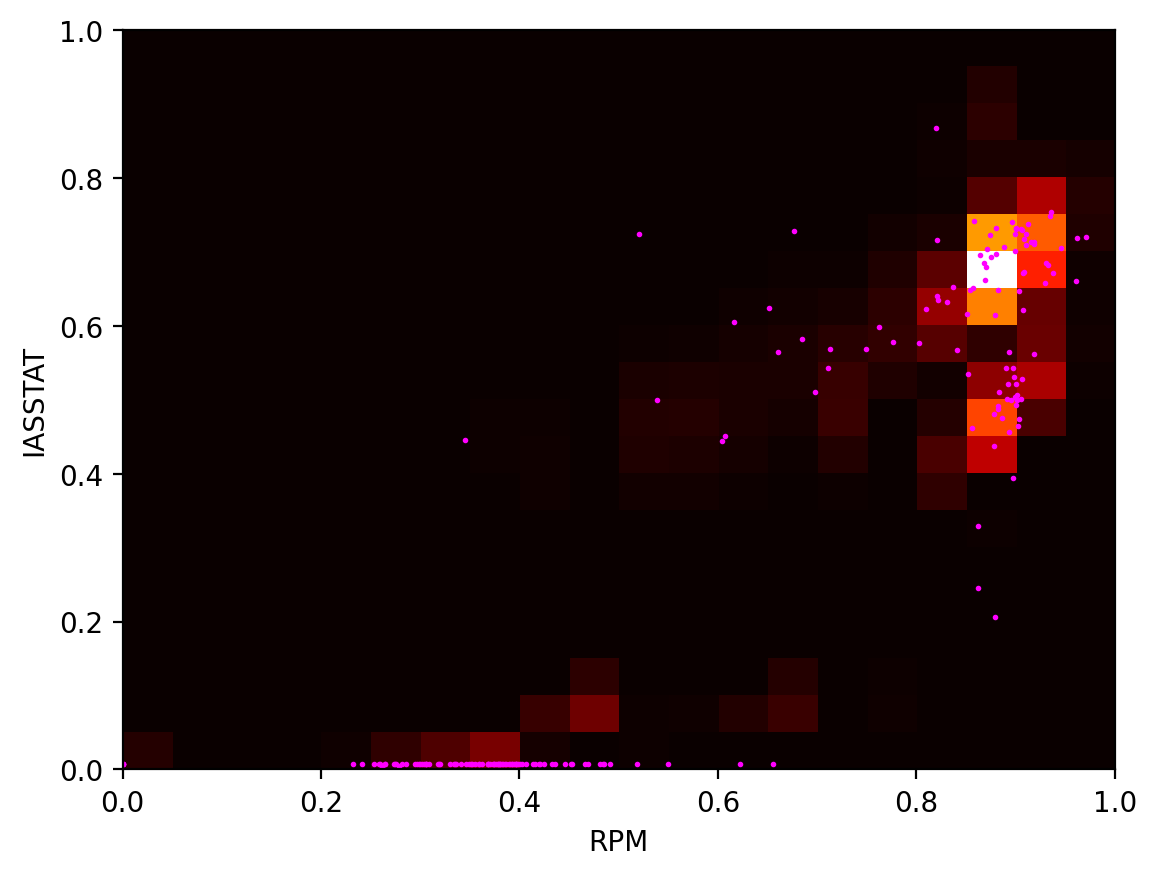

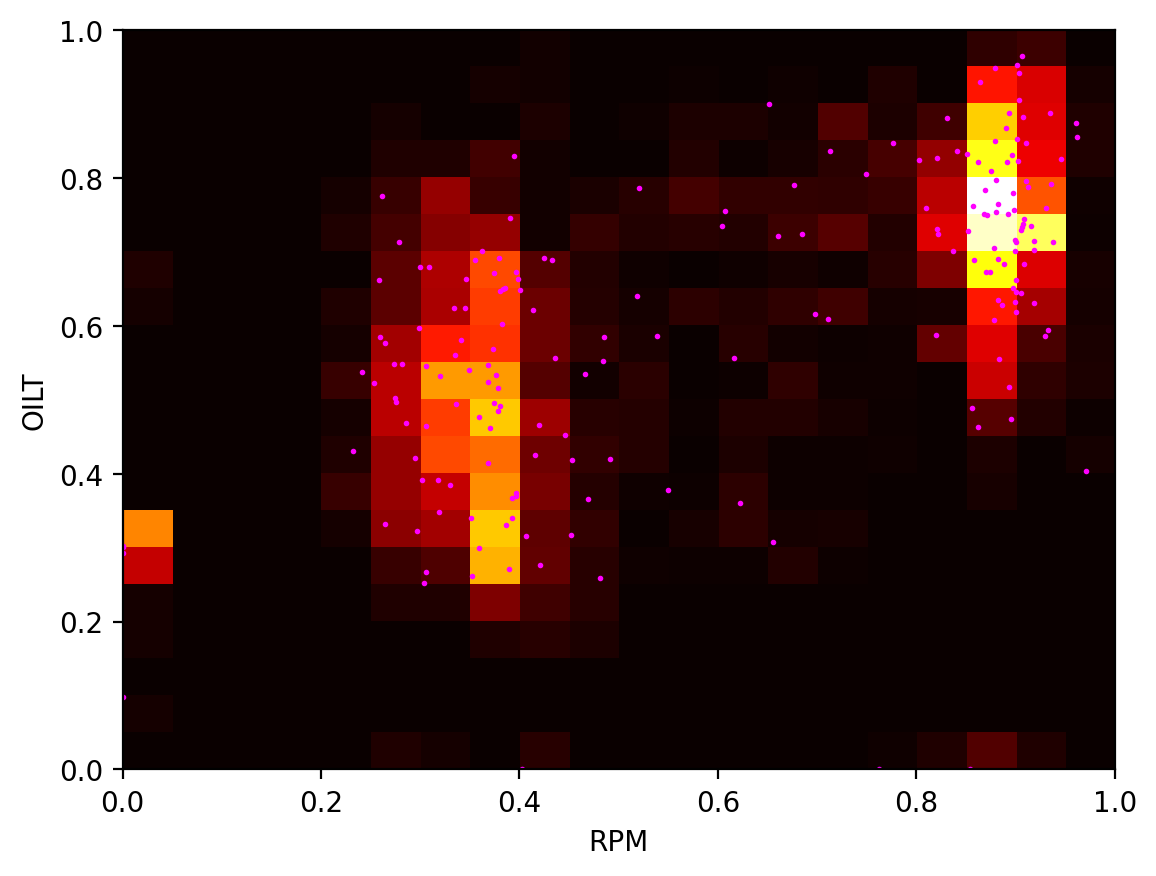

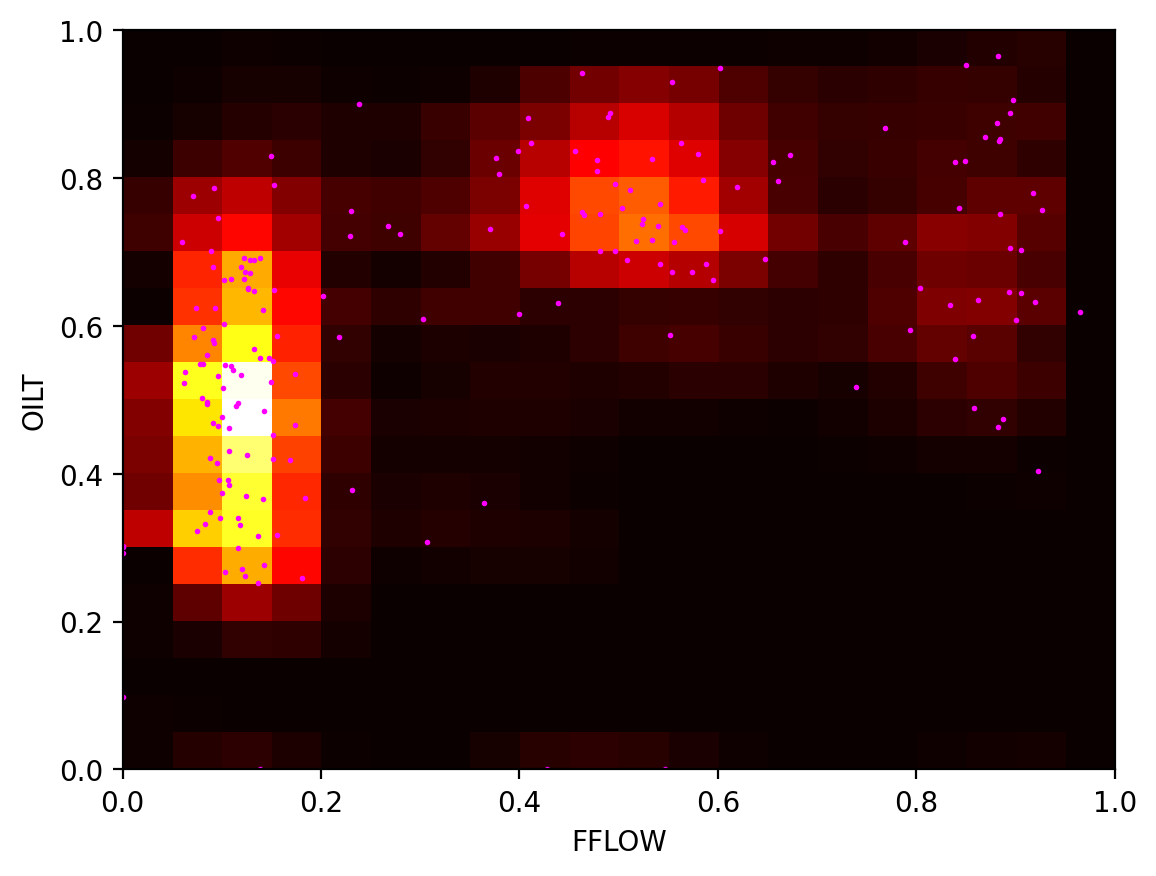

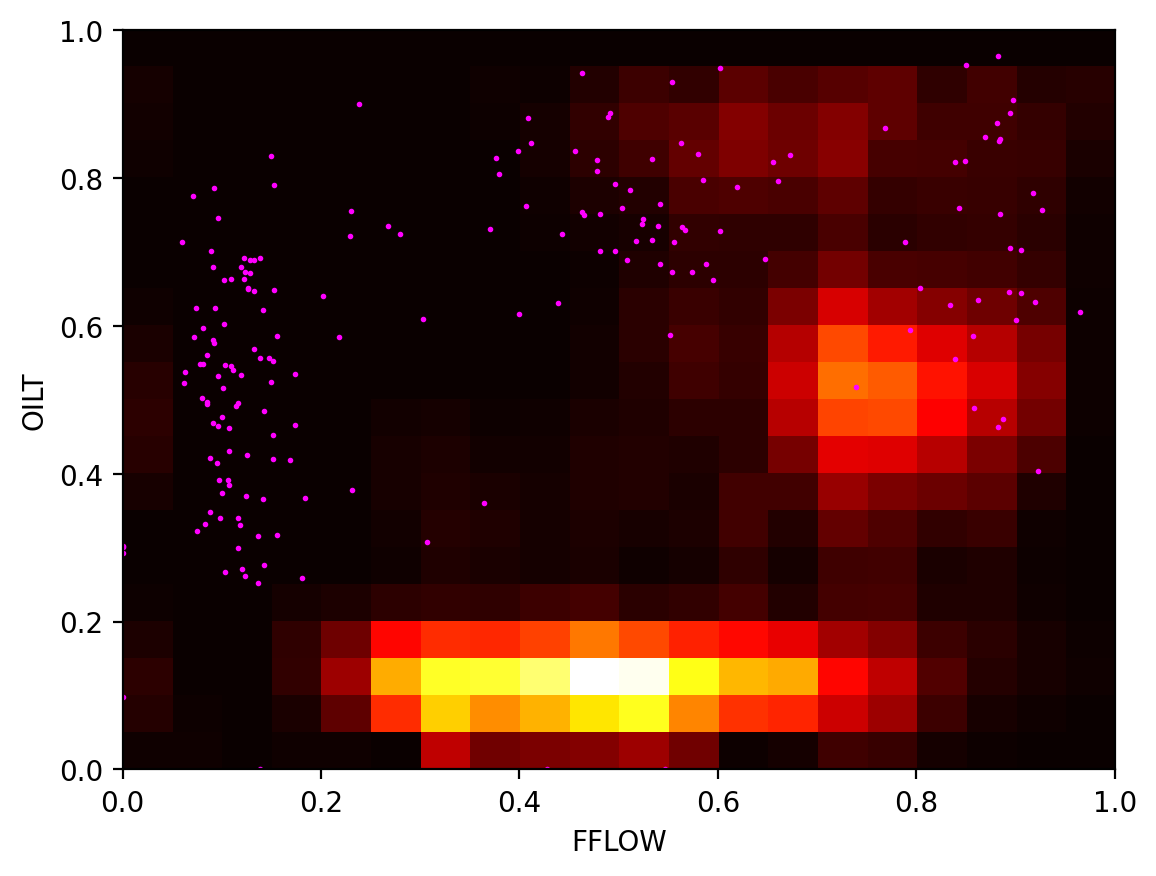

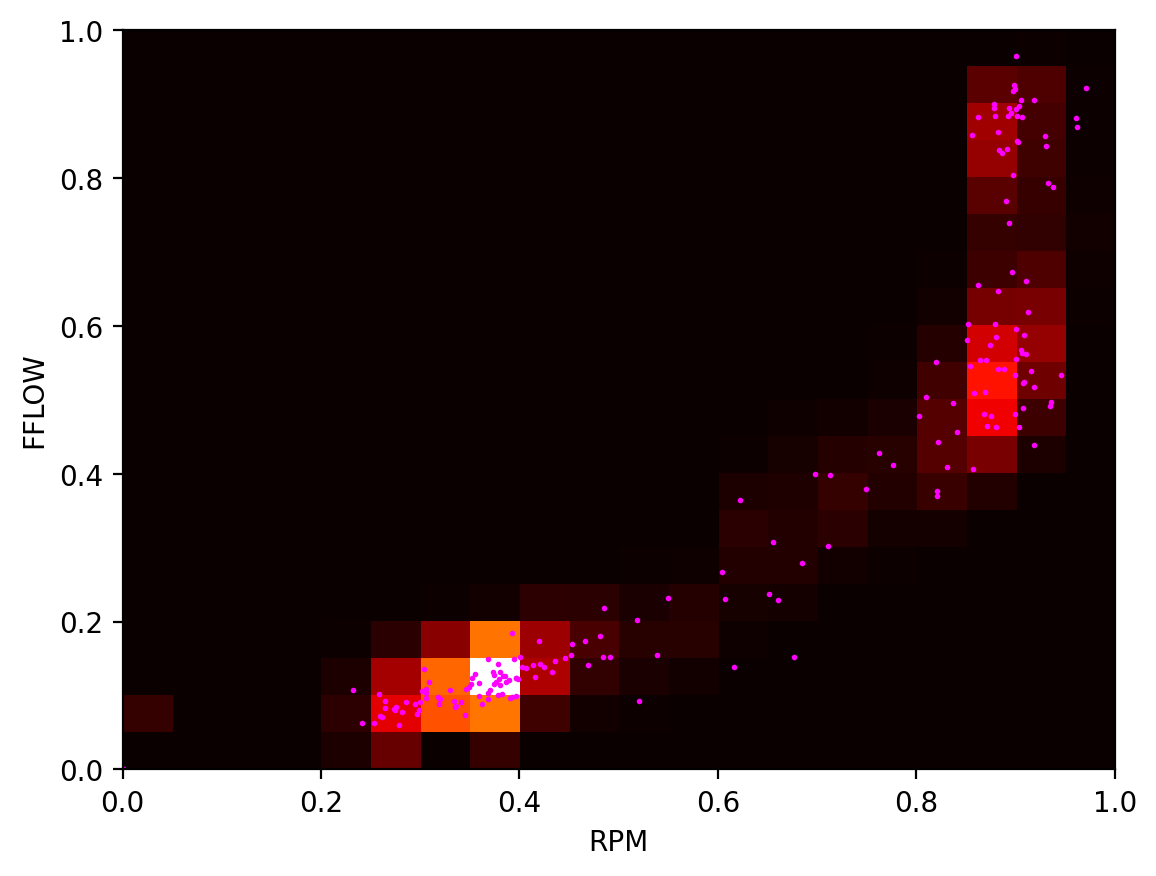

In findNextFunctionAndApply, found function IAS at iteration 2
Required input variables are: ['IASSTAT1', 'IAS1']
Input pmf is ['RPM1', 'ALT1', 'IAS1', 'OILT1', 'FFLOW1', 'OILTSTAT1', 'IASSTAT1']
Output pmf has variables ['RPM1', 'ALT1', 'IAS1', 'OILT1', 'FFLOW1', 'OILTSTAT1', 'IASSTAT1', 'IAS2']
Variables in the input pmf required by the function are [6, 2]
Node IAS1 no longer required. Deleting...
Node FFLOW1 no longer required. Deleting...
Node IASSTAT1 no longer required. Deleting...
Current Nodes: ['RPM3', 'OILT1', 'RPM1', 'OILTSTAT1', 'ALT1', 'IAS2']
In findNextFunctionAndApply, found function OILT at iteration 2
Required input variables are: ['OILTSTAT1', 'OILT1']
Input pmf is ['RPM1', 'ALT1', 'OILT1', 'OILTSTAT1', 'IAS2']
Output pmf has variables ['RPM1', 'ALT1', 'OILT1', 'OILTSTAT1', 'IAS2', 'OILT2']
Variables in the input pmf required by the function are [3, 2]
Node OILT1 no longer required. Deleting...
Node OILTSTAT1 no longer required. Deleting...
Current Nodes: ['RPM3', 'R

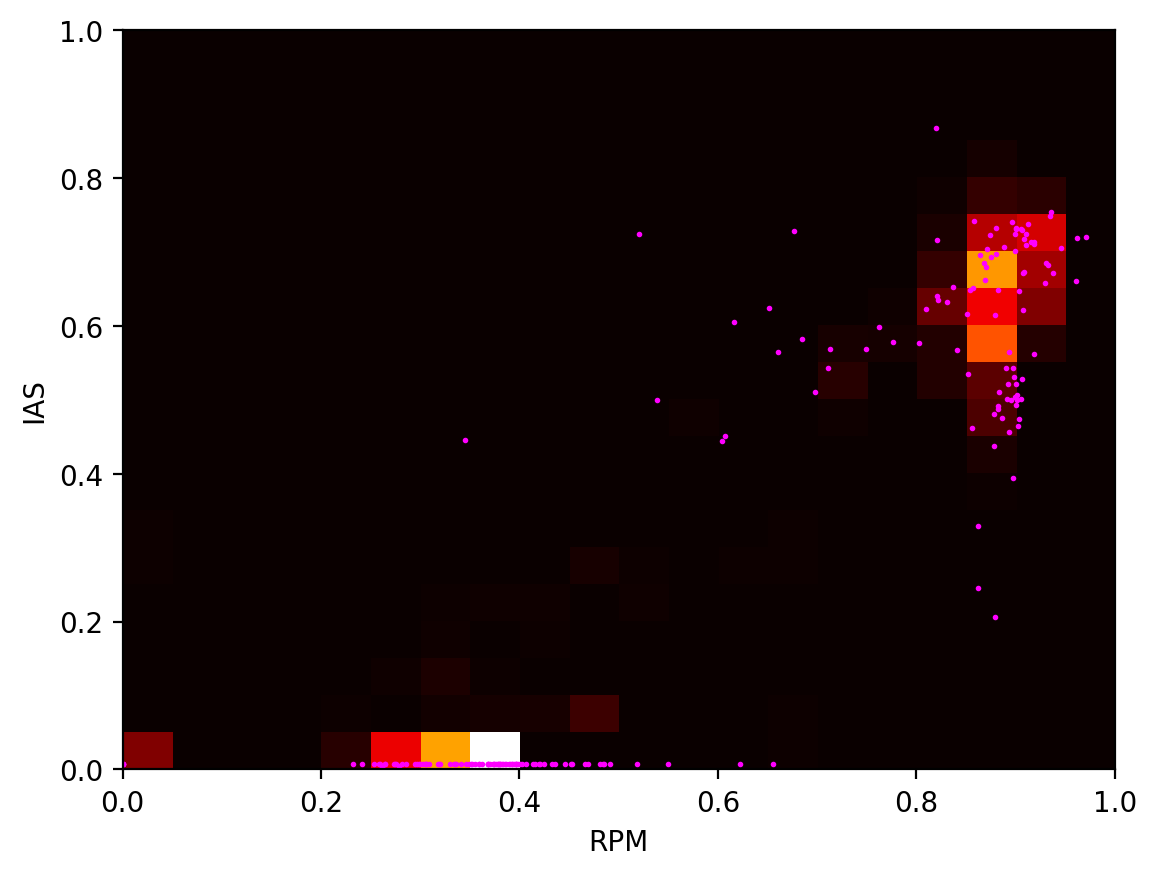

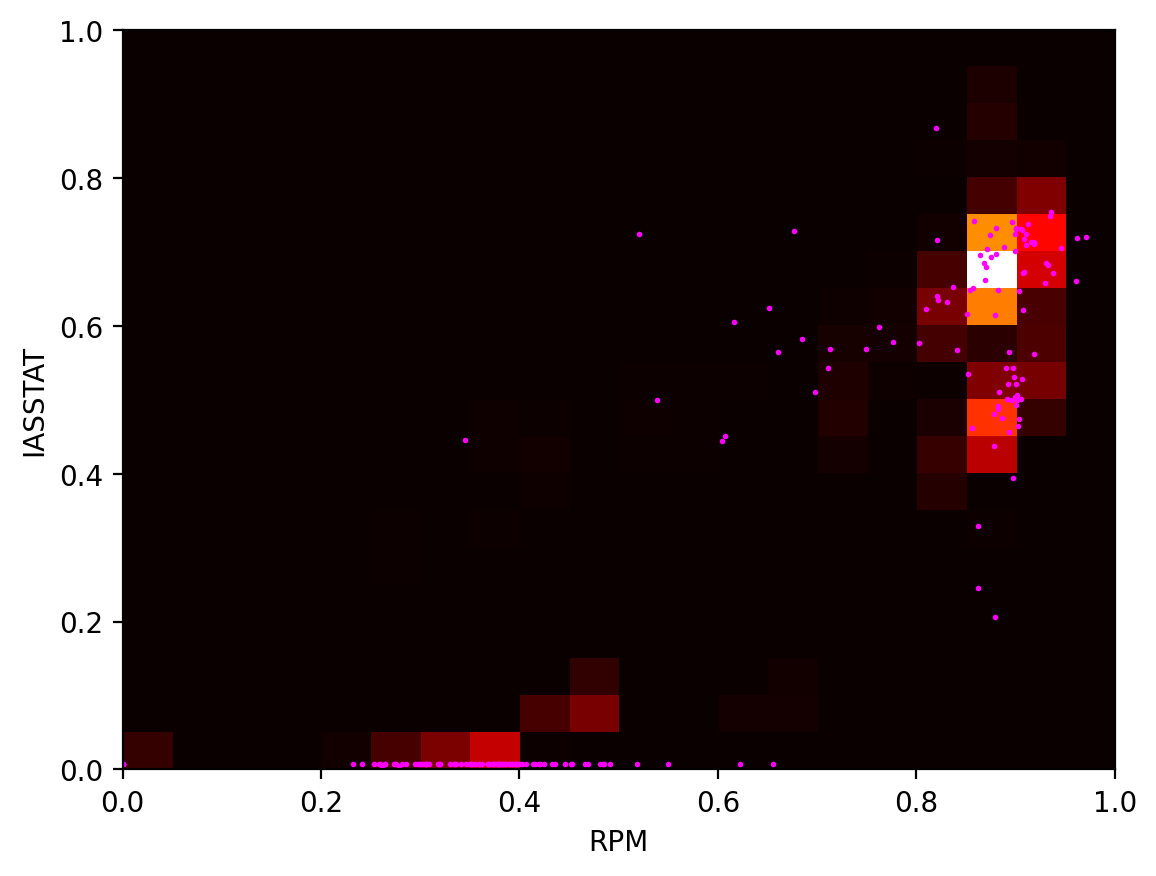

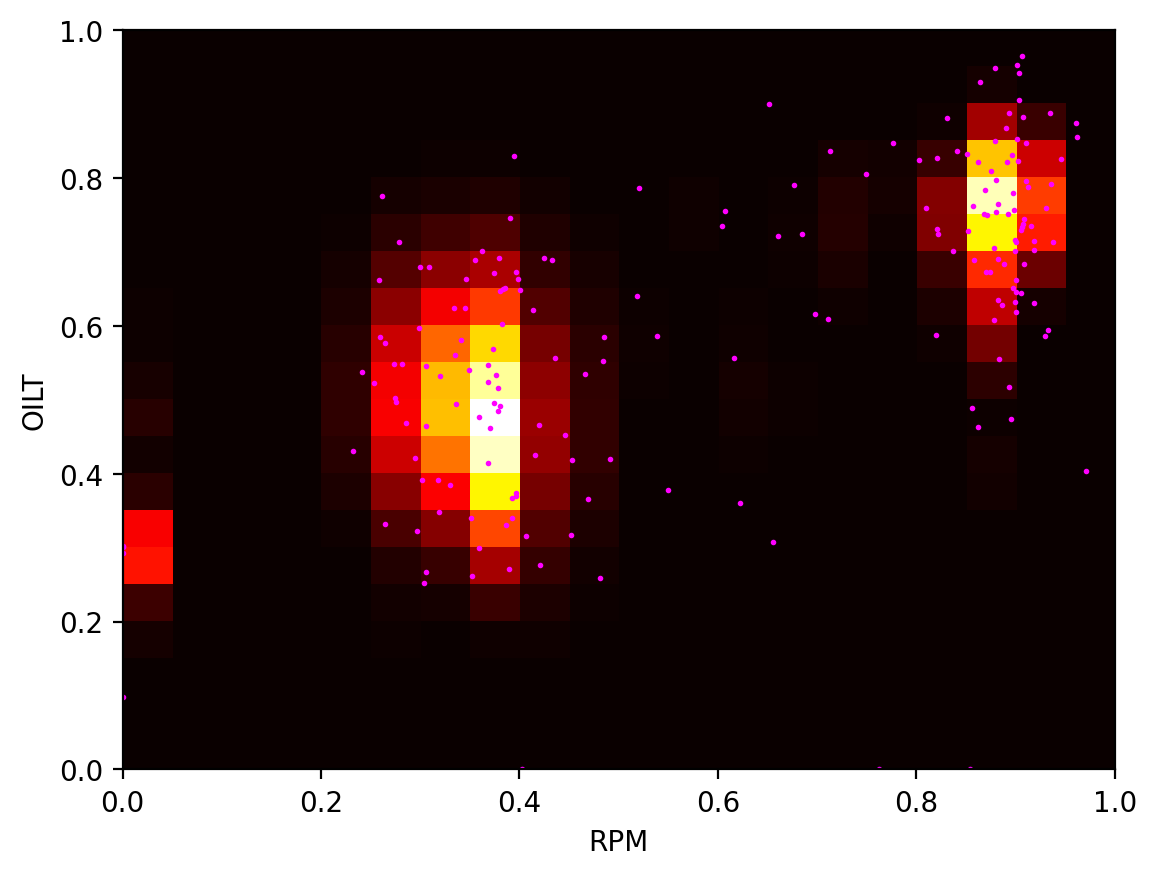

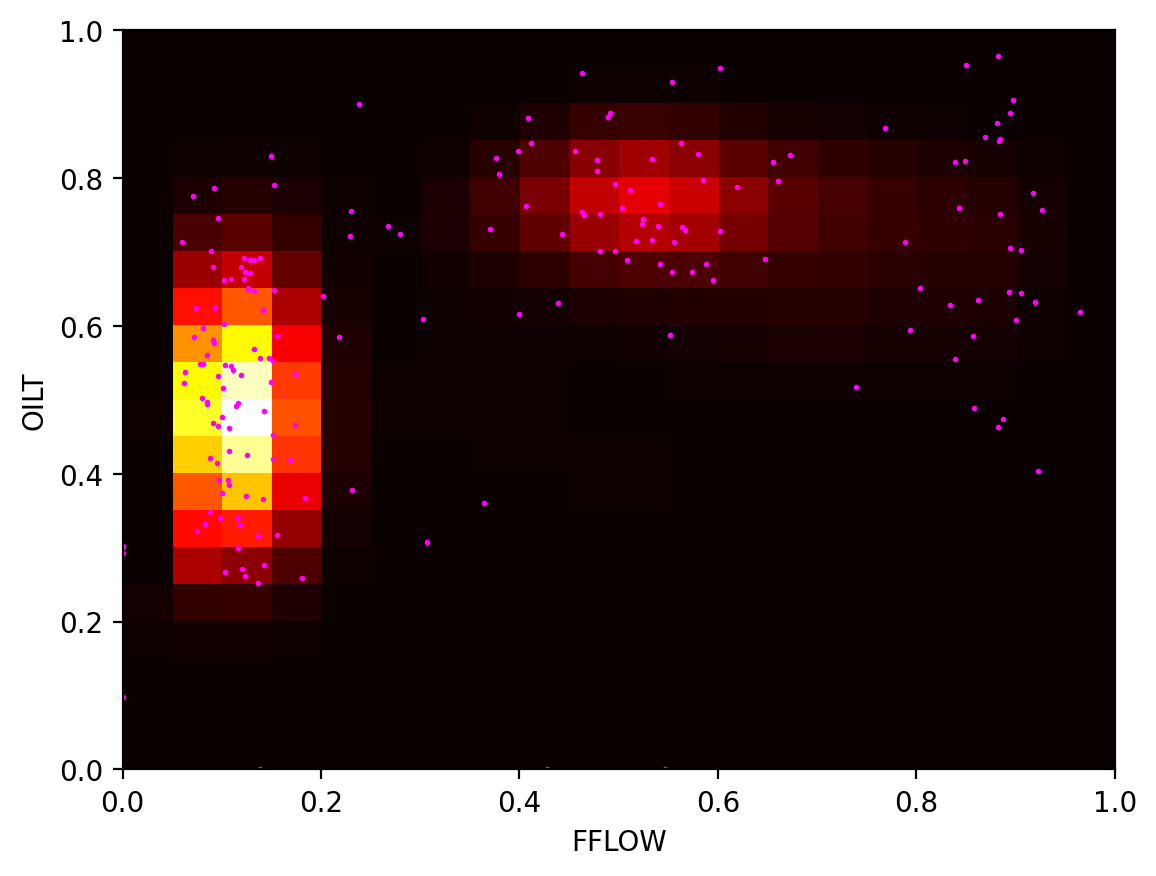

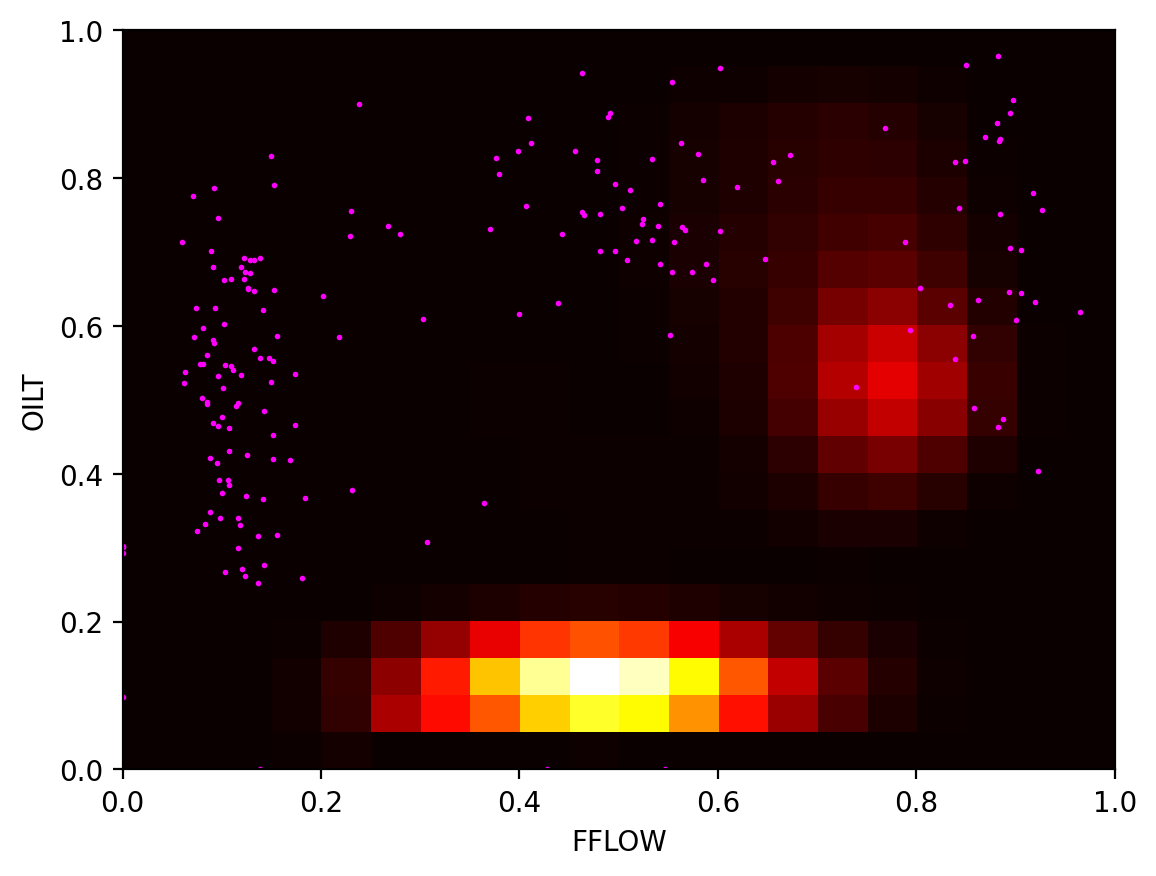

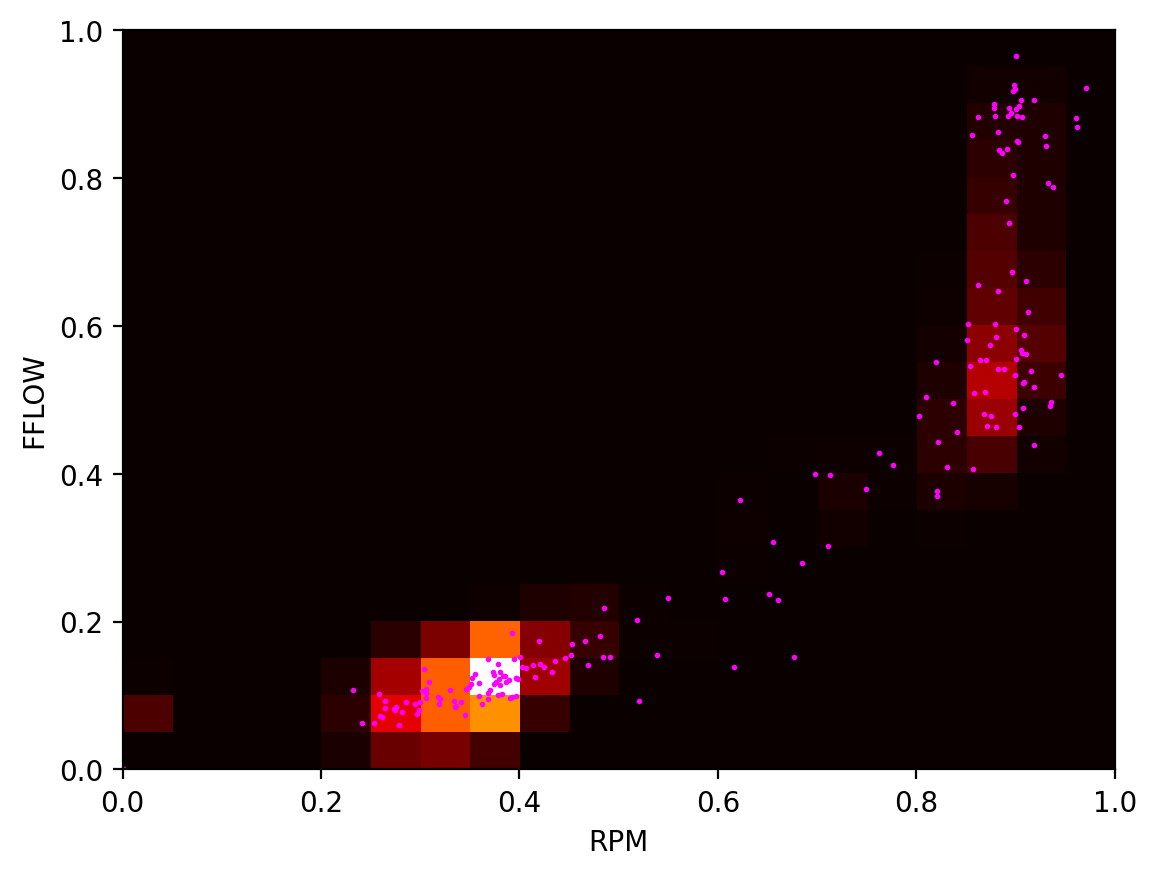

In findNextFunctionAndApply, found function IASSTAT_E at iteration 3
Required input variables are: ['RPM3']
Input pmf is ['RPM3']
Output pmf has variables ['RPM3', 'IASSTAT_E3']
Variables in the input pmf required by the function are [0]
Node RPM2 no longer required. Deleting...
Node FFLOW2 no longer required. Deleting...
Current Nodes: ['RPM3', 'IAS2', 'OILT2', 'OILTSTAT2', 'IASSTAT2', 'ALT2', 'IASSTAT_E3']
In findNextFunctionAndApply, found function IASSTAT_N at iteration 3
Required input variables are: ['RPM3']
Input pmf is ['RPM3', 'IASSTAT_E3']
Output pmf has variables ['RPM3', 'IASSTAT_E3', 'IASSTAT_N3']
Variables in the input pmf required by the function are [0]
Current Nodes: ['RPM3', 'IAS2', 'OILT2', 'OILTSTAT2', 'IASSTAT2', 'ALT2', 'IASSTAT_E3', 'IASSTAT_N3']
In findNextFunctionAndApply, found function IASSTAT at iteration 3
Required input variables are: ['IASSTAT_E3', 'IASSTAT_N3']
Input pmf is ['RPM3', 'IASSTAT_E3', 'IASSTAT_N3']
Output pmf has variables ['RPM3', 'IASSTAT_E

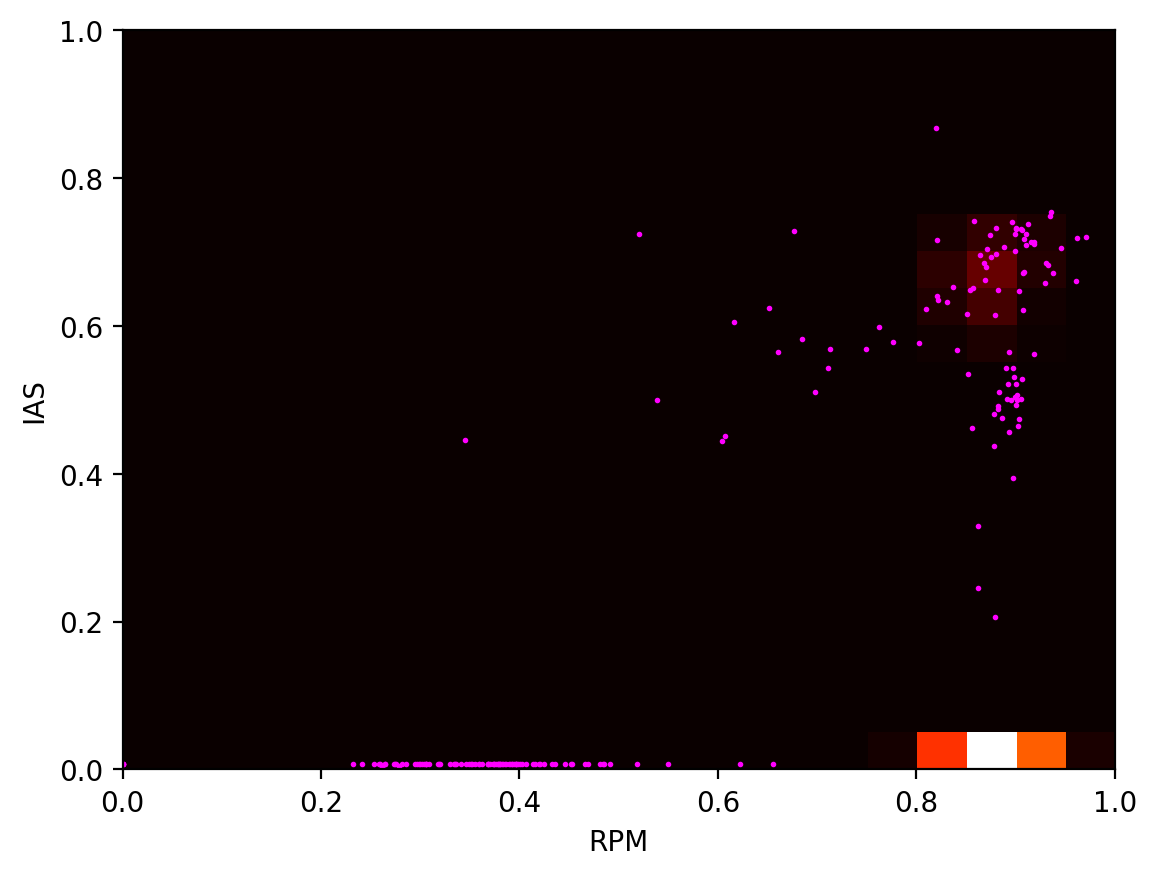

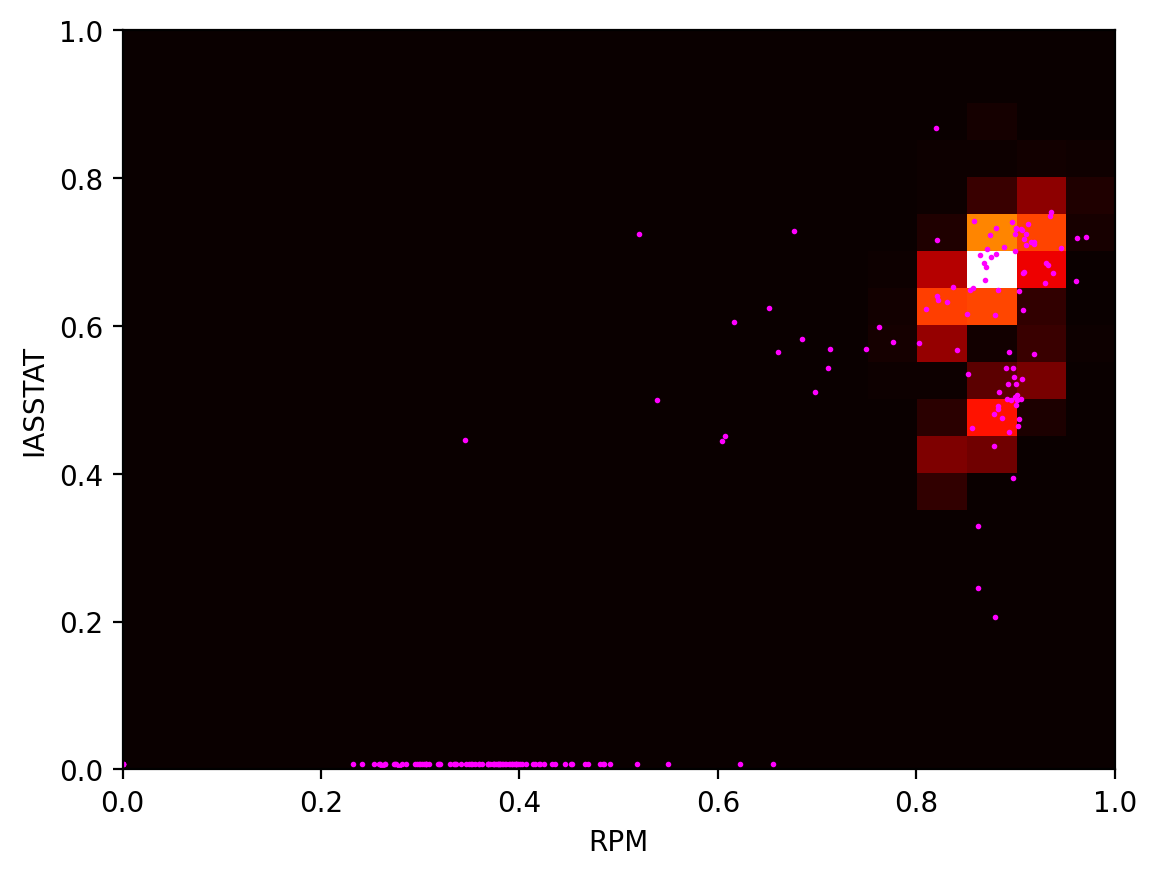

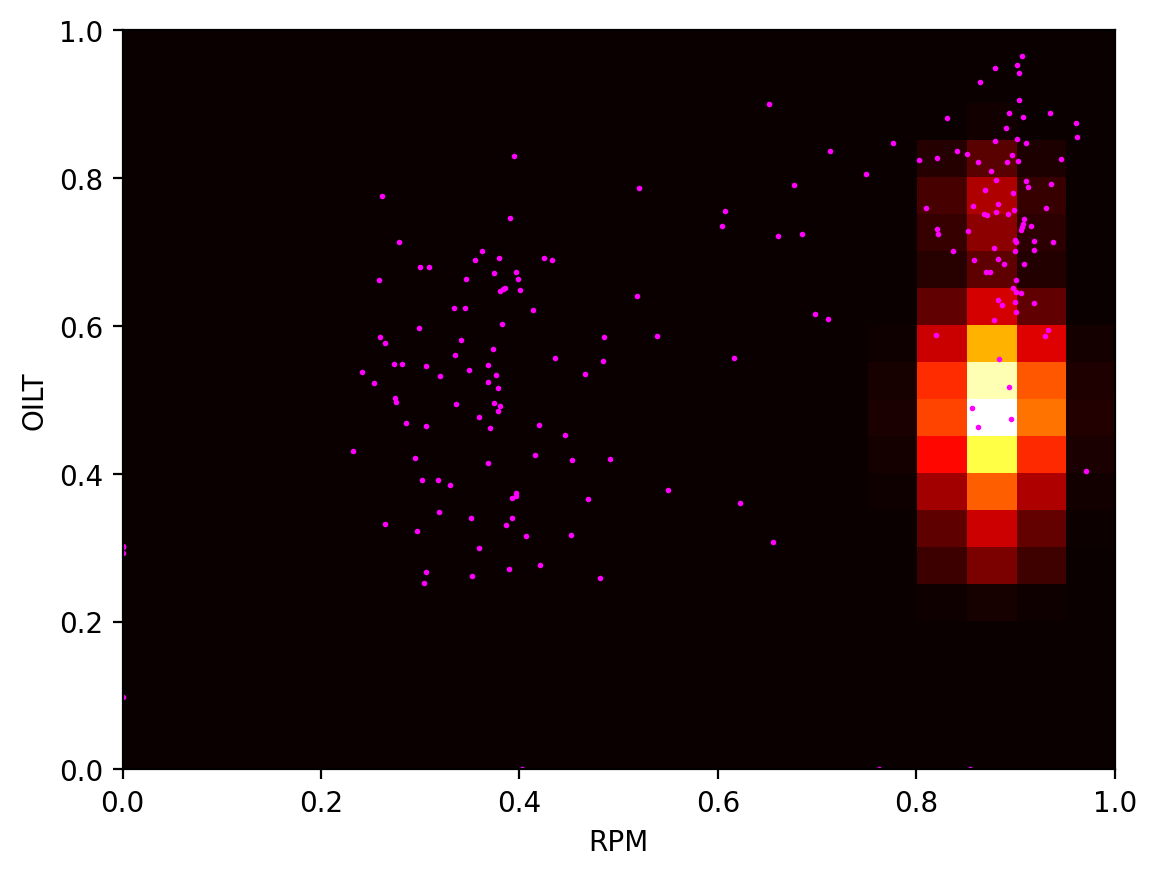

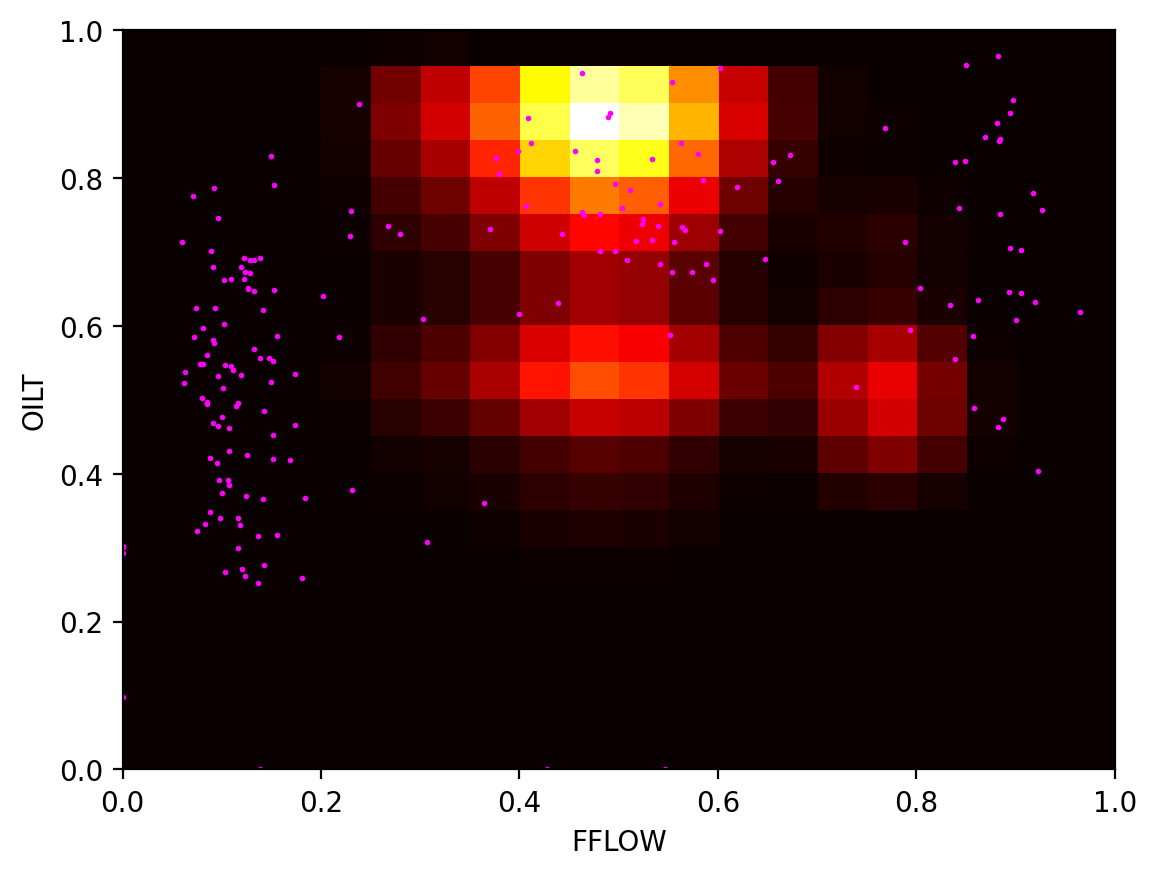

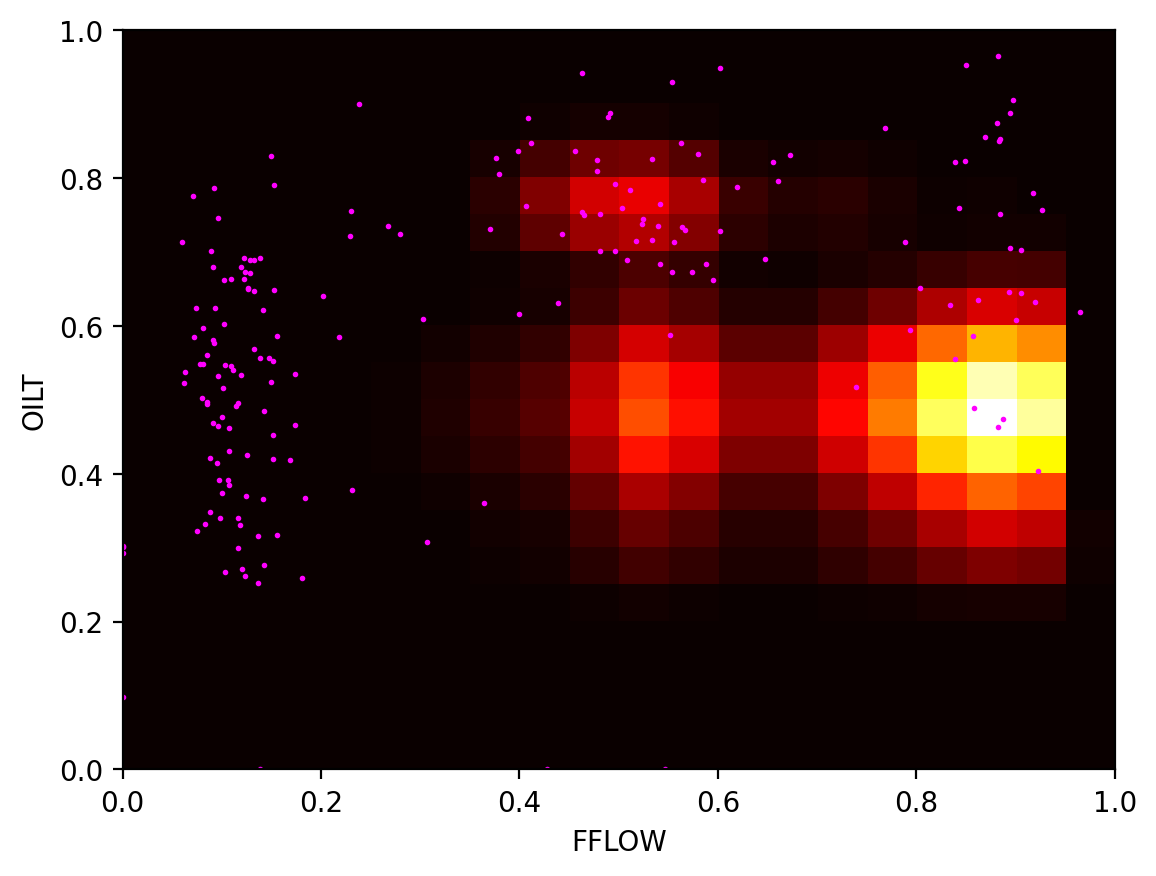

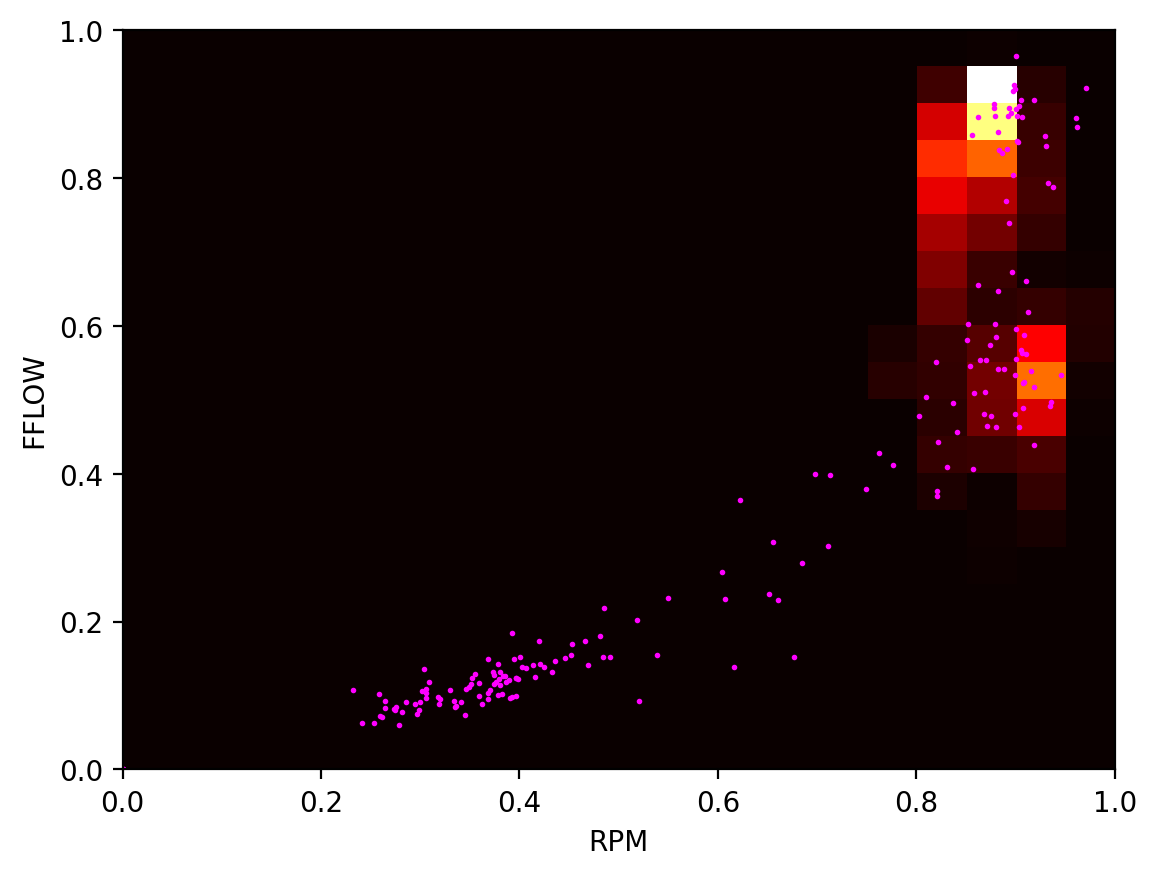

In findNextFunctionAndApply, found function IAS at iteration 4
Required input variables are: ['IASSTAT3', 'IAS3']
Input pmf is ['RPM3', 'IASSTAT3', 'ALT3', 'IAS3', 'FFLOW3', 'OILTSTAT3', 'OILT3']
Output pmf has variables ['RPM3', 'IASSTAT3', 'ALT3', 'IAS3', 'FFLOW3', 'OILTSTAT3', 'OILT3', 'IAS4']
Variables in the input pmf required by the function are [1, 3]
Node IASSTAT3 no longer required. Deleting...
Node IAS3 no longer required. Deleting...
Node FFLOW3 no longer required. Deleting...
Current Nodes: ['RPM3', 'OILTSTAT3', 'OILT3', 'ALT3', 'IAS4']
In findNextFunctionAndApply, found function OILT at iteration 4
Required input variables are: ['OILTSTAT3', 'OILT3']
Input pmf is ['RPM3', 'ALT3', 'OILTSTAT3', 'OILT3', 'IAS4']
Output pmf has variables ['RPM3', 'ALT3', 'OILTSTAT3', 'OILT3', 'IAS4', 'OILT4']
Variables in the input pmf required by the function are [2, 3]
Node OILTSTAT3 no longer required. Deleting...
Node OILT3 no longer required. Deleting...
Current Nodes: ['RPM3', 'ALT3', 'I

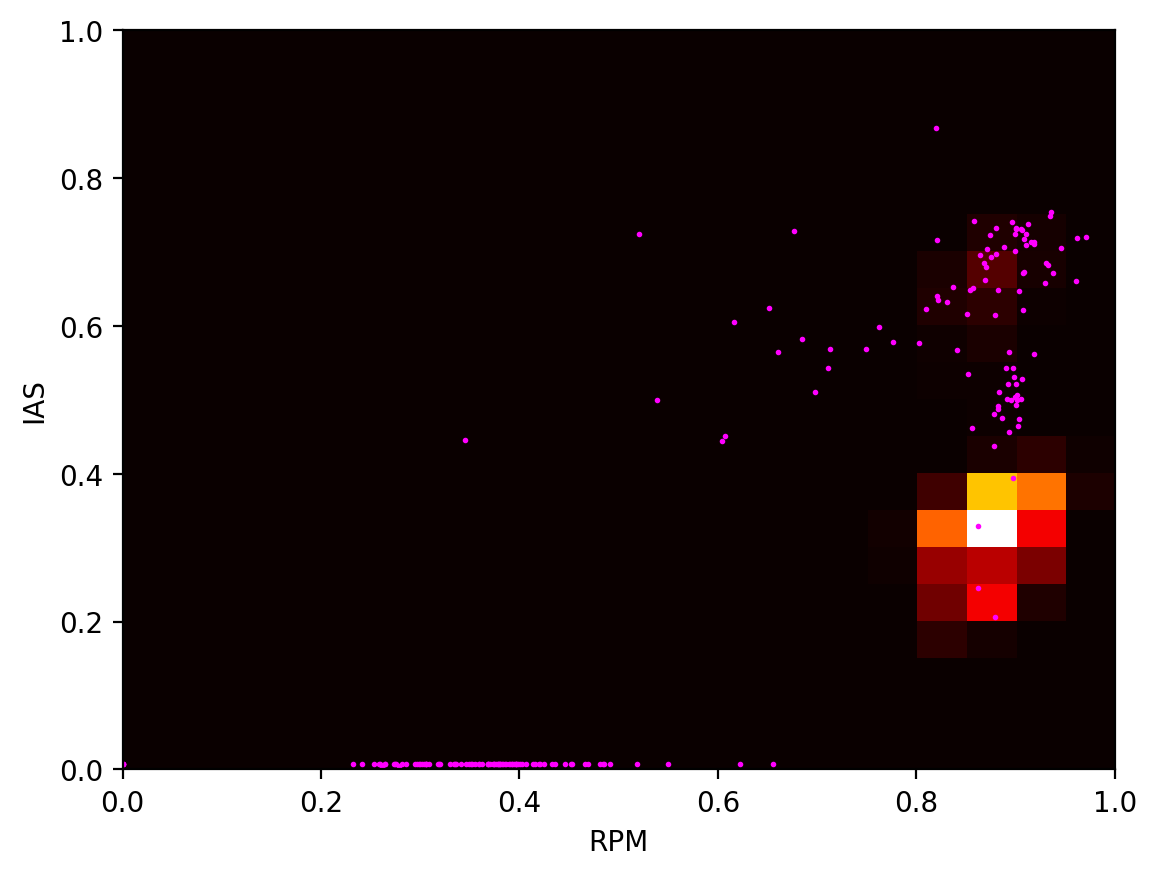

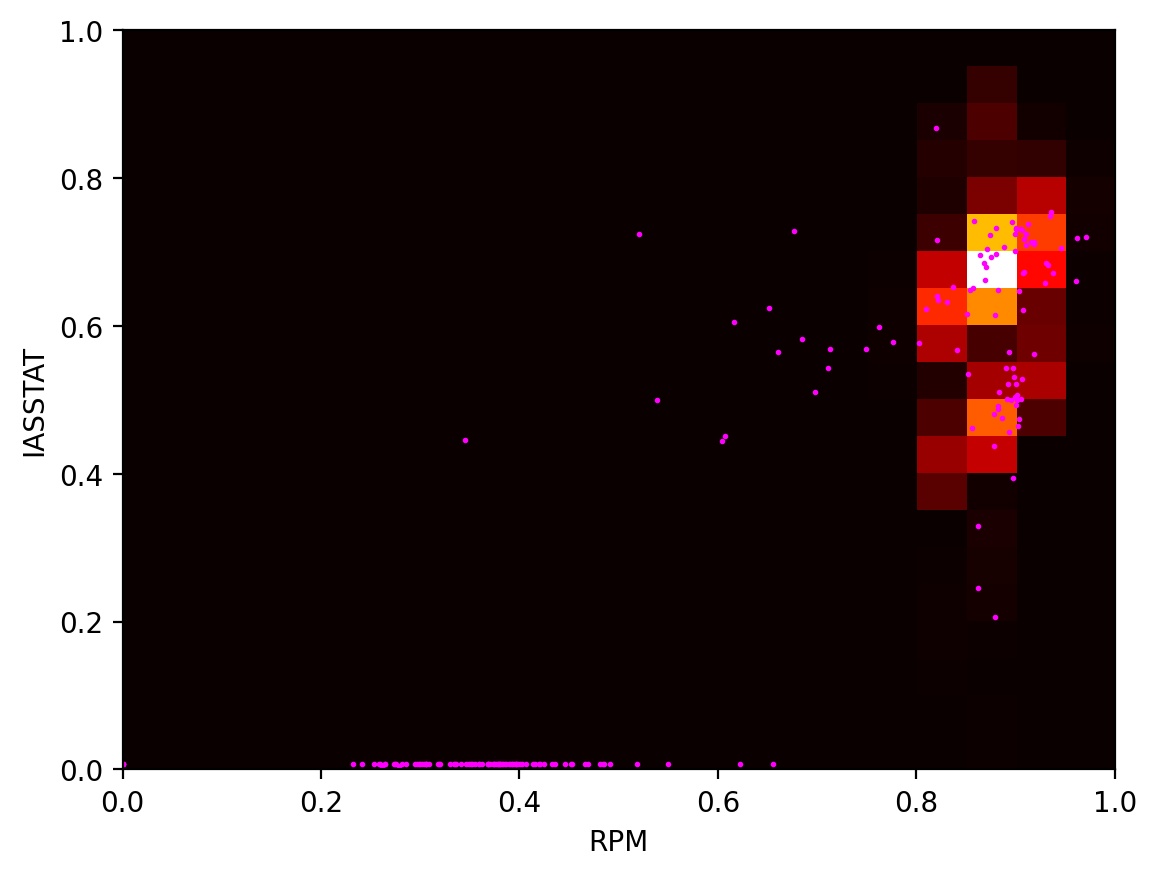

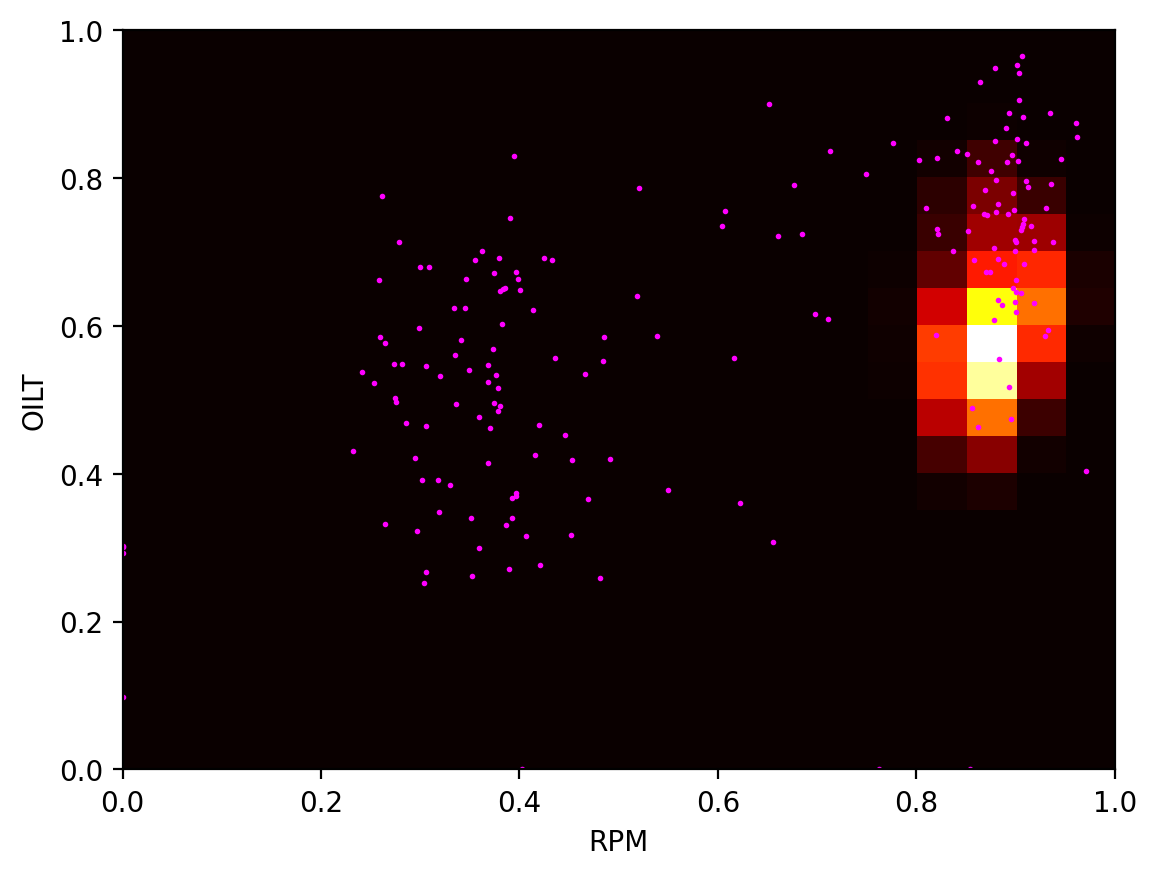

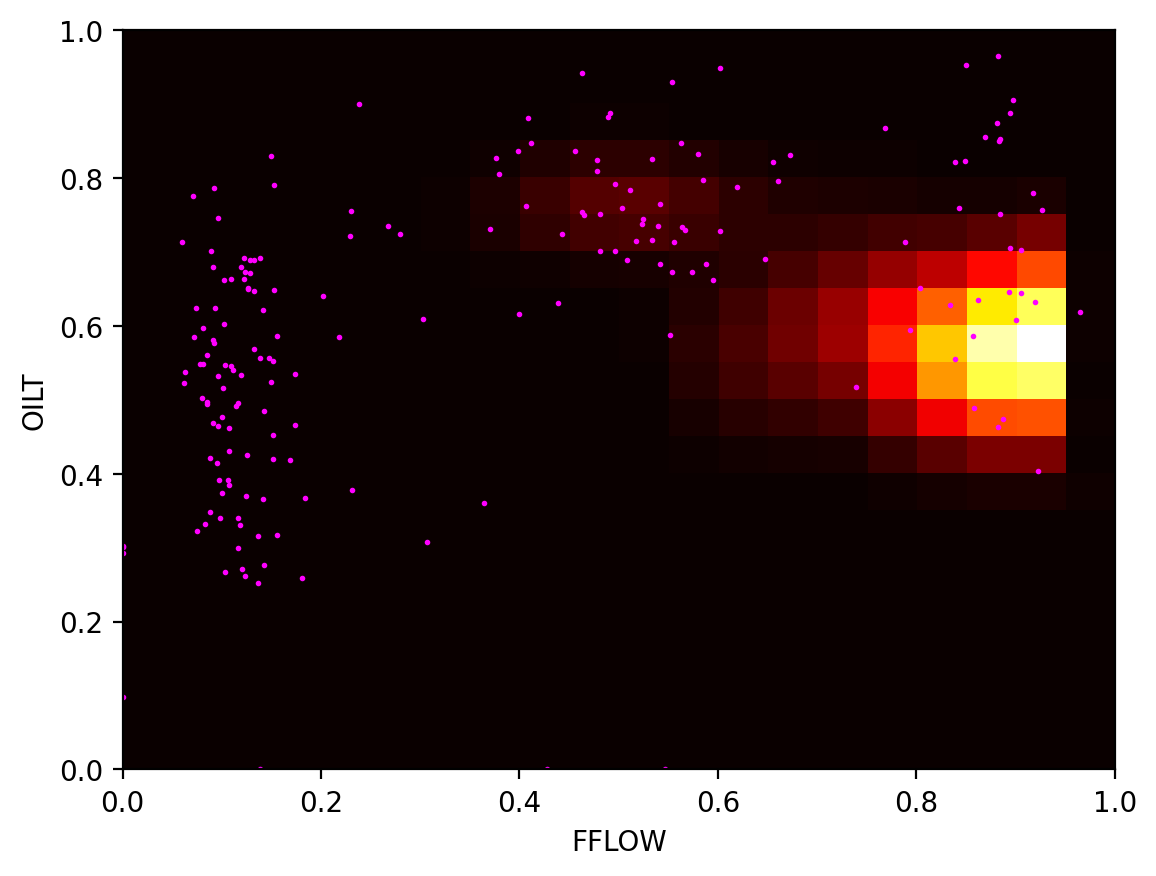

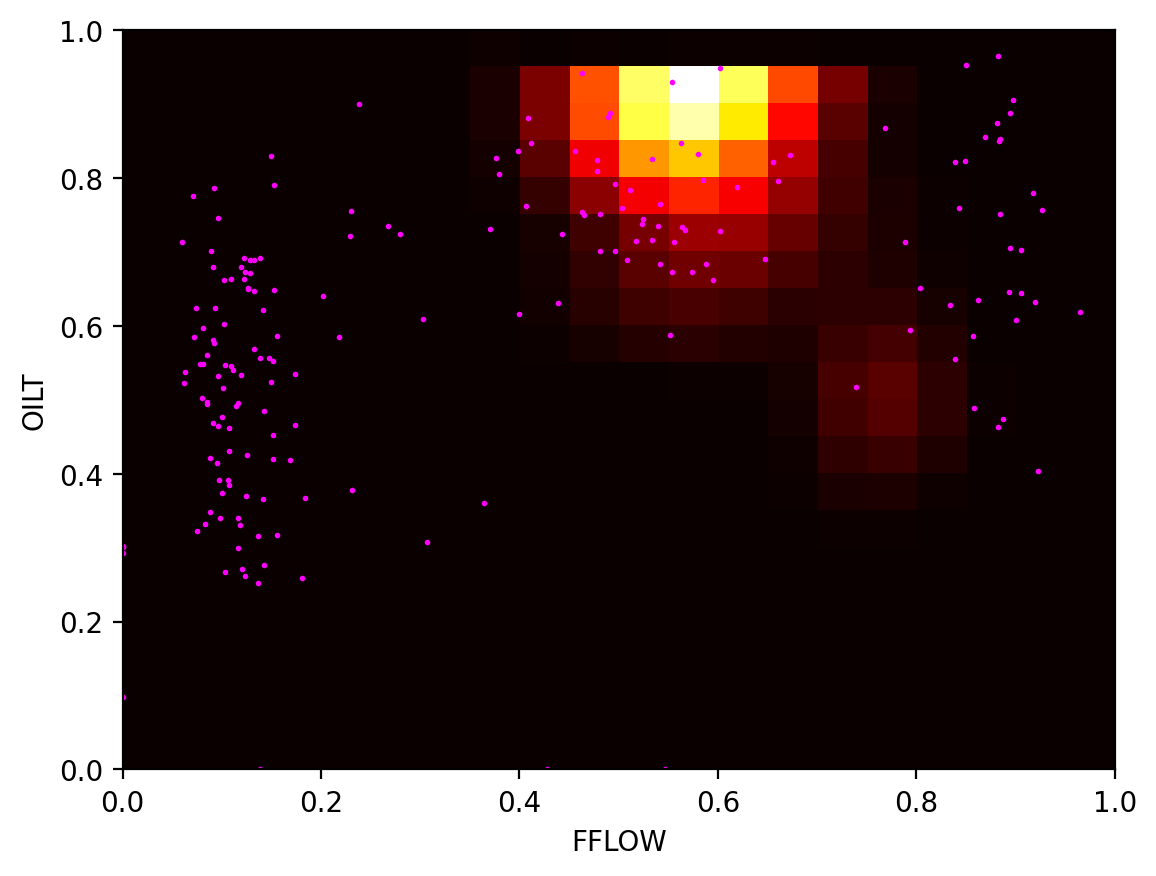

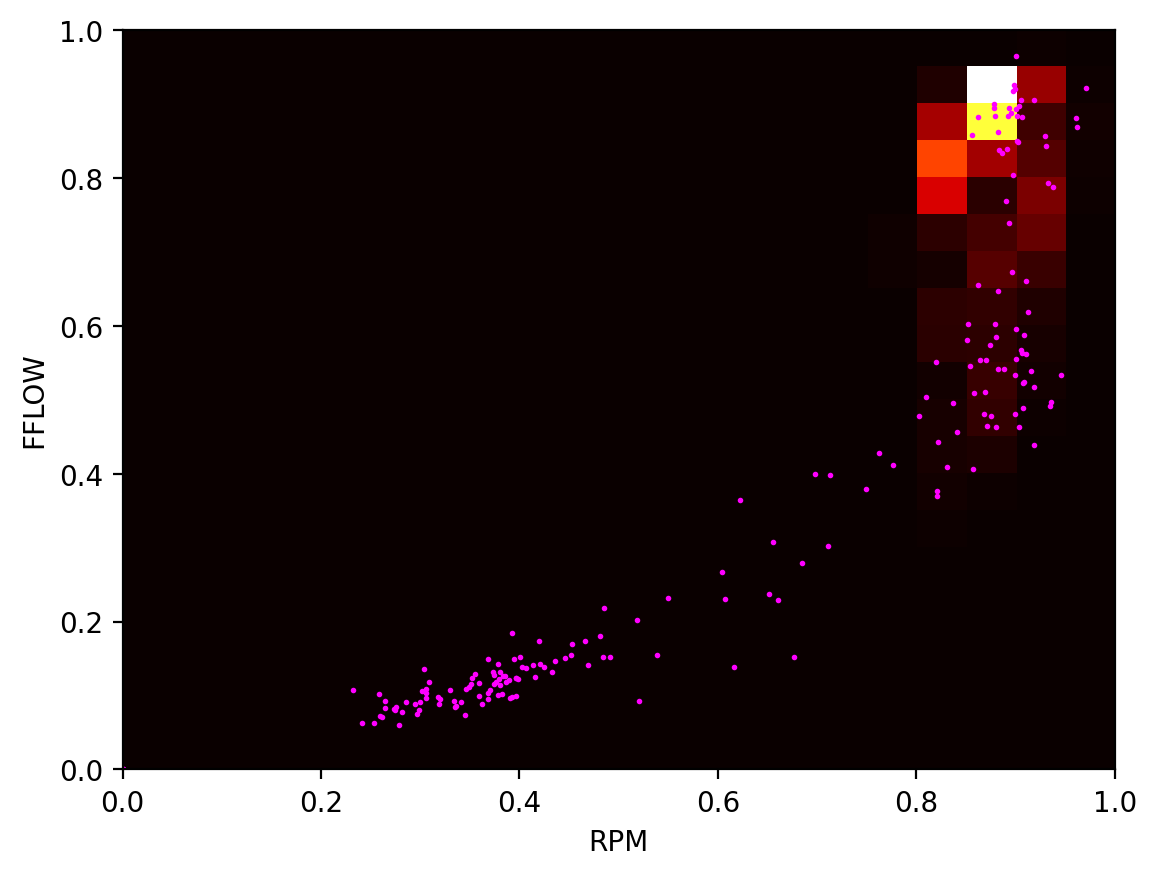

In findNextFunctionAndApply, found function IAS at iteration 5
Required input variables are: ['IASSTAT4', 'IAS4']
Input pmf is ['RPM4', 'ALT4', 'IAS4', 'OILT4', 'FFLOW4', 'OILTSTAT4', 'IASSTAT4']
Output pmf has variables ['RPM4', 'ALT4', 'IAS4', 'OILT4', 'FFLOW4', 'OILTSTAT4', 'IASSTAT4', 'IAS5']
Variables in the input pmf required by the function are [6, 2]
Node IAS4 no longer required. Deleting...
Node FFLOW4 no longer required. Deleting...
Node IASSTAT4 no longer required. Deleting...
Current Nodes: ['OILT4', 'RPM4', 'OILTSTAT4', 'ALT4', 'IAS5']
In findNextFunctionAndApply, found function OILT at iteration 5
Required input variables are: ['OILTSTAT4', 'OILT4']
Input pmf is ['RPM4', 'ALT4', 'OILT4', 'OILTSTAT4', 'IAS5']
Output pmf has variables ['RPM4', 'ALT4', 'OILT4', 'OILTSTAT4', 'IAS5', 'OILT5']
Variables in the input pmf required by the function are [3, 2]
Node OILT4 no longer required. Deleting...
Node OILTSTAT4 no longer required. Deleting...
Current Nodes: ['RPM4', 'ALT4', 'I

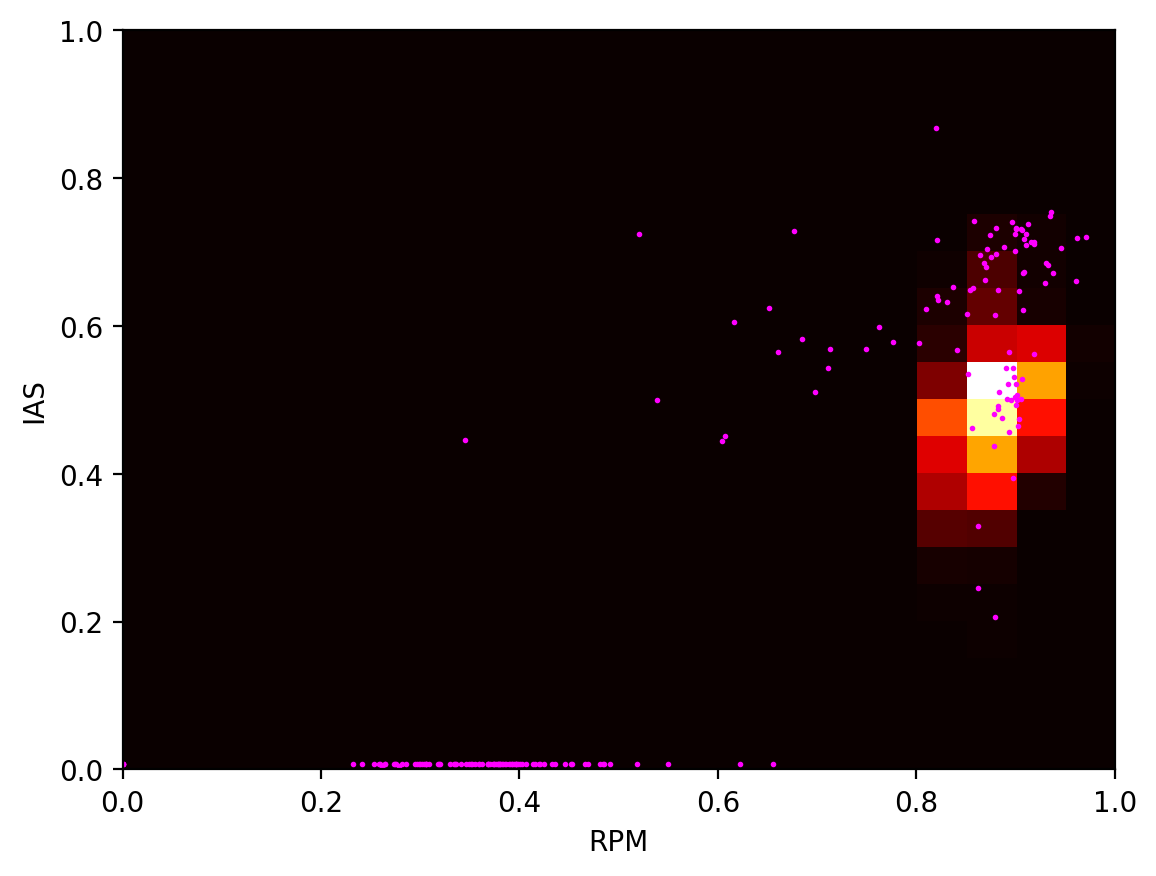

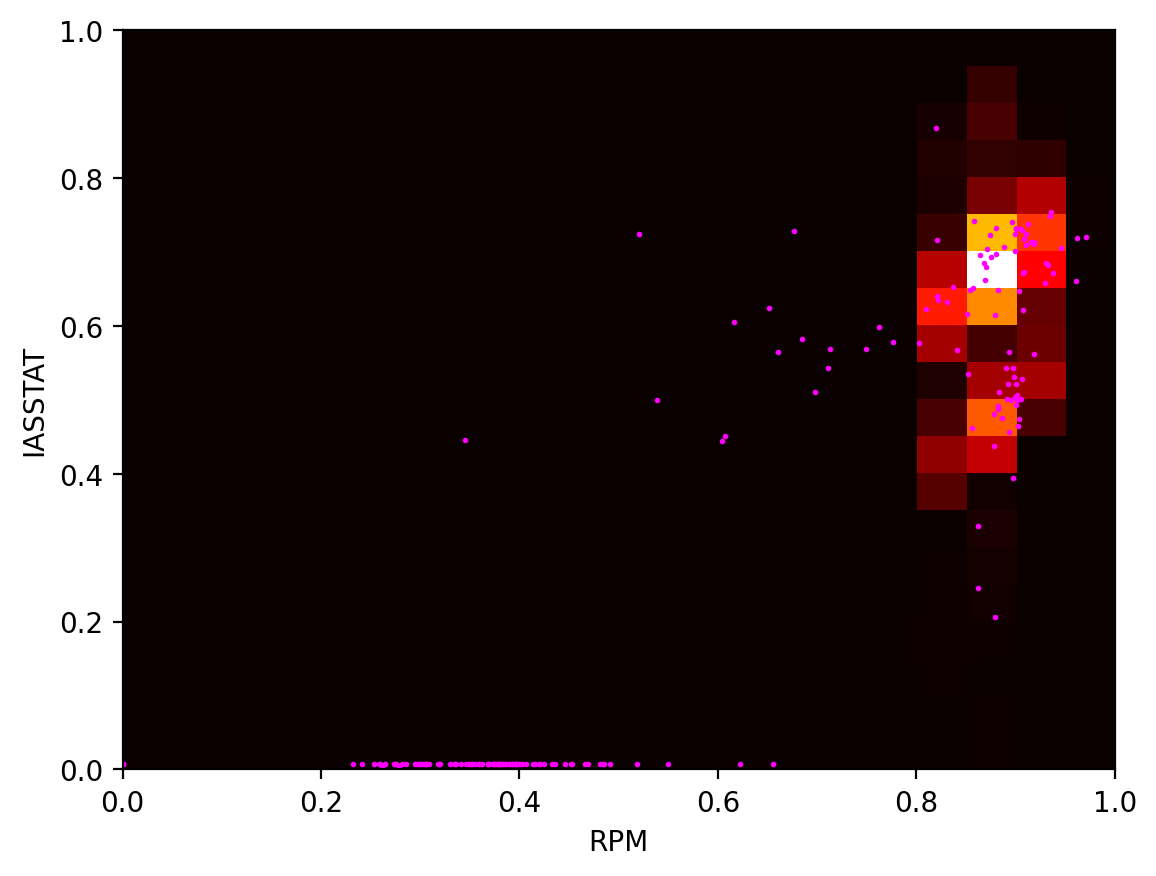

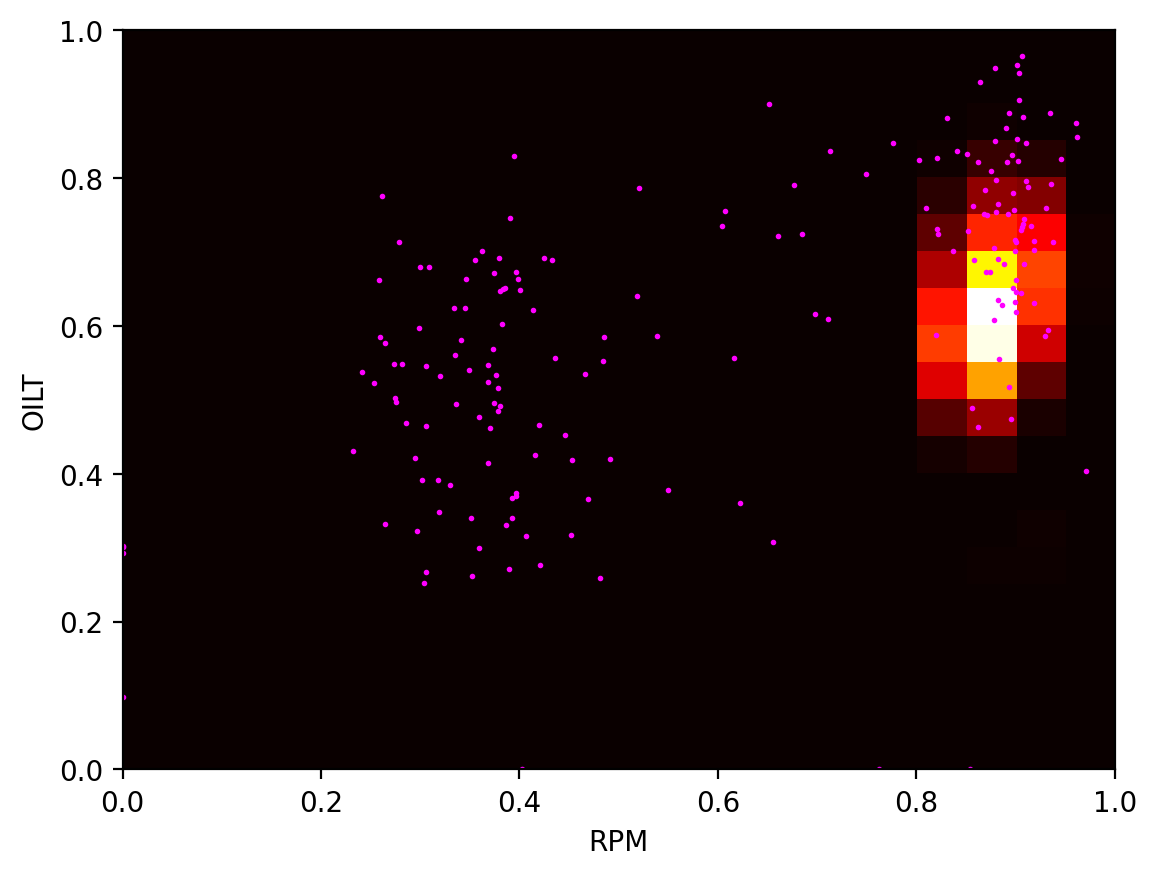

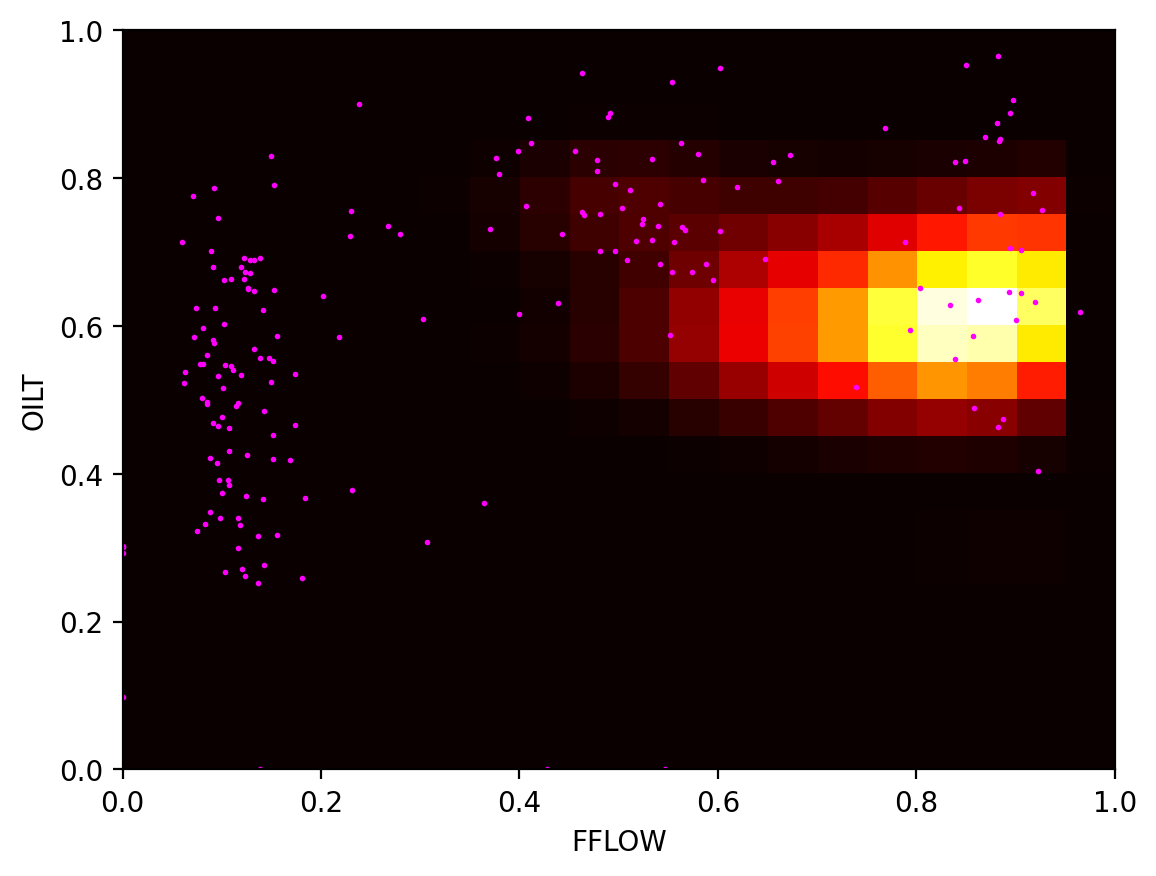

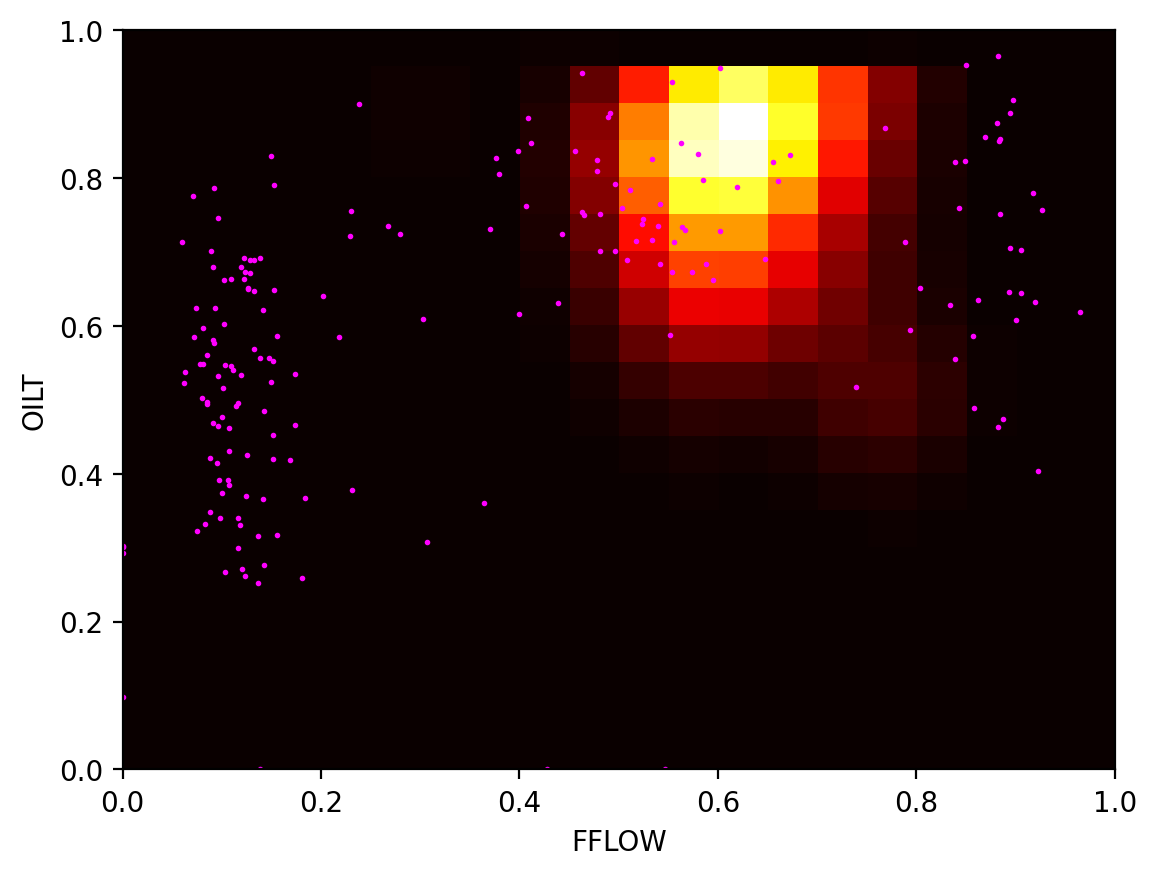

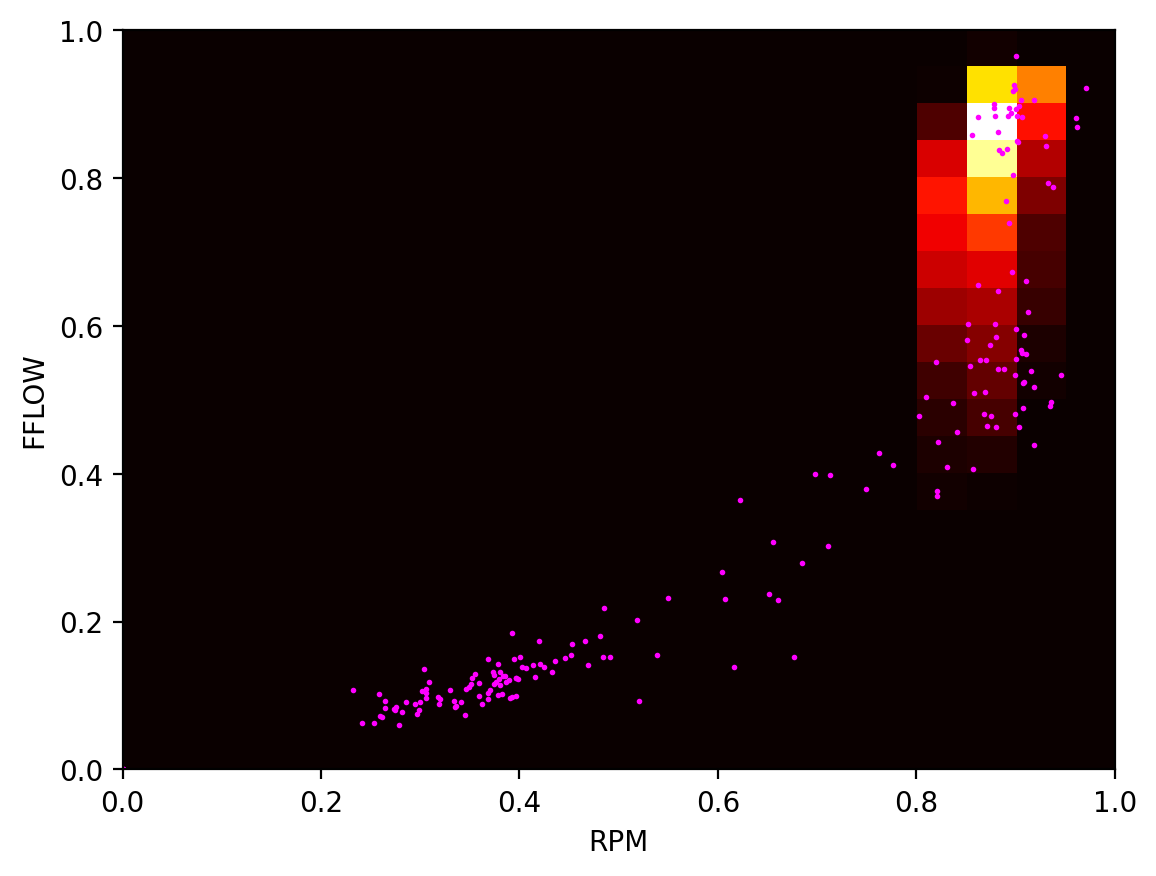

In findNextFunctionAndApply, found function IAS at iteration 6
Required input variables are: ['IASSTAT5', 'IAS5']
Input pmf is ['RPM5', 'ALT5', 'IAS5', 'OILT5', 'FFLOW5', 'OILTSTAT5', 'IASSTAT5']
Output pmf has variables ['RPM5', 'ALT5', 'IAS5', 'OILT5', 'FFLOW5', 'OILTSTAT5', 'IASSTAT5', 'IAS6']
Variables in the input pmf required by the function are [6, 2]
Node IAS5 no longer required. Deleting...
Node FFLOW5 no longer required. Deleting...
Node IASSTAT5 no longer required. Deleting...
Current Nodes: ['OILT5', 'RPM5', 'OILTSTAT5', 'ALT5', 'IAS6']
In findNextFunctionAndApply, found function OILT at iteration 6
Required input variables are: ['OILTSTAT5', 'OILT5']
Input pmf is ['RPM5', 'ALT5', 'OILT5', 'OILTSTAT5', 'IAS6']
Output pmf has variables ['RPM5', 'ALT5', 'OILT5', 'OILTSTAT5', 'IAS6', 'OILT6']
Variables in the input pmf required by the function are [3, 2]
Node OILT5 no longer required. Deleting...
Node OILTSTAT5 no longer required. Deleting...
Current Nodes: ['RPM5', 'ALT5', 'I

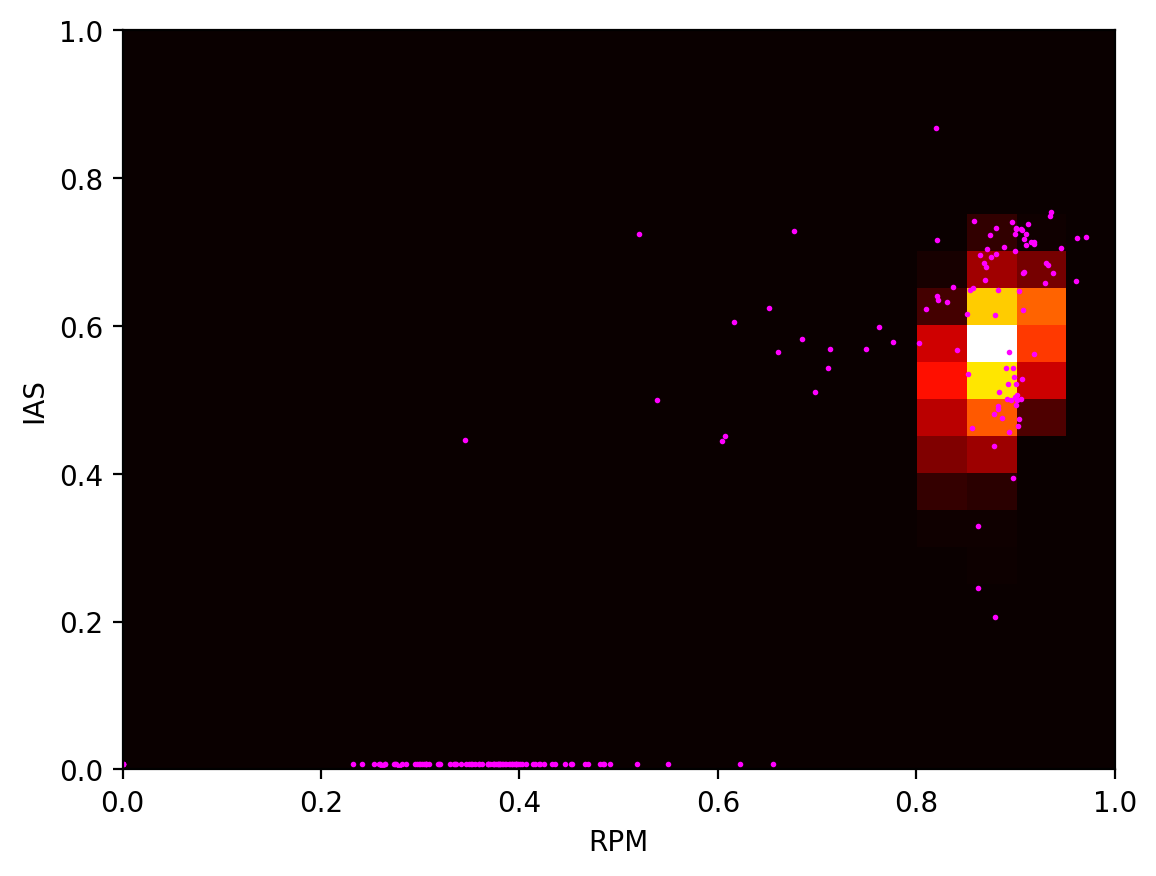

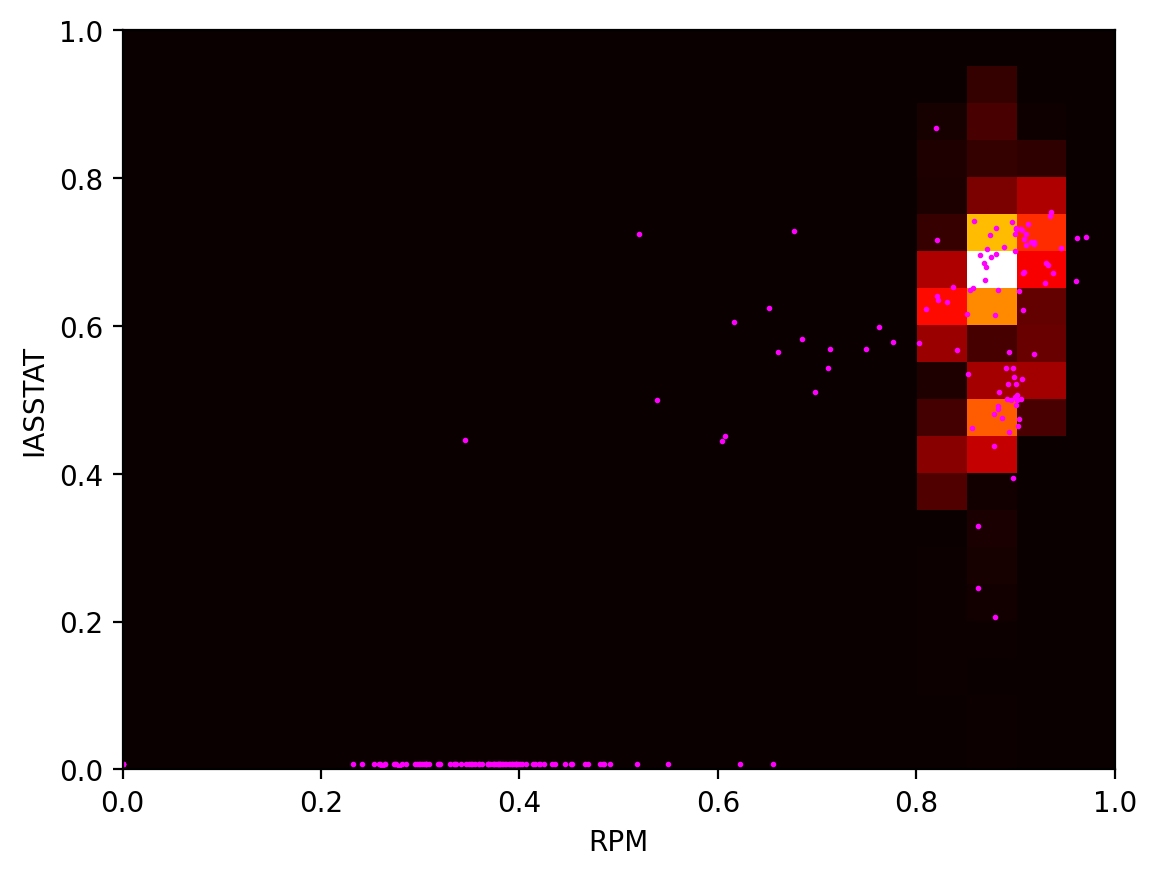

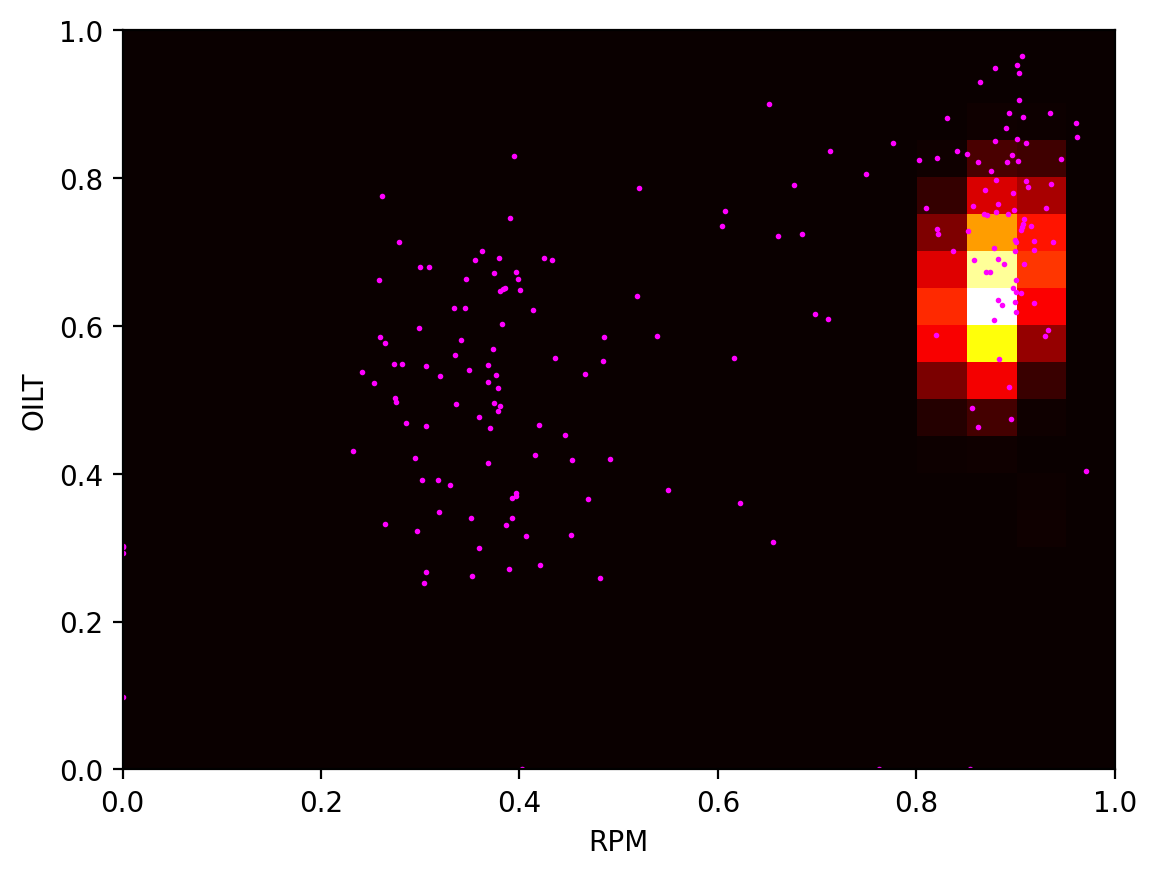

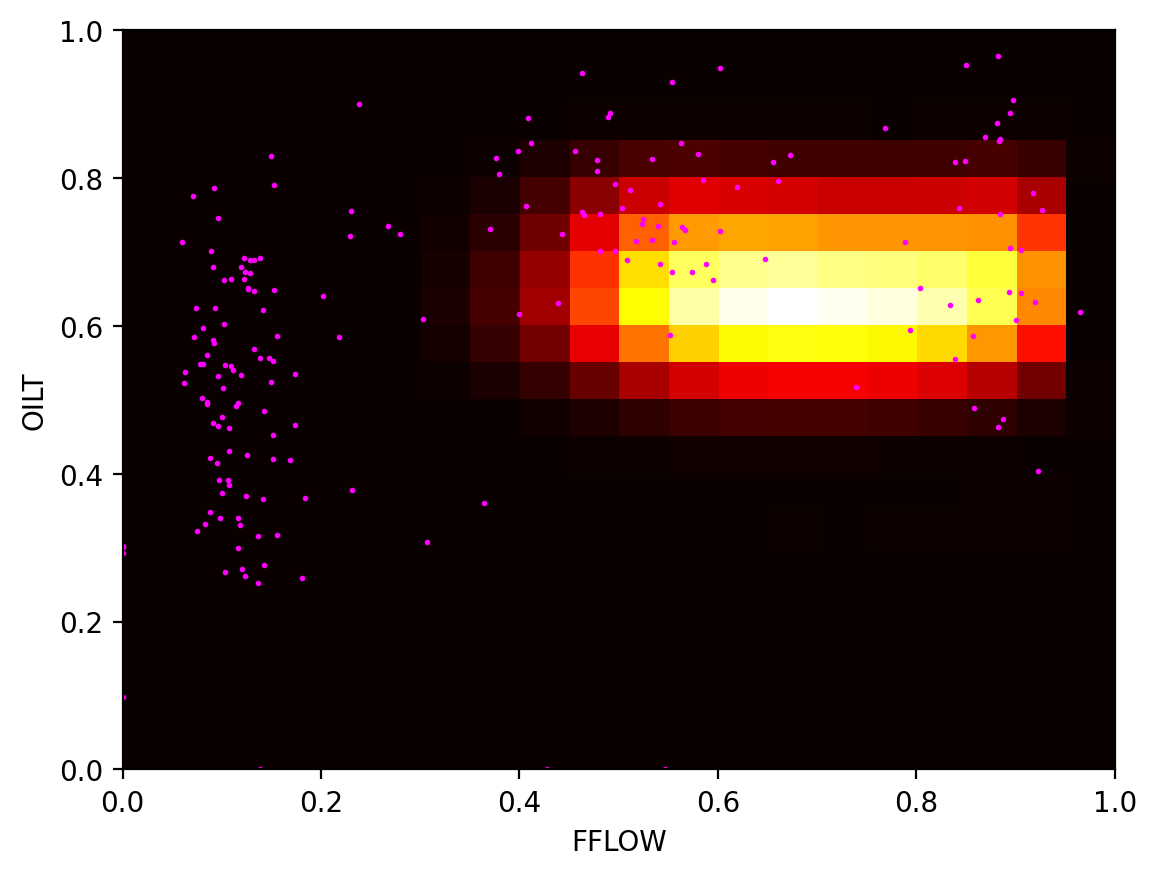

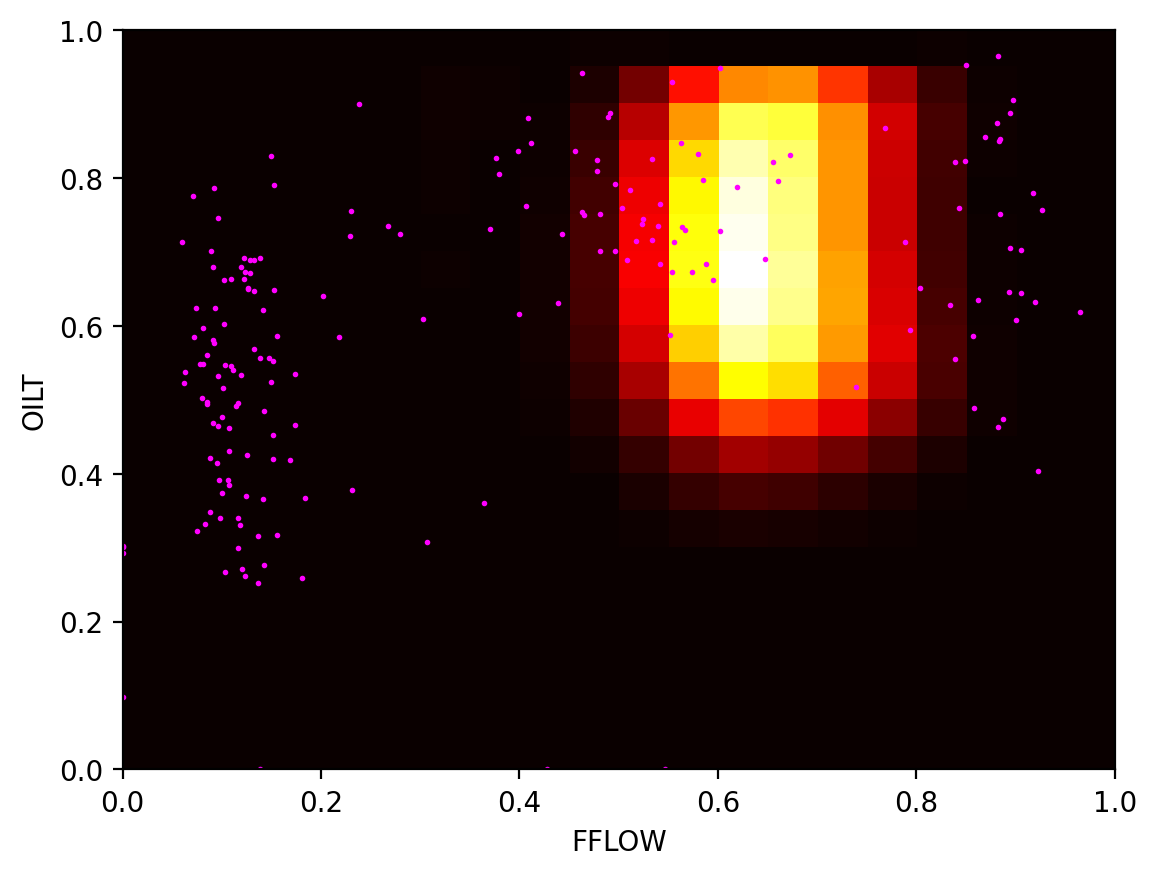

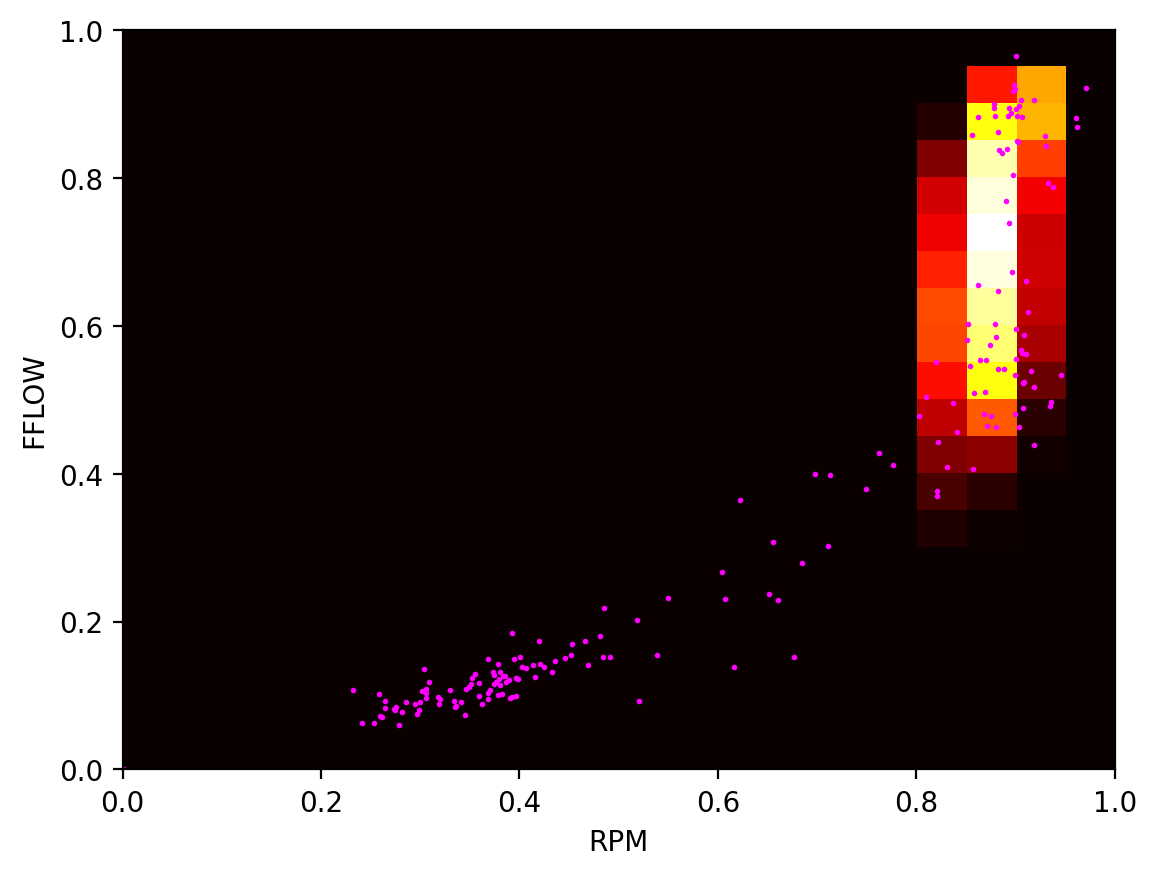

In findNextFunctionAndApply, found function IAS at iteration 7
Required input variables are: ['IASSTAT6', 'IAS6']
Input pmf is ['RPM6', 'ALT6', 'IAS6', 'OILT6', 'FFLOW6', 'OILTSTAT6', 'IASSTAT6']
Output pmf has variables ['RPM6', 'ALT6', 'IAS6', 'OILT6', 'FFLOW6', 'OILTSTAT6', 'IASSTAT6', 'IAS7']
Variables in the input pmf required by the function are [6, 2]
Node IAS6 no longer required. Deleting...
Node FFLOW6 no longer required. Deleting...
Node IASSTAT6 no longer required. Deleting...
Current Nodes: ['OILT6', 'RPM6', 'OILTSTAT6', 'ALT6', 'IAS7']
In findNextFunctionAndApply, found function OILT at iteration 7
Required input variables are: ['OILTSTAT6', 'OILT6']
Input pmf is ['RPM6', 'ALT6', 'OILT6', 'OILTSTAT6', 'IAS7']
Output pmf has variables ['RPM6', 'ALT6', 'OILT6', 'OILTSTAT6', 'IAS7', 'OILT7']
Variables in the input pmf required by the function are [3, 2]
Node OILT6 no longer required. Deleting...
Node OILTSTAT6 no longer required. Deleting...
Current Nodes: ['RPM6', 'ALT6', 'I

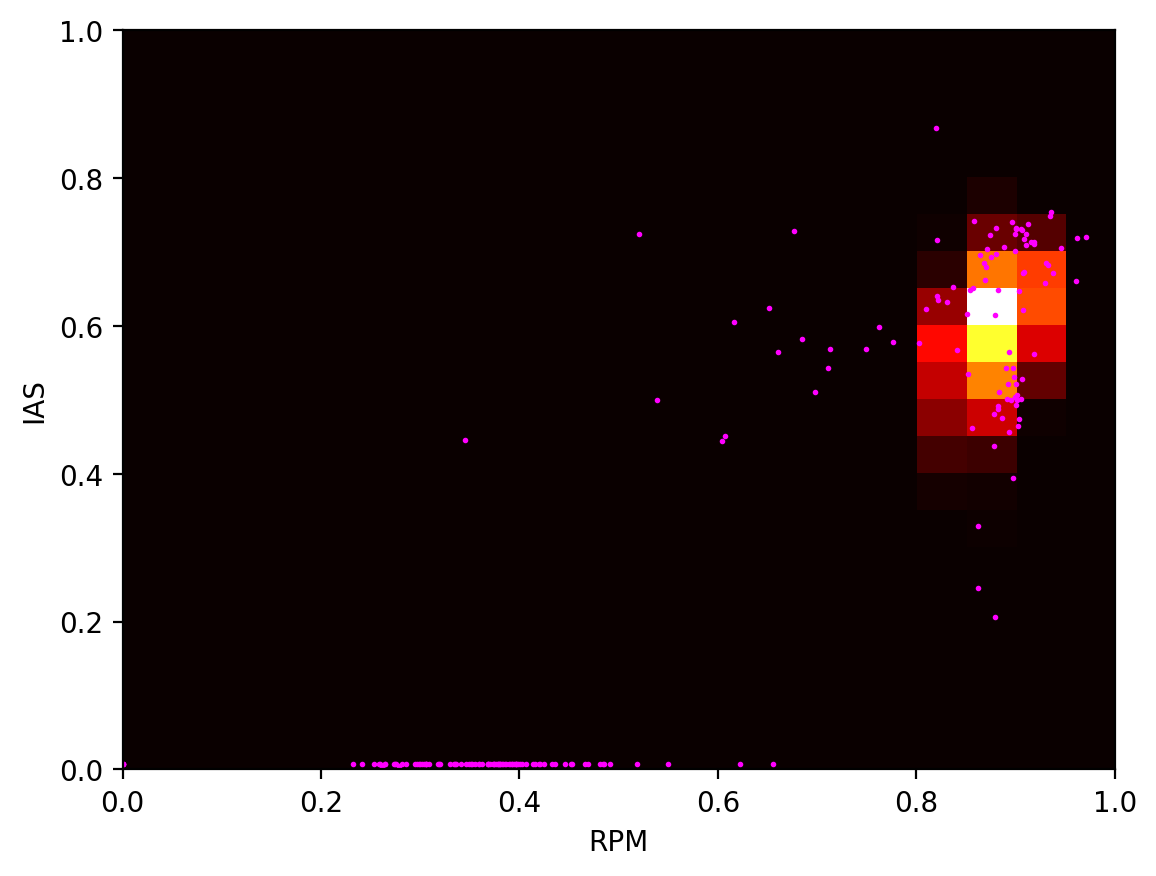

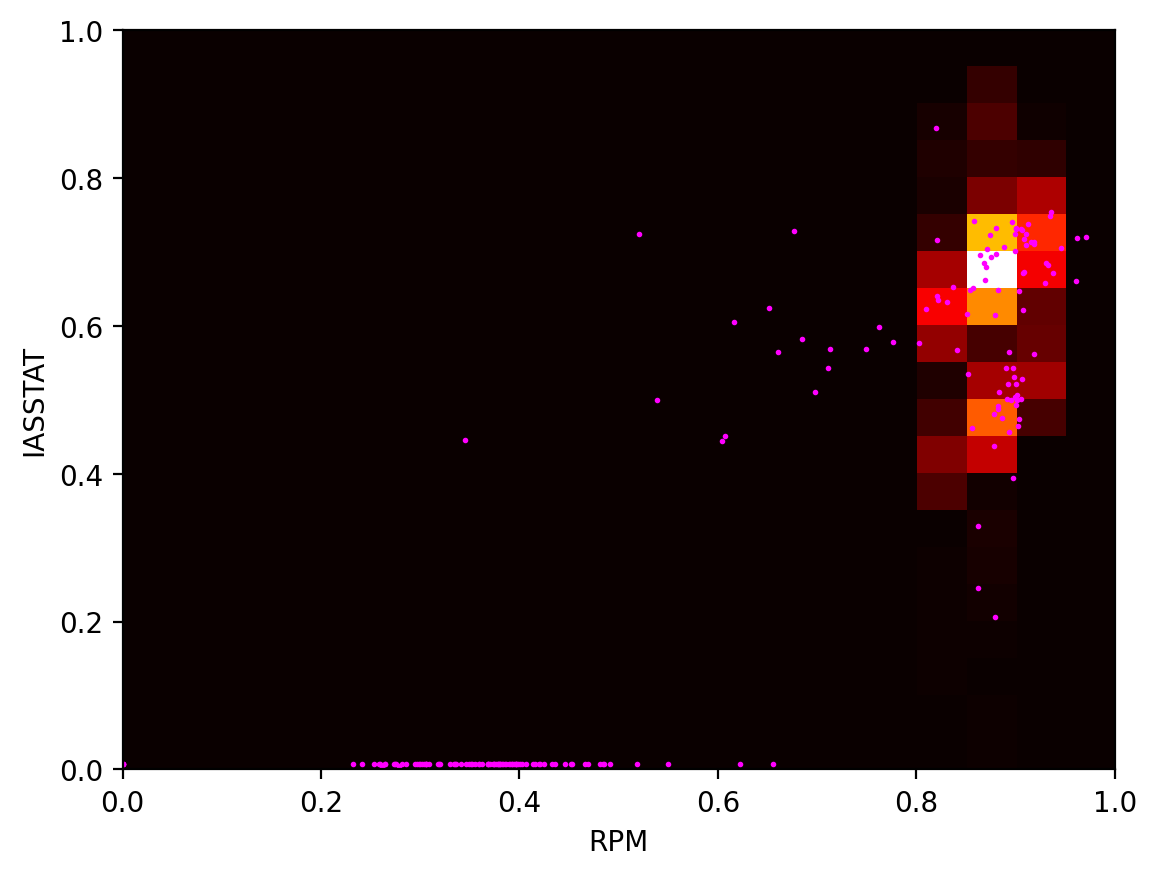

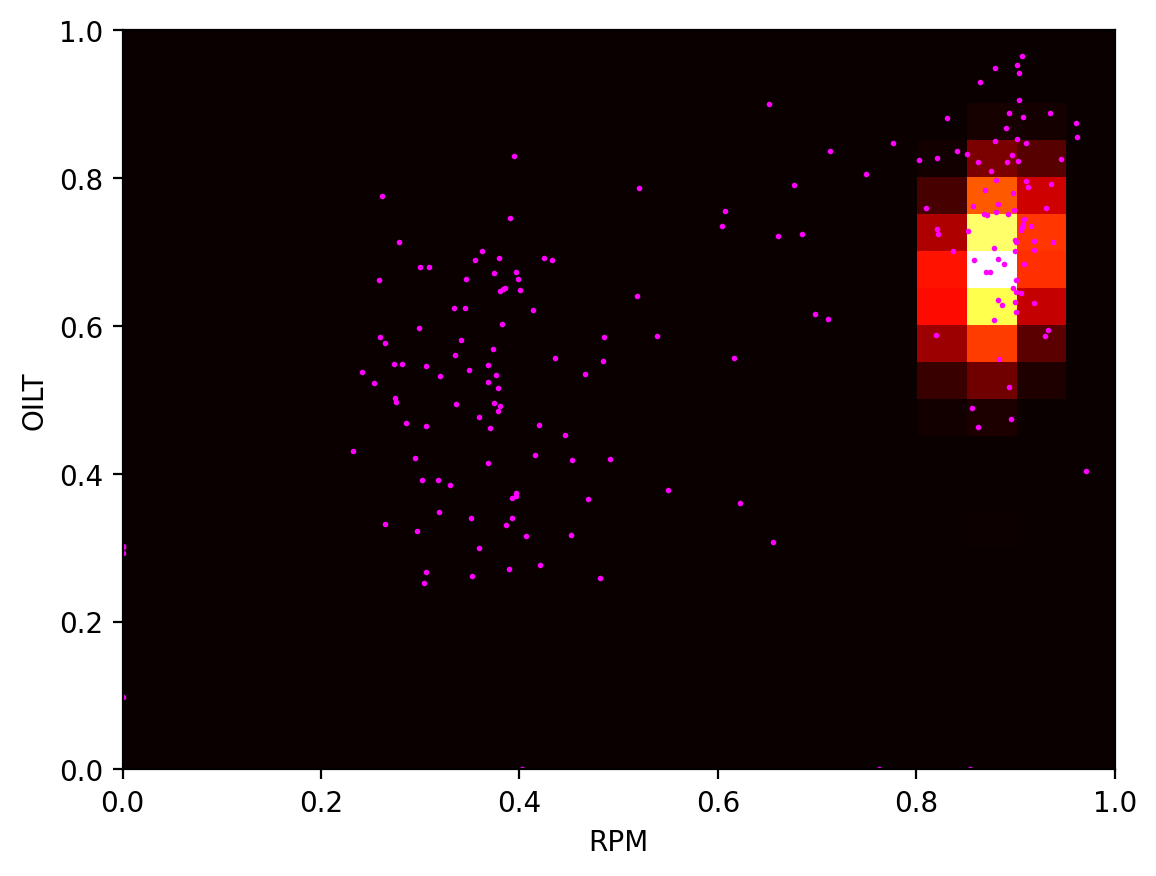

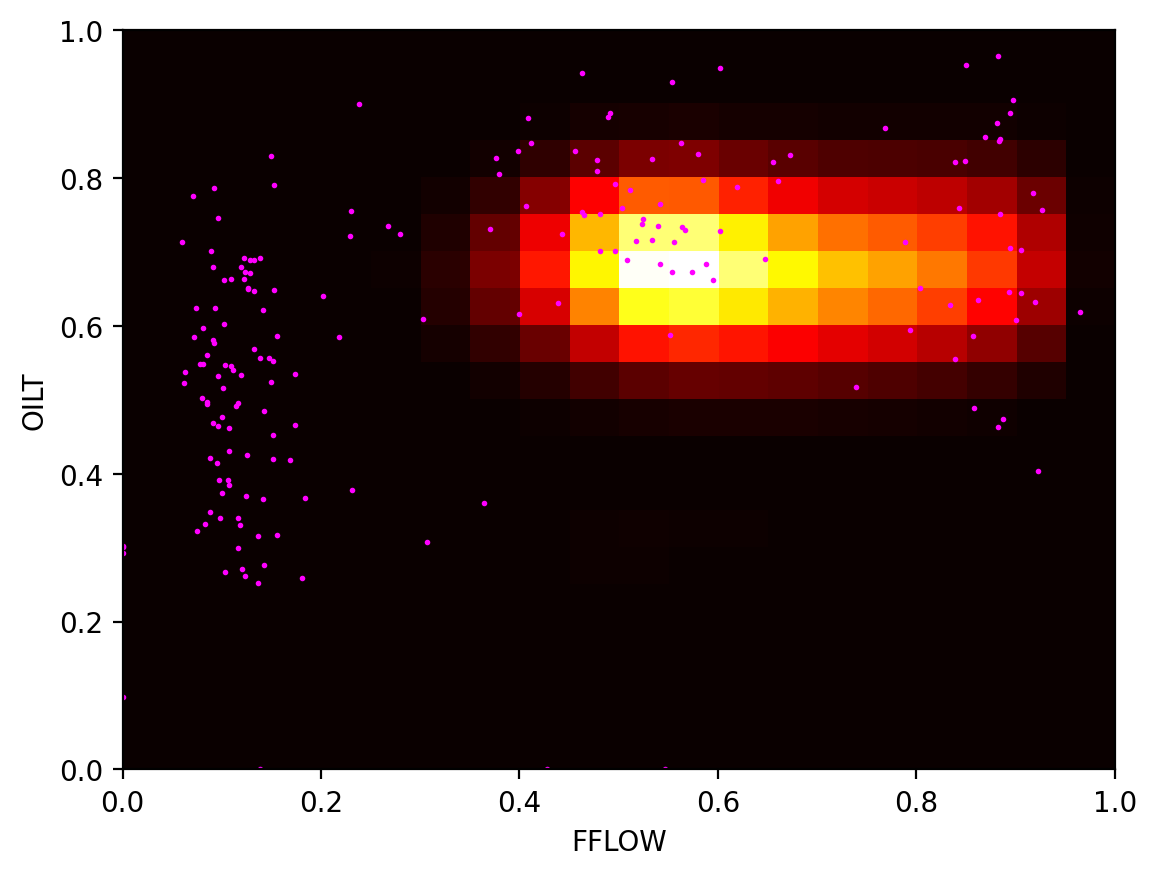

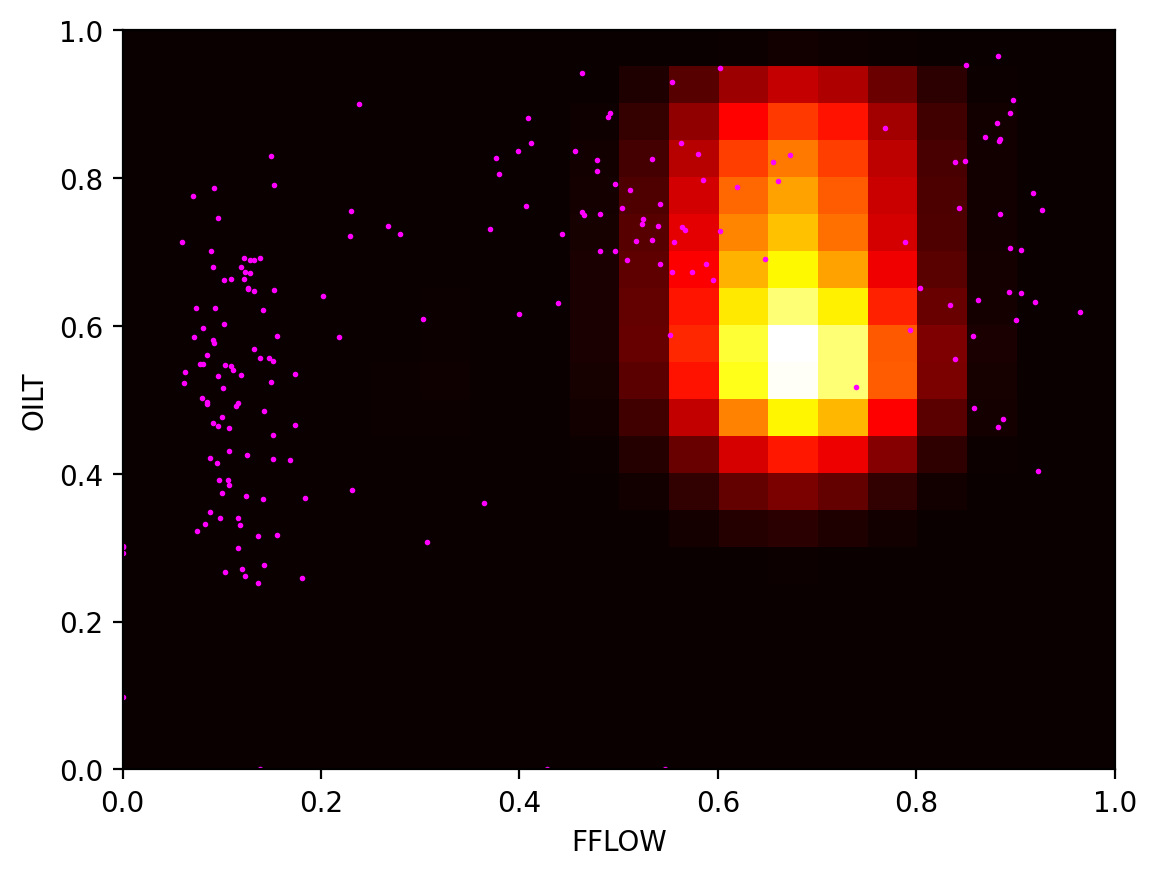

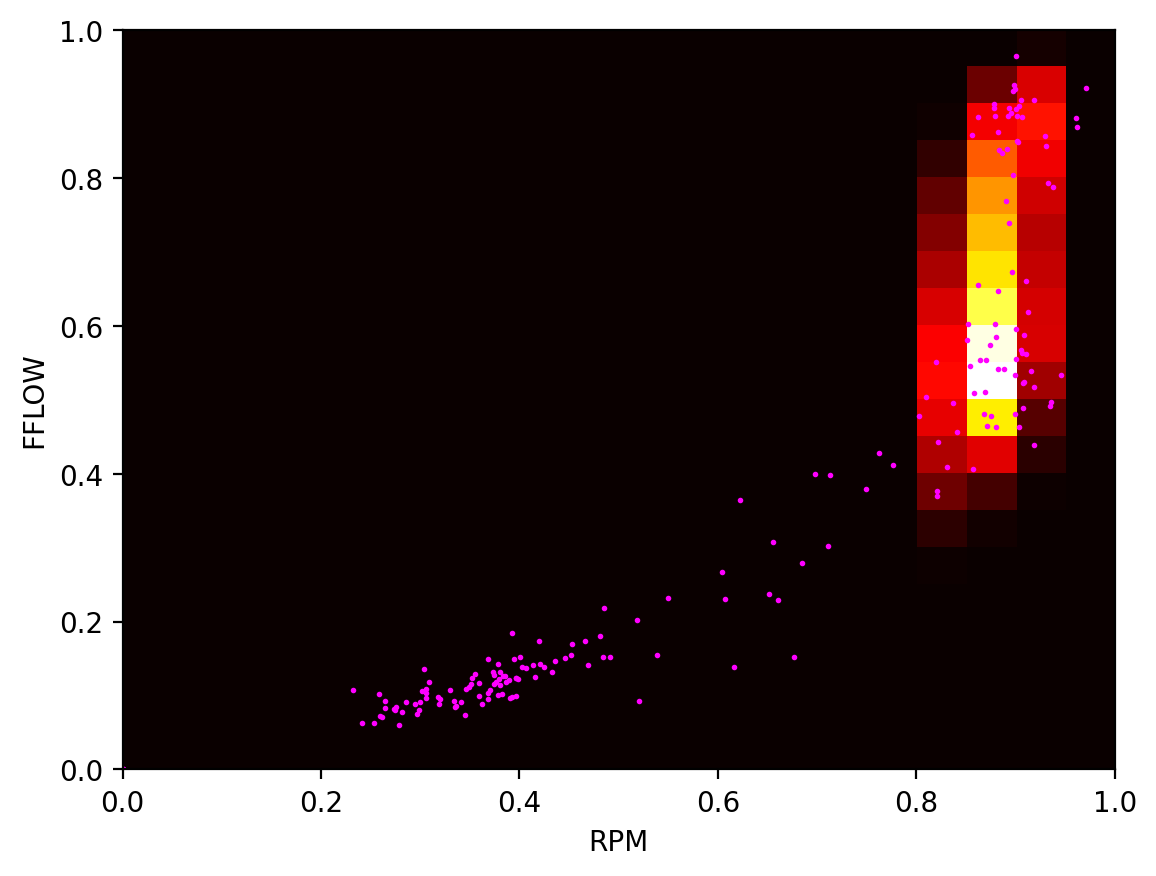

In findNextFunctionAndApply, found function IAS at iteration 8
Required input variables are: ['IASSTAT7', 'IAS7']
Input pmf is ['RPM7', 'ALT7', 'IAS7', 'OILT7', 'FFLOW7', 'OILTSTAT7', 'IASSTAT7']
Output pmf has variables ['RPM7', 'ALT7', 'IAS7', 'OILT7', 'FFLOW7', 'OILTSTAT7', 'IASSTAT7', 'IAS8']
Variables in the input pmf required by the function are [6, 2]
Node IAS7 no longer required. Deleting...
Node FFLOW7 no longer required. Deleting...
Node IASSTAT7 no longer required. Deleting...
Current Nodes: ['OILT7', 'RPM7', 'OILTSTAT7', 'ALT7', 'IAS8']
In findNextFunctionAndApply, found function OILT at iteration 8
Required input variables are: ['OILTSTAT7', 'OILT7']
Input pmf is ['RPM7', 'ALT7', 'OILT7', 'OILTSTAT7', 'IAS8']
Output pmf has variables ['RPM7', 'ALT7', 'OILT7', 'OILTSTAT7', 'IAS8', 'OILT8']
Variables in the input pmf required by the function are [3, 2]
Node OILT7 no longer required. Deleting...
Node OILTSTAT7 no longer required. Deleting...
Current Nodes: ['RPM7', 'ALT7', 'I

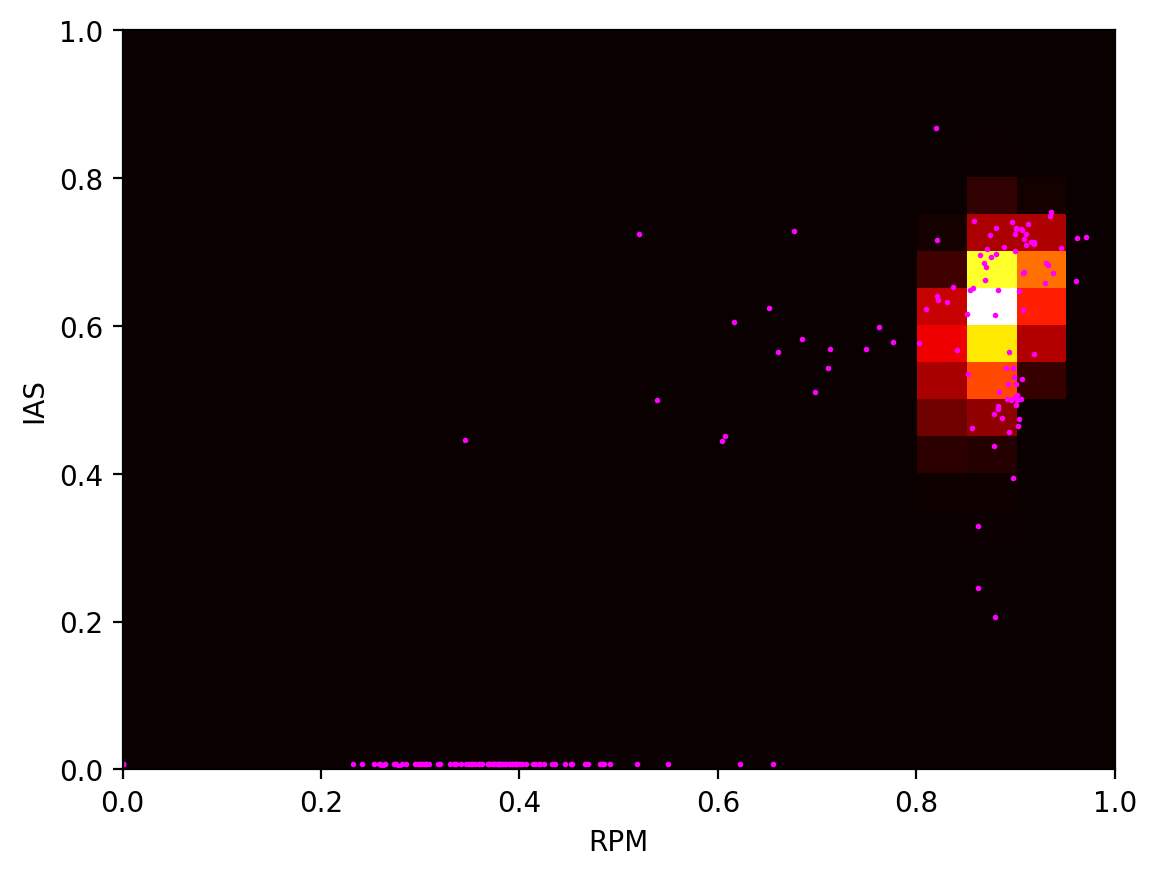

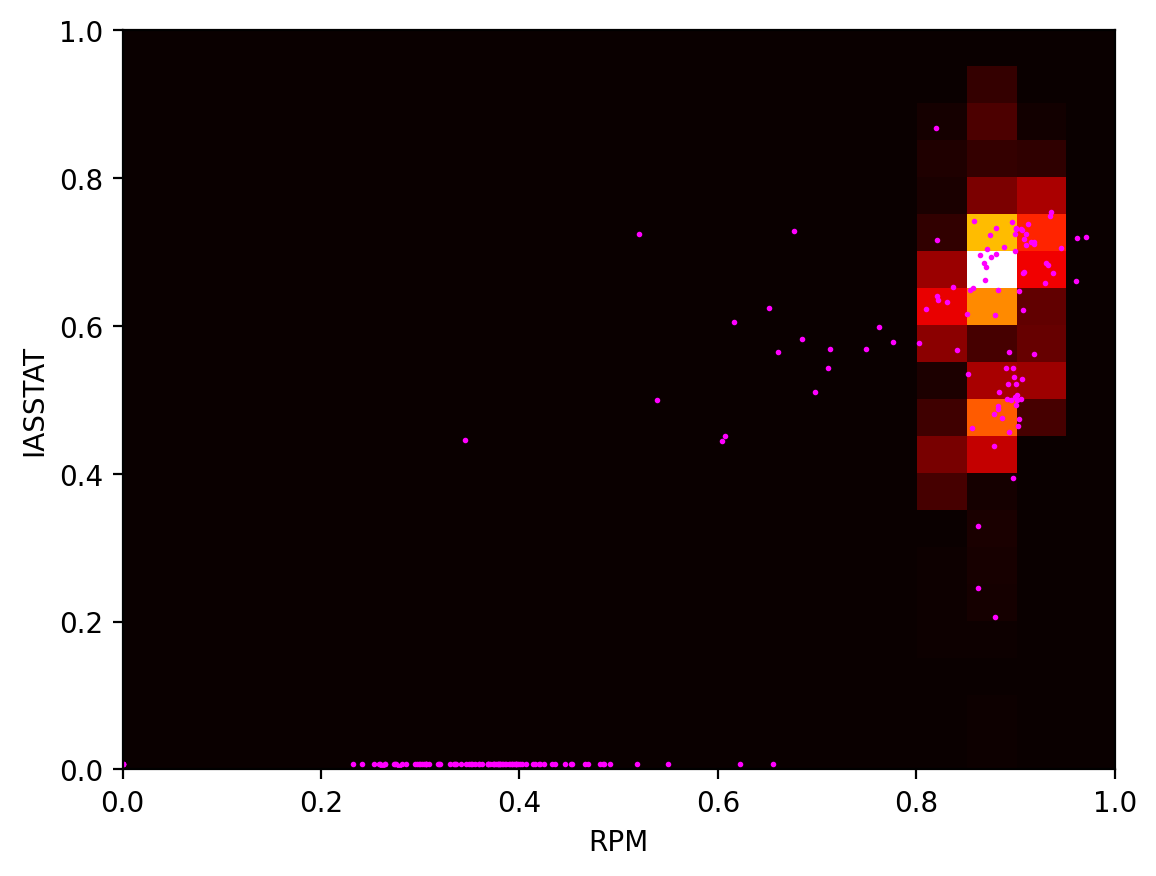

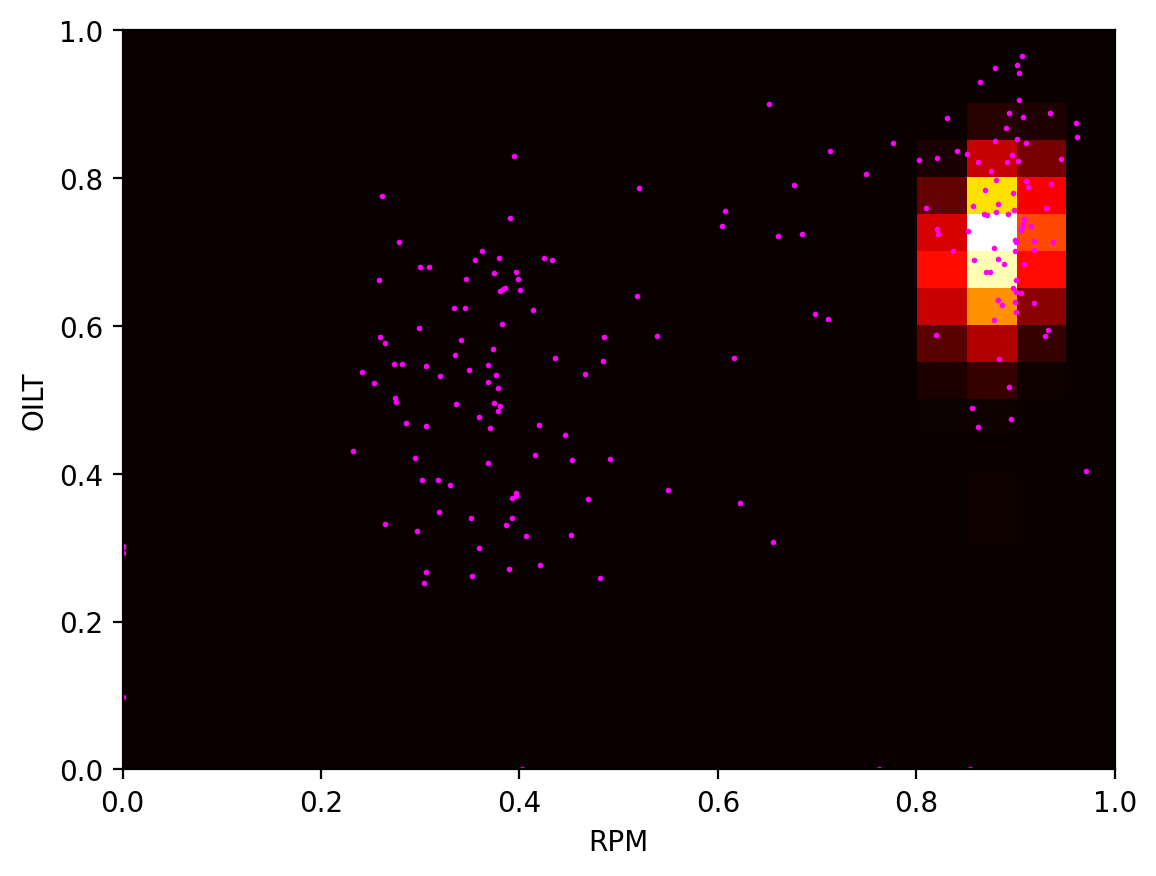

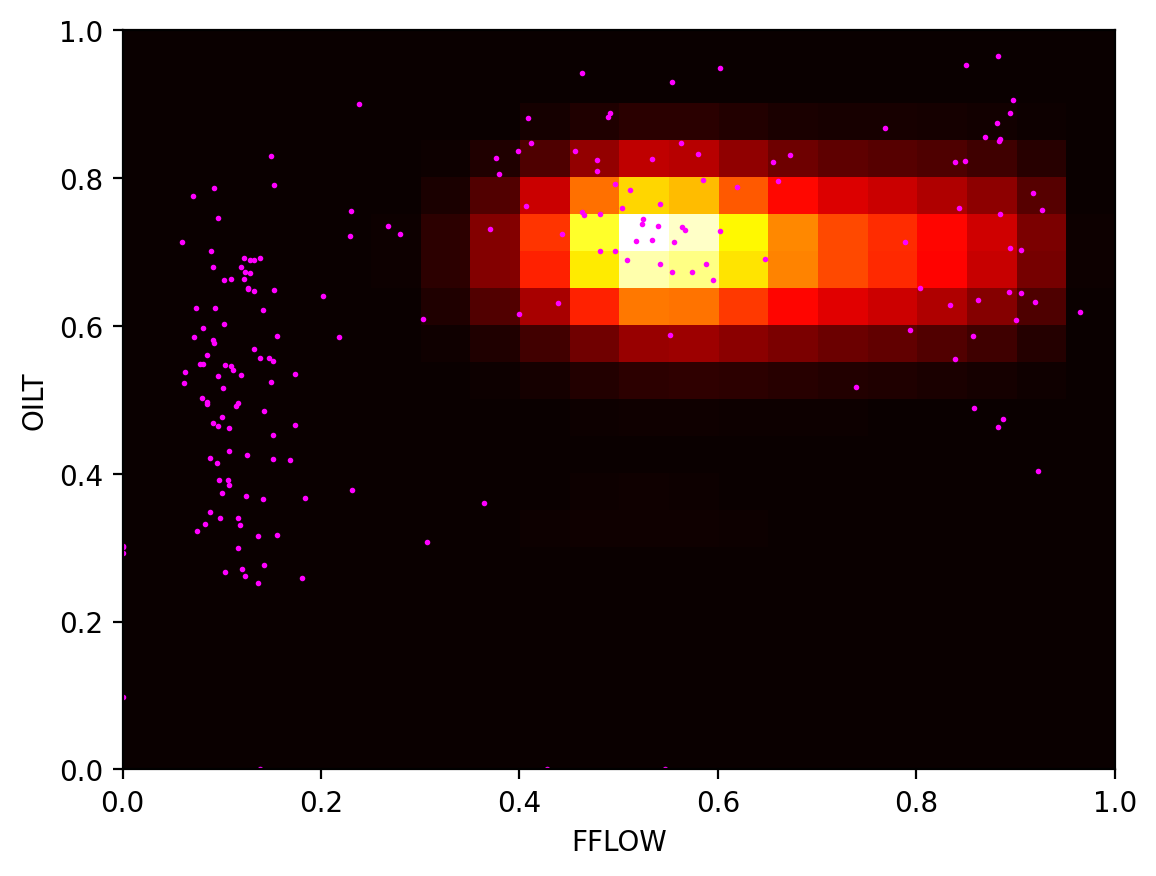

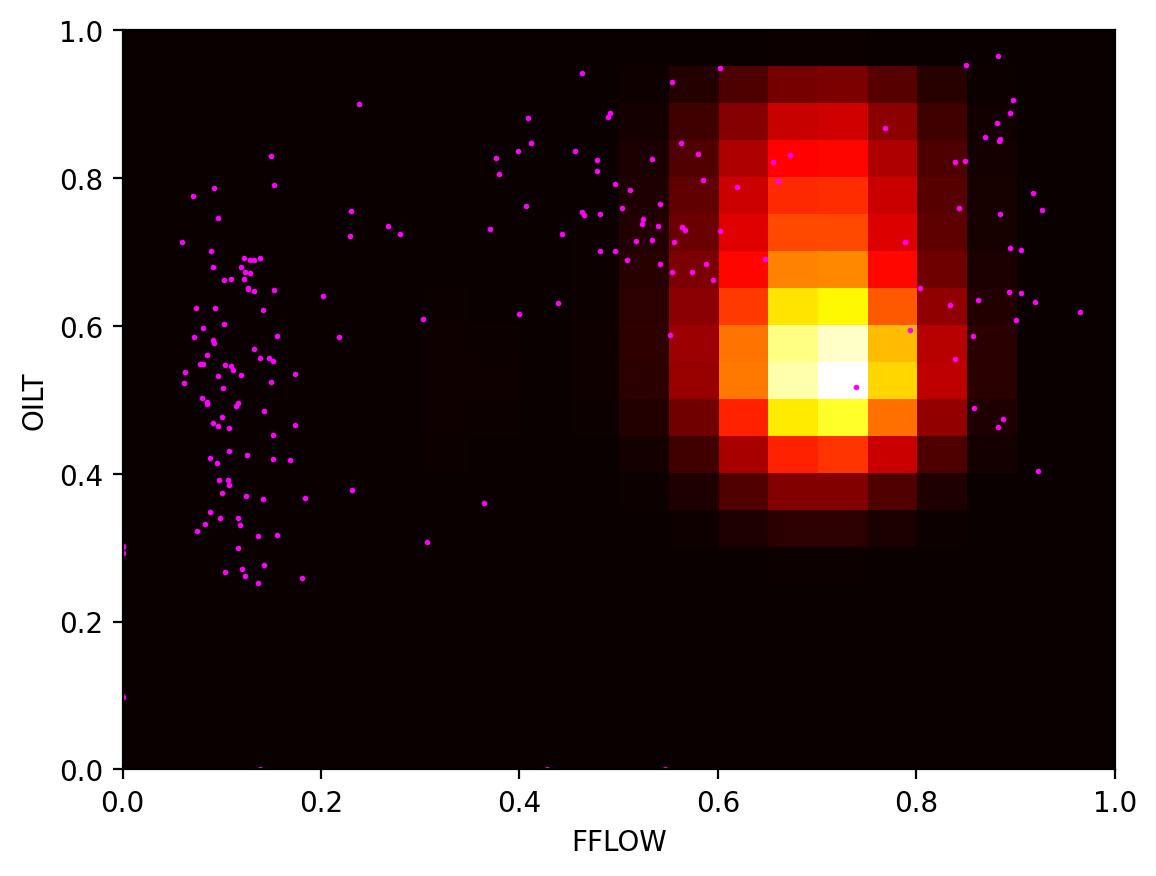

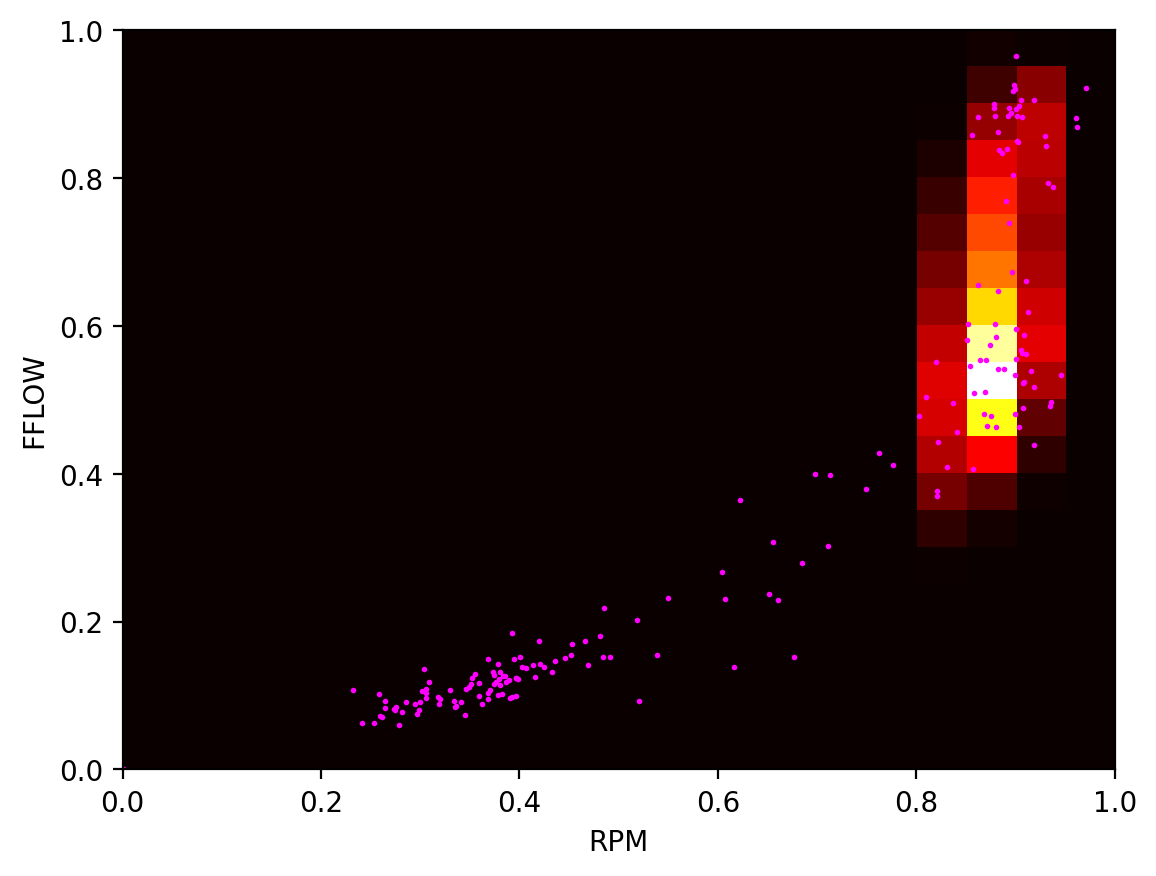

In findNextFunctionAndApply, found function IAS at iteration 9
Required input variables are: ['IASSTAT8', 'IAS8']
Input pmf is ['RPM8', 'ALT8', 'IAS8', 'OILT8', 'FFLOW8', 'OILTSTAT8', 'IASSTAT8']
Output pmf has variables ['RPM8', 'ALT8', 'IAS8', 'OILT8', 'FFLOW8', 'OILTSTAT8', 'IASSTAT8', 'IAS9']
Variables in the input pmf required by the function are [6, 2]
Node IAS8 no longer required. Deleting...
Node FFLOW8 no longer required. Deleting...
Node IASSTAT8 no longer required. Deleting...
Current Nodes: ['OILT8', 'RPM8', 'OILTSTAT8', 'ALT8', 'IAS9']
In findNextFunctionAndApply, found function OILT at iteration 9
Required input variables are: ['OILTSTAT8', 'OILT8']
Input pmf is ['RPM8', 'ALT8', 'OILT8', 'OILTSTAT8', 'IAS9']
Output pmf has variables ['RPM8', 'ALT8', 'OILT8', 'OILTSTAT8', 'IAS9', 'OILT9']
Variables in the input pmf required by the function are [3, 2]
Node OILT8 no longer required. Deleting...
Node OILTSTAT8 no longer required. Deleting...
Current Nodes: ['RPM8', 'ALT8', 'I

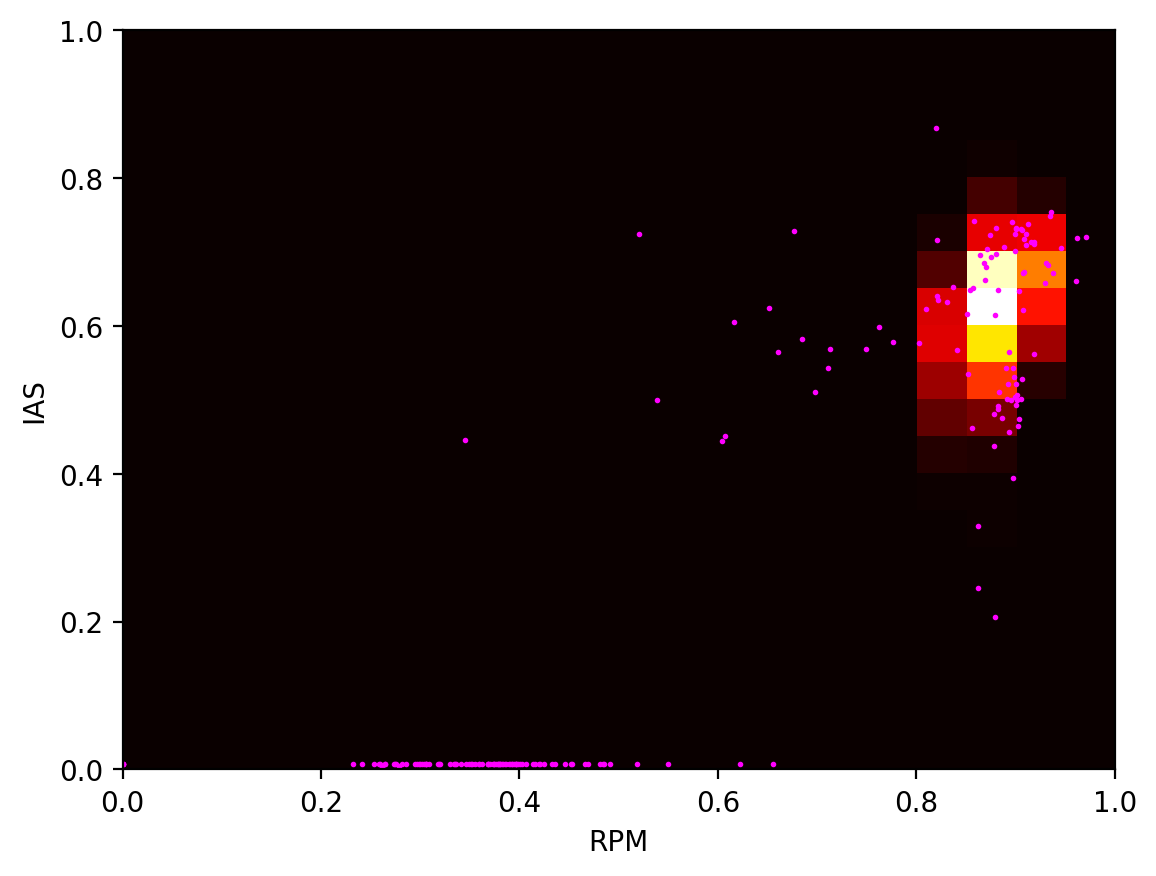

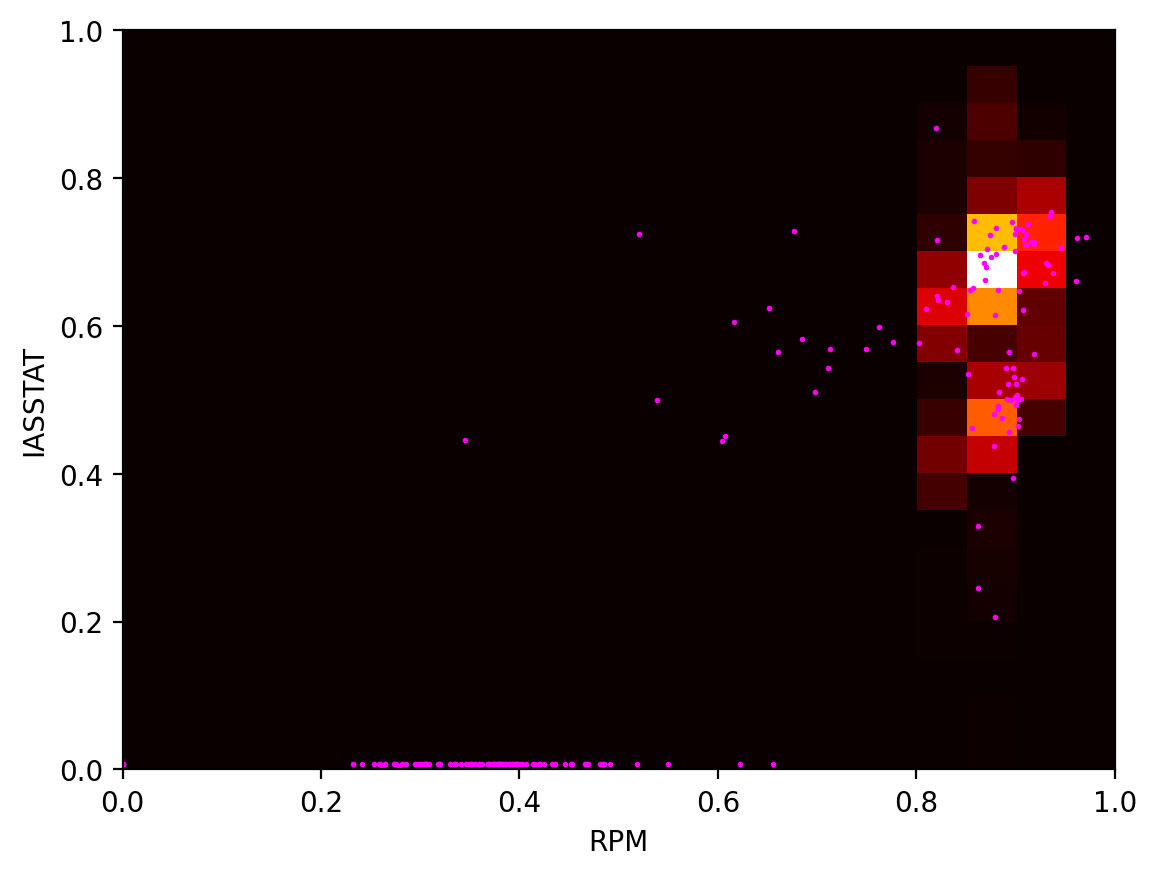

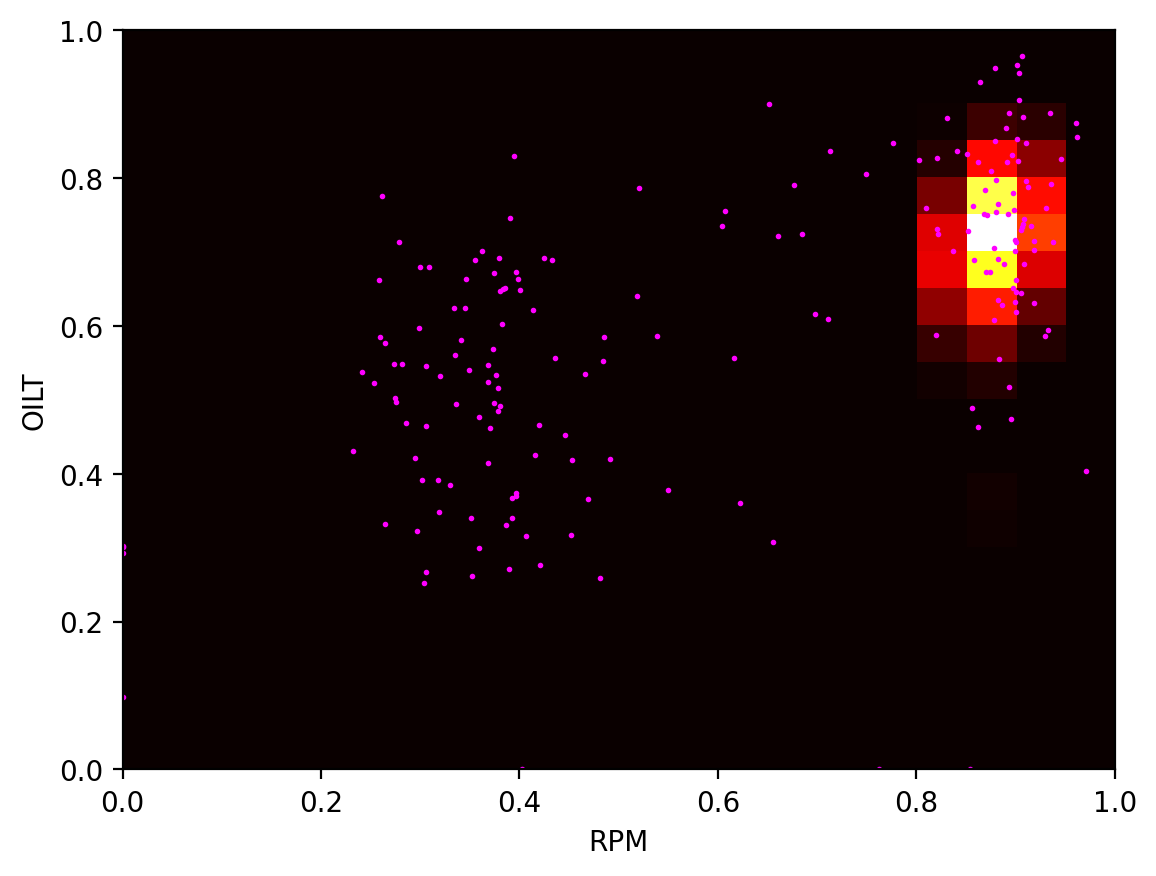

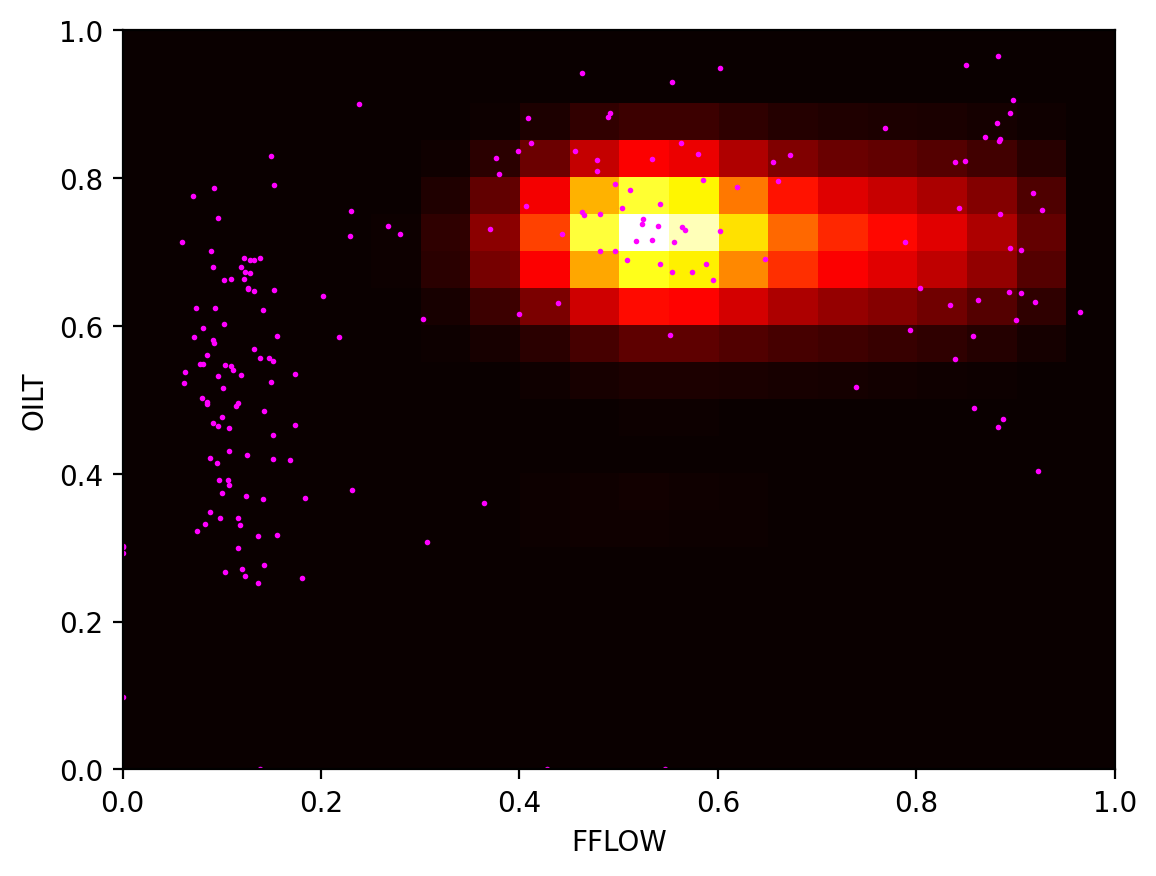

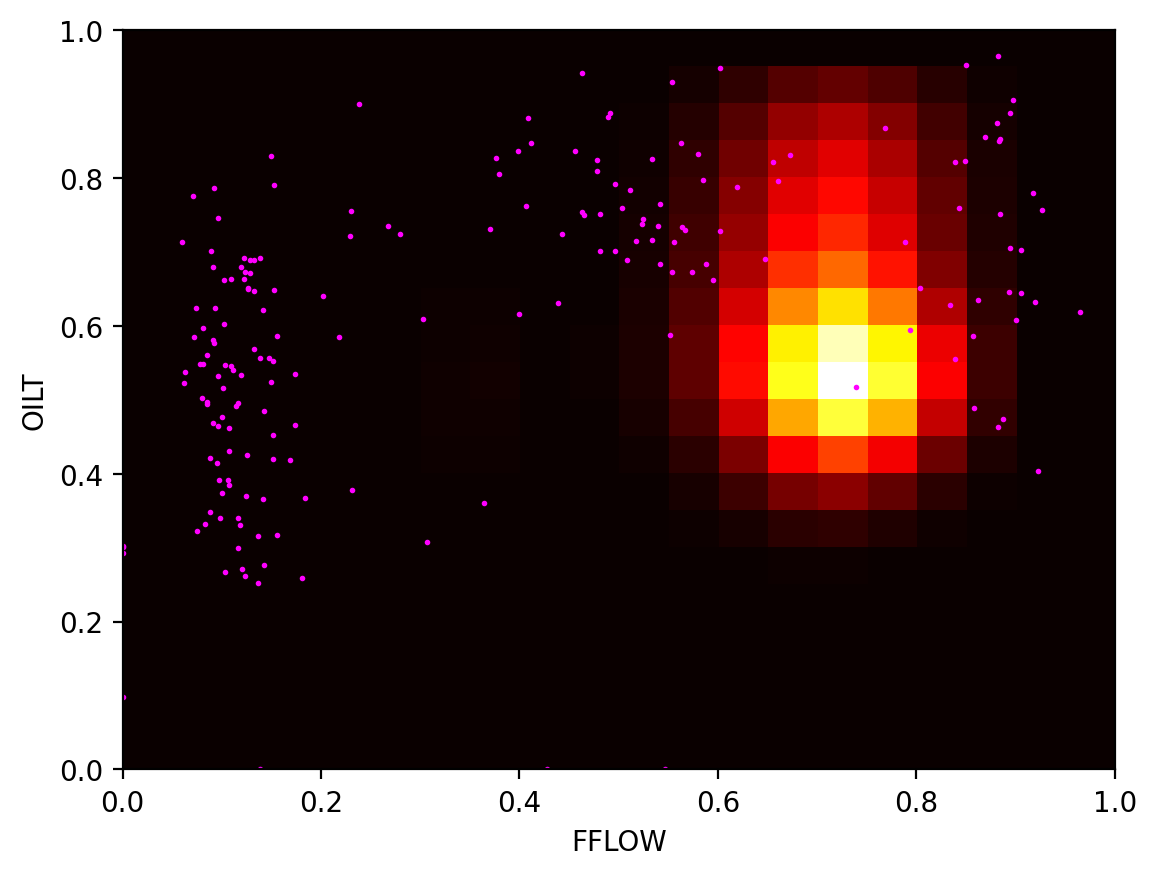

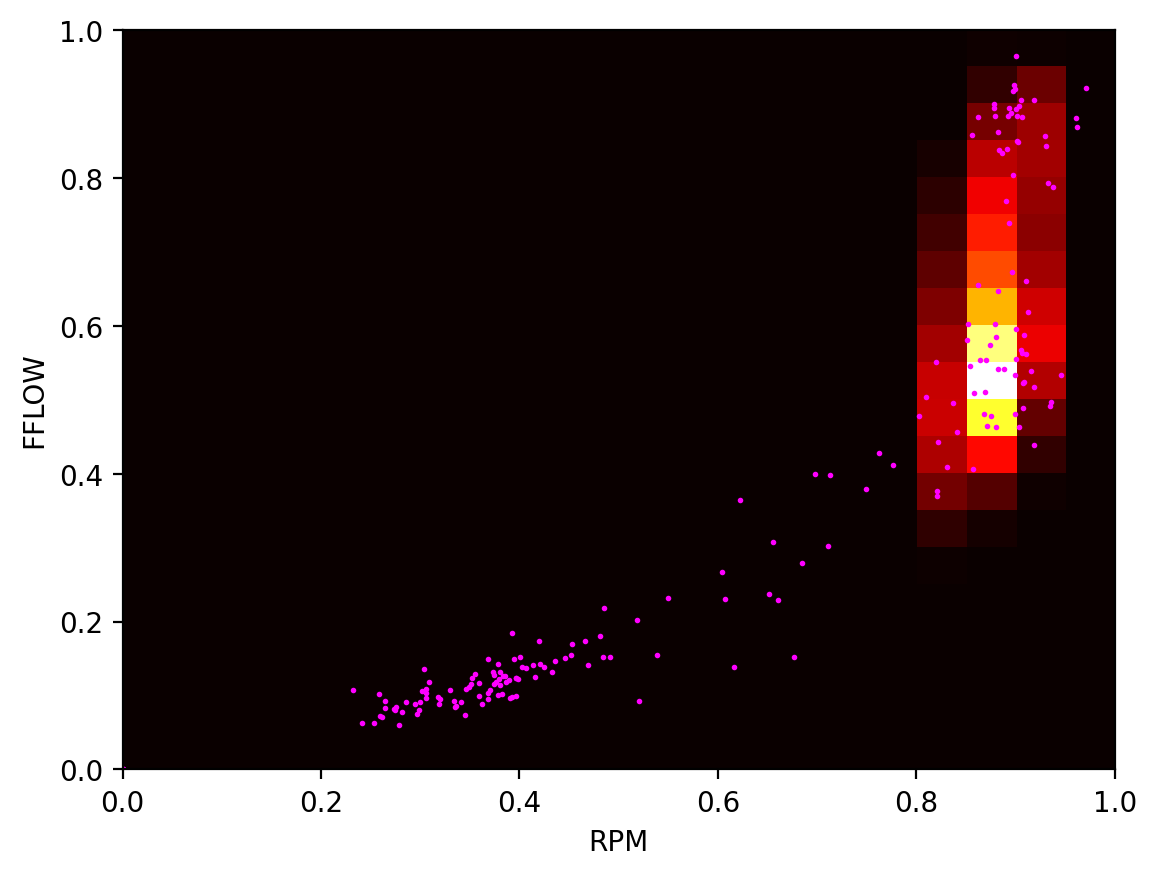

In findNextFunctionAndApply, found function IAS at iteration 10
Required input variables are: ['IASSTAT9', 'IAS9']
Input pmf is ['RPM9', 'ALT9', 'IAS9', 'OILT9', 'FFLOW9', 'OILTSTAT9', 'IASSTAT9']
Output pmf has variables ['RPM9', 'ALT9', 'IAS9', 'OILT9', 'FFLOW9', 'OILTSTAT9', 'IASSTAT9', 'IAS10']
Variables in the input pmf required by the function are [6, 2]
Node IAS9 no longer required. Deleting...
Node FFLOW9 no longer required. Deleting...
Node IASSTAT9 no longer required. Deleting...
Current Nodes: ['OILT9', 'RPM9', 'OILTSTAT9', 'ALT9', 'IAS10']
In findNextFunctionAndApply, found function OILT at iteration 10
Required input variables are: ['OILTSTAT9', 'OILT9']
Input pmf is ['RPM9', 'ALT9', 'OILT9', 'OILTSTAT9', 'IAS10']
Output pmf has variables ['RPM9', 'ALT9', 'OILT9', 'OILTSTAT9', 'IAS10', 'OILT10']
Variables in the input pmf required by the function are [3, 2]
Node OILT9 no longer required. Deleting...
Node OILTSTAT9 no longer required. Deleting...
Current Nodes: ['RPM9', 'AL

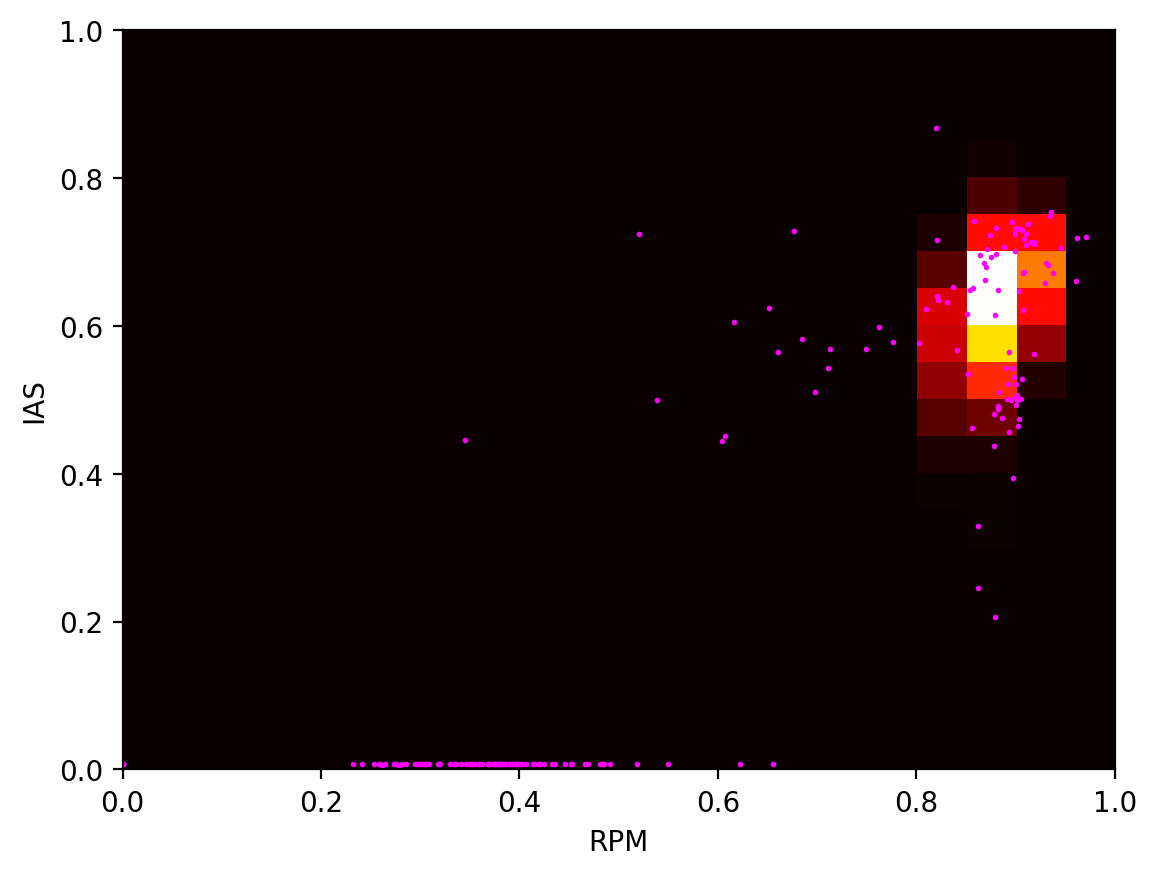

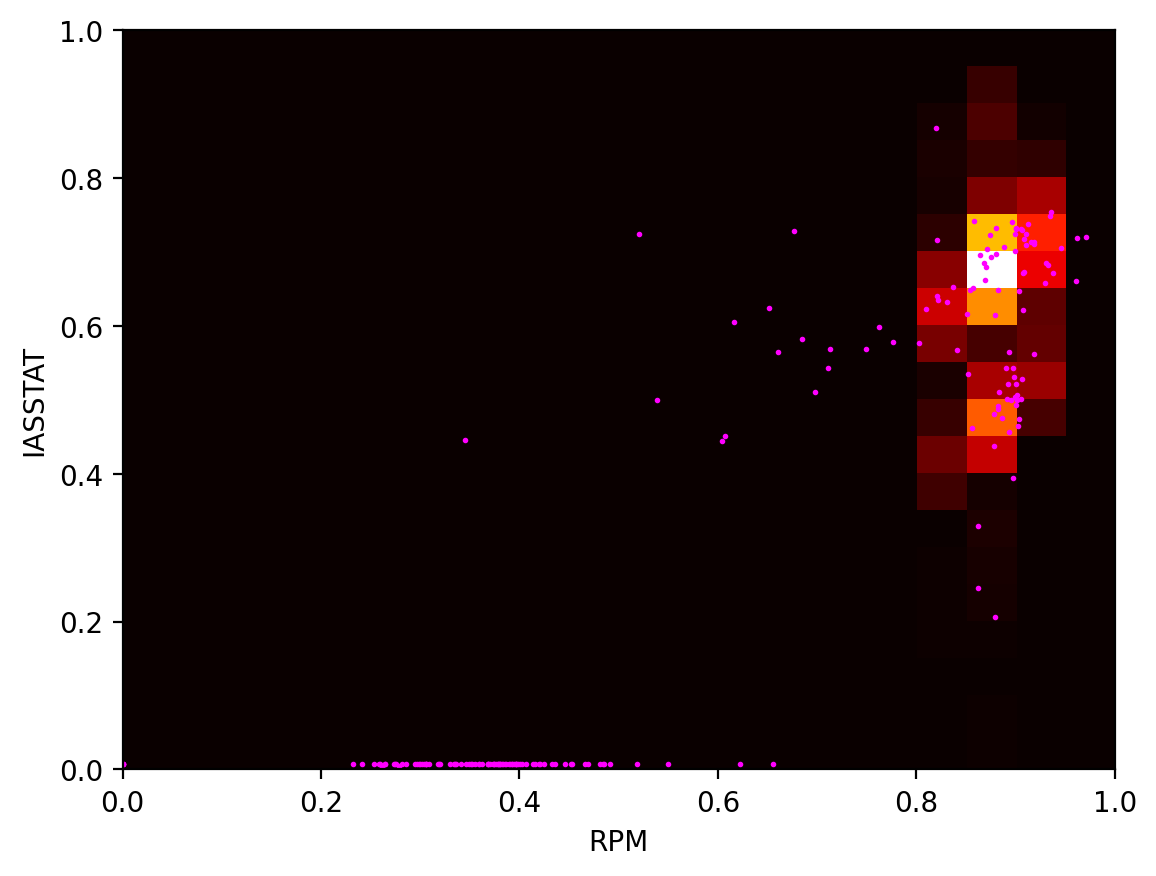

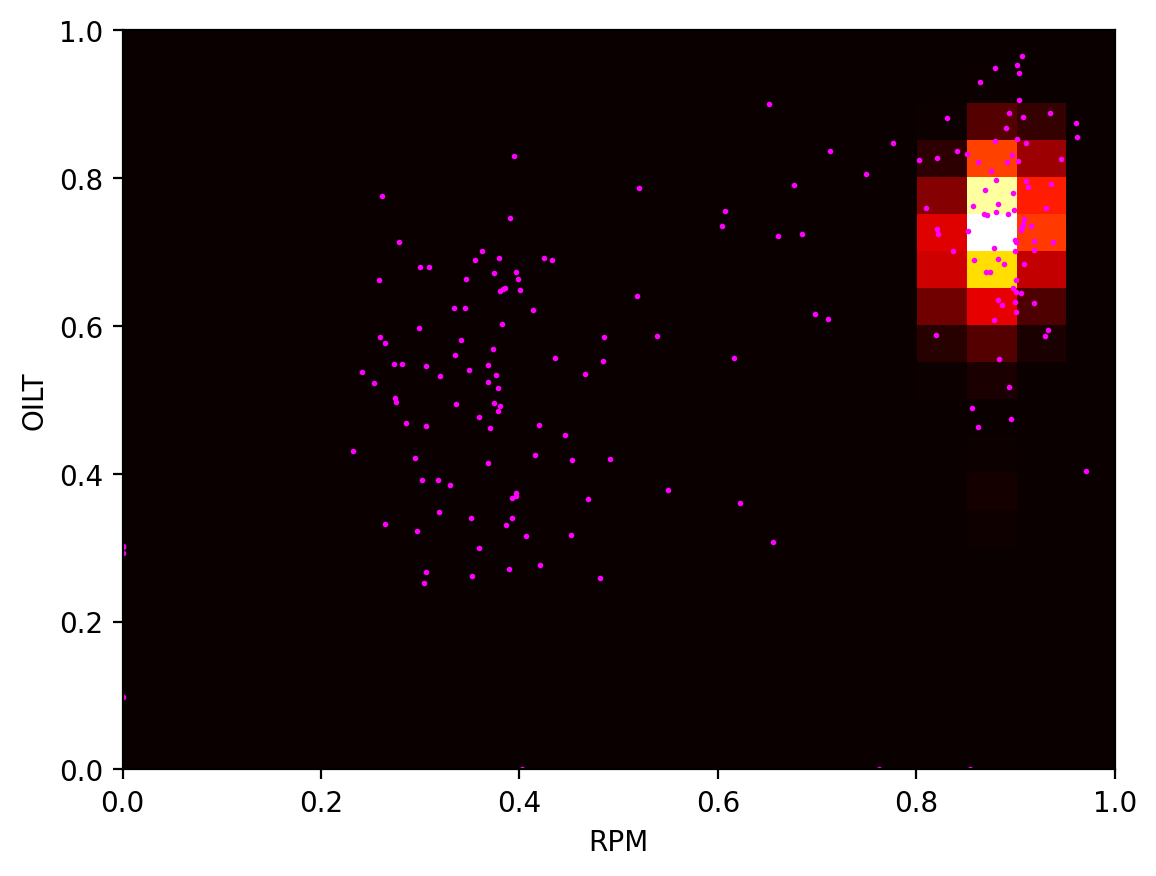

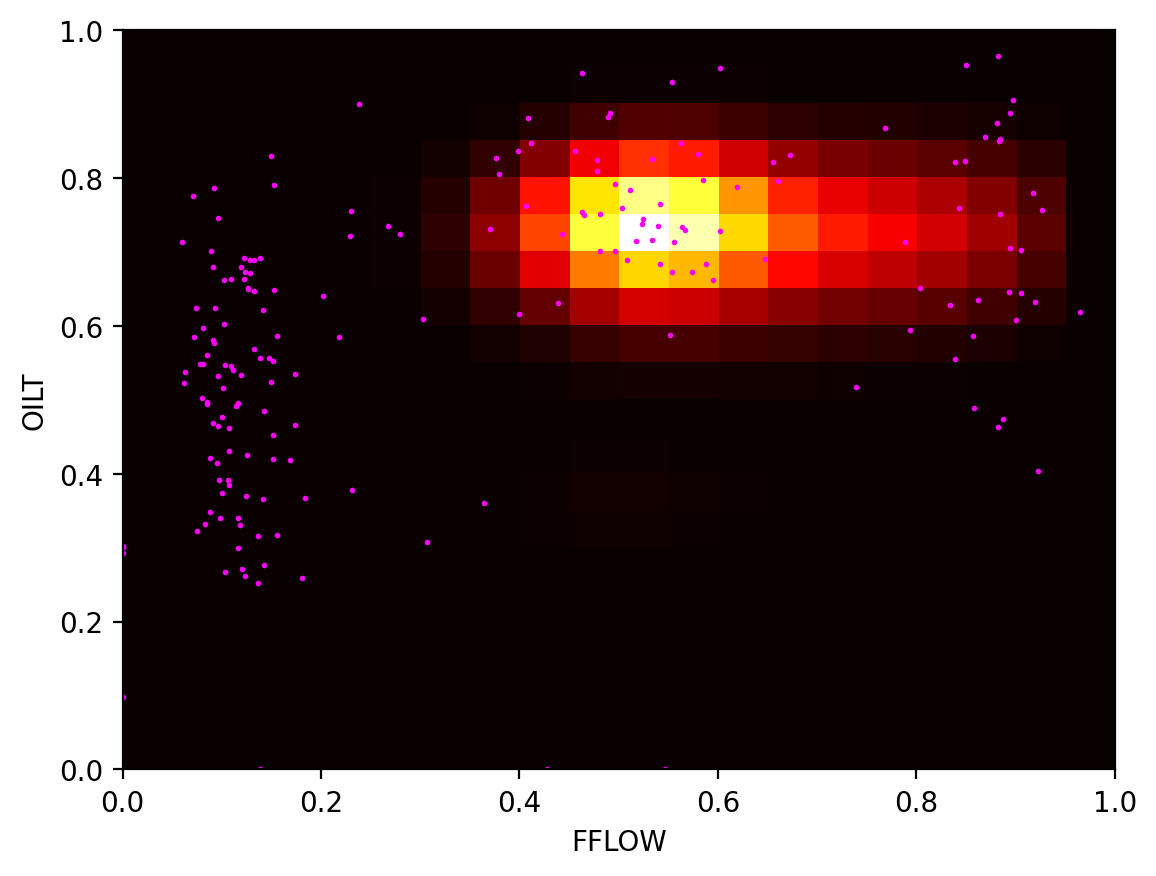

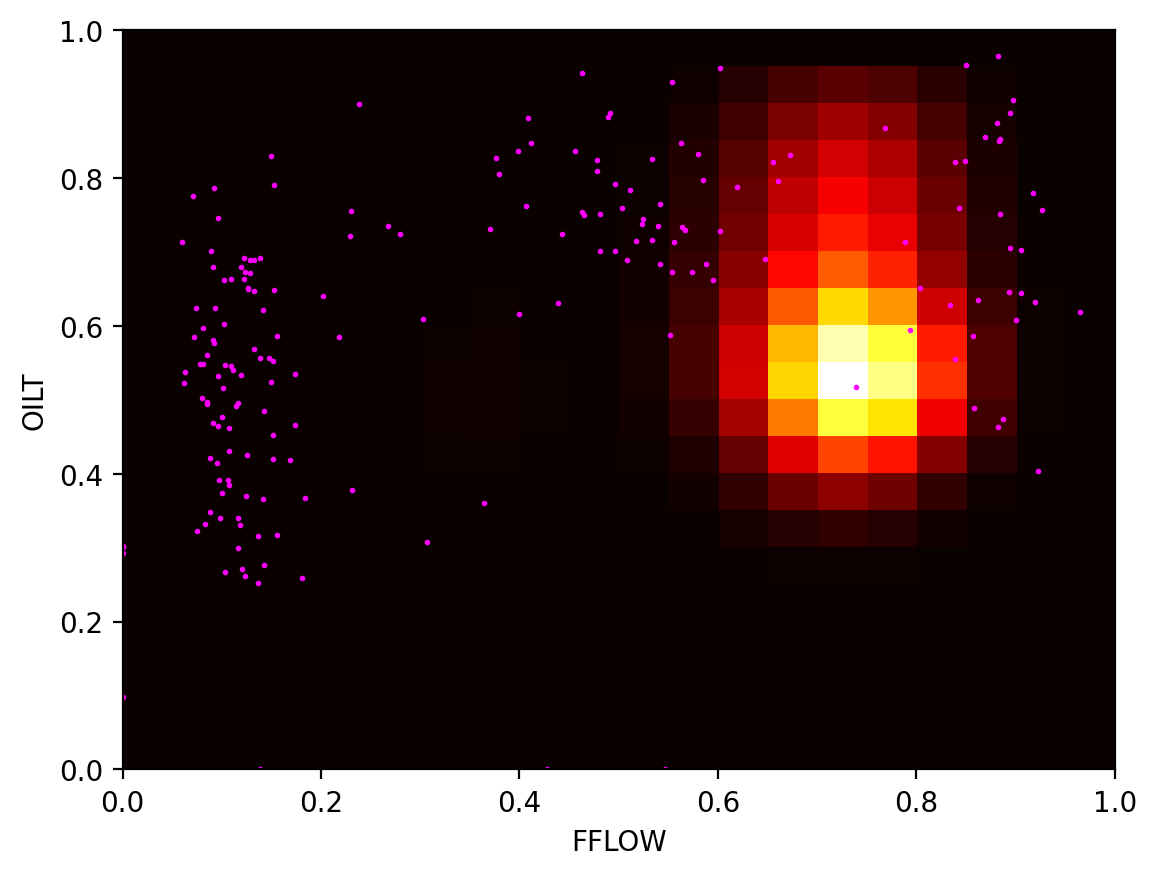

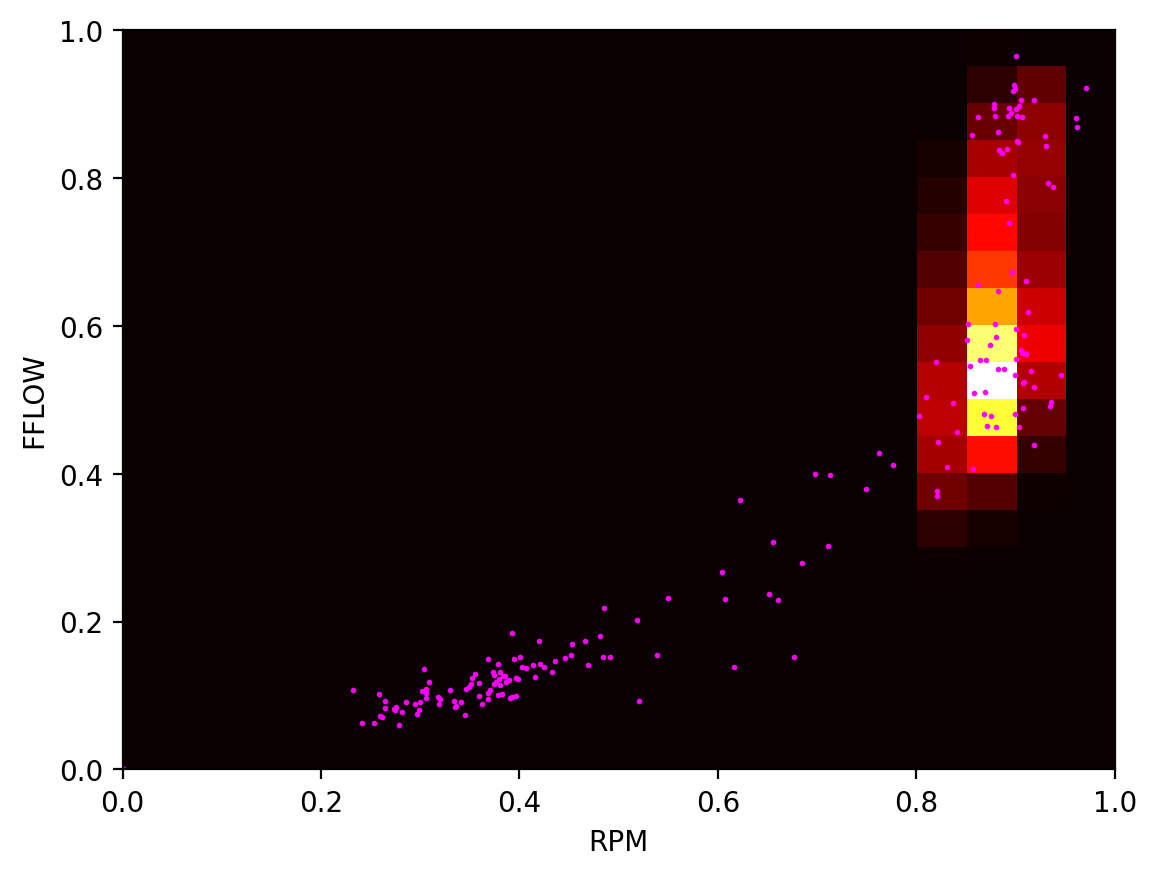

In findNextFunctionAndApply, found function IAS at iteration 11
Required input variables are: ['IASSTAT10', 'IAS10']
Input pmf is ['RPM10', 'ALT10', 'IAS10', 'OILT10', 'FFLOW10', 'OILTSTAT10', 'IASSTAT10']
Output pmf has variables ['RPM10', 'ALT10', 'IAS10', 'OILT10', 'FFLOW10', 'OILTSTAT10', 'IASSTAT10', 'IAS11']
Variables in the input pmf required by the function are [6, 2]
Node IAS10 no longer required. Deleting...
Node FFLOW10 no longer required. Deleting...
Node IASSTAT10 no longer required. Deleting...
Current Nodes: ['OILT10', 'RPM10', 'OILTSTAT10', 'ALT10', 'IAS11']
In findNextFunctionAndApply, found function OILT at iteration 11
Required input variables are: ['OILTSTAT10', 'OILT10']
Input pmf is ['RPM10', 'ALT10', 'OILT10', 'OILTSTAT10', 'IAS11']
Output pmf has variables ['RPM10', 'ALT10', 'OILT10', 'OILTSTAT10', 'IAS11', 'OILT11']
Variables in the input pmf required by the function are [3, 2]
Node OILT10 no longer required. Deleting...
Node OILTSTAT10 no longer required. Dele

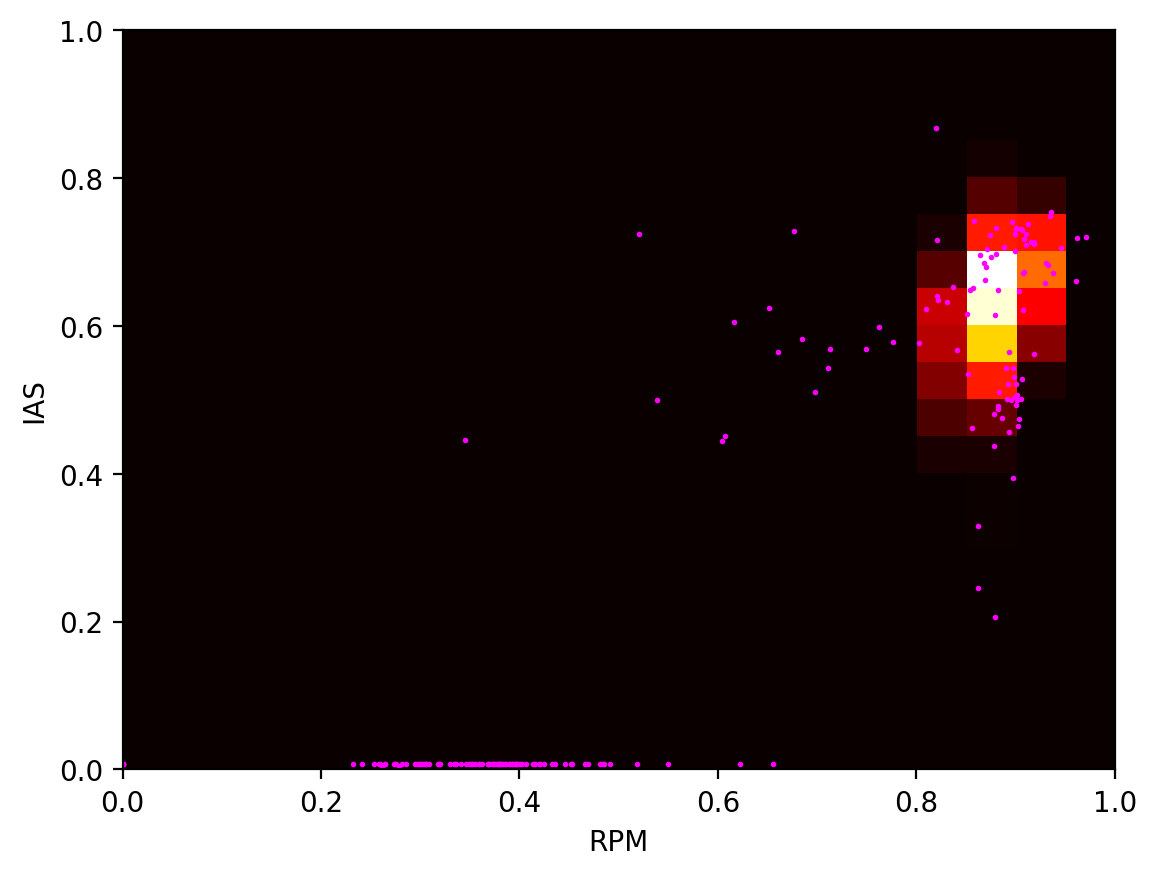

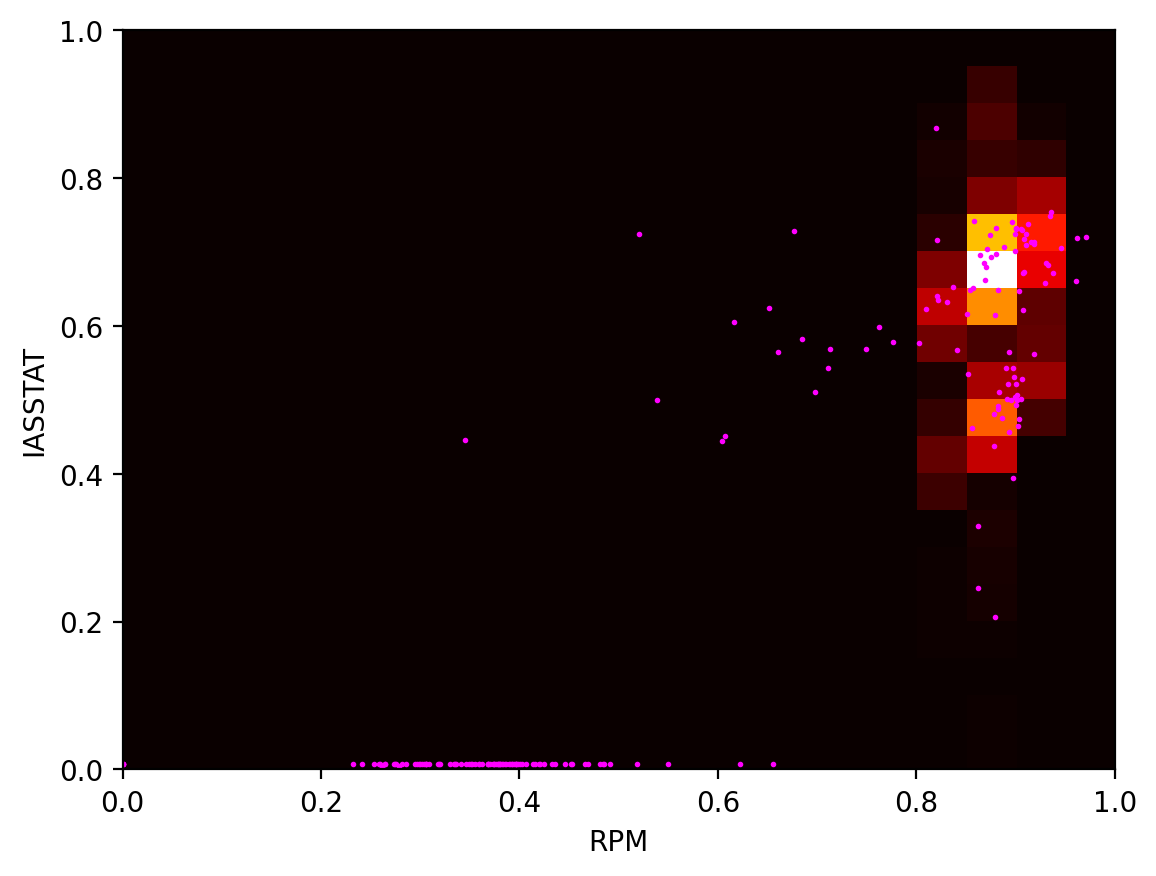

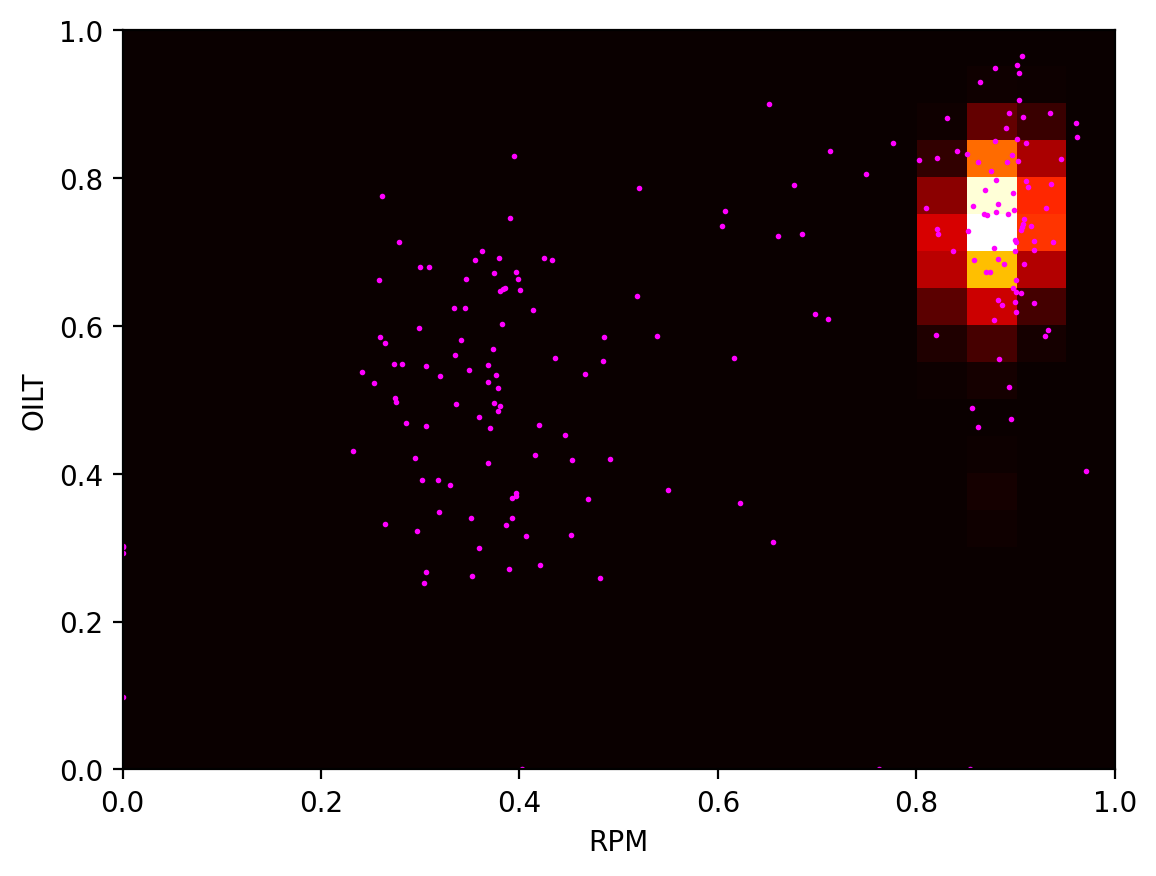

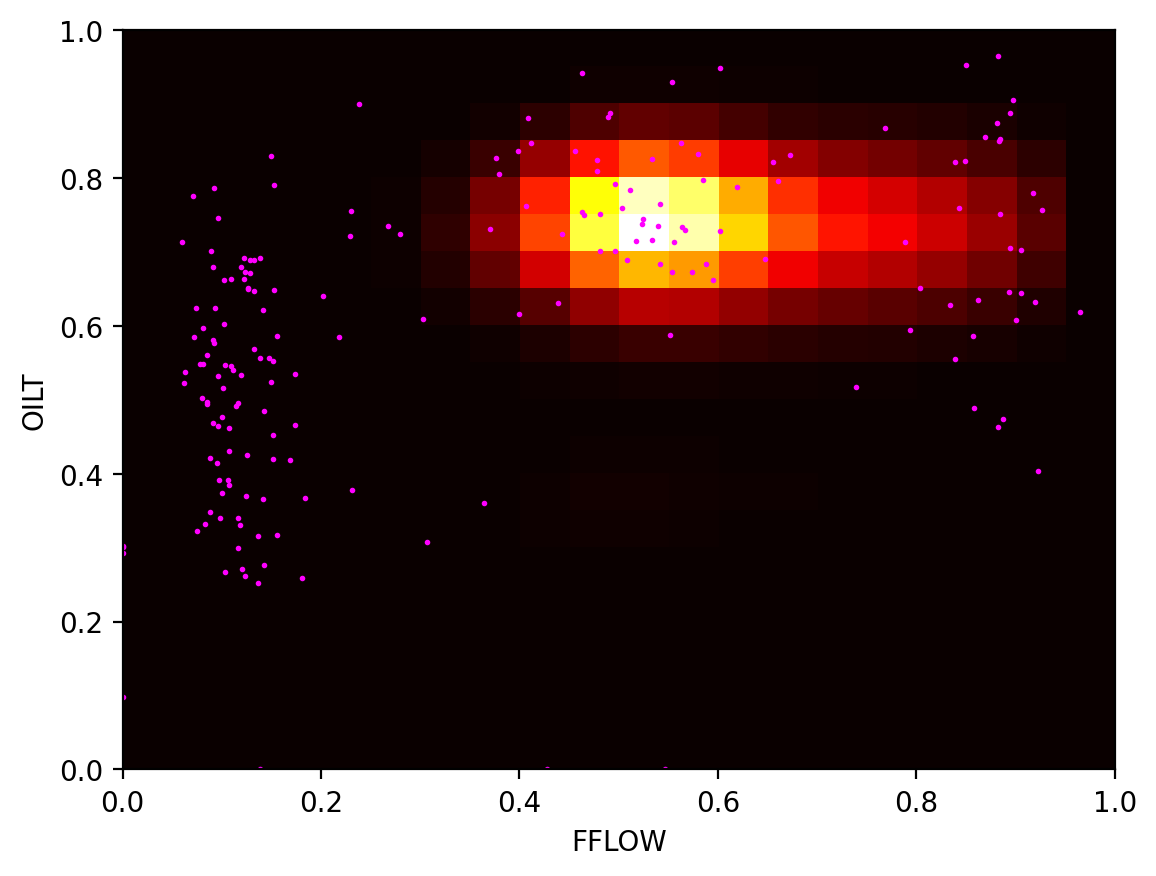

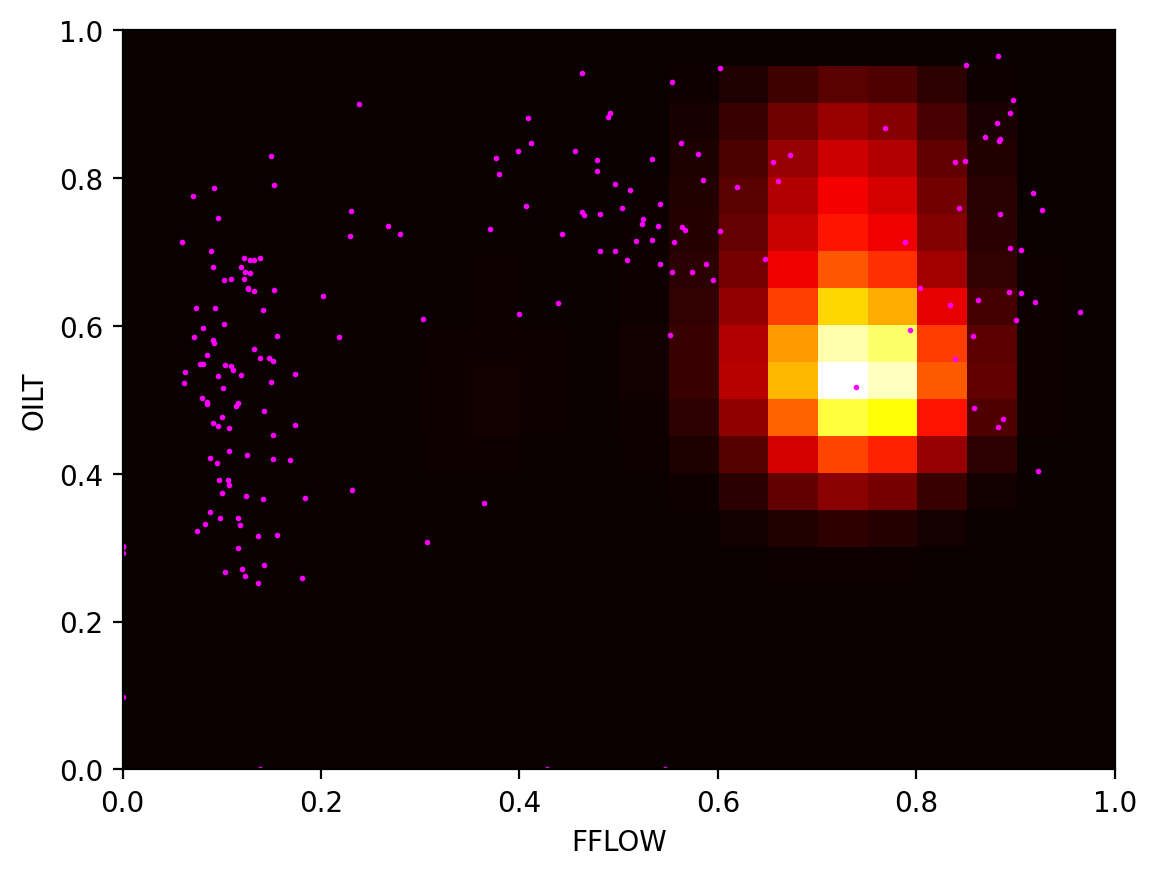

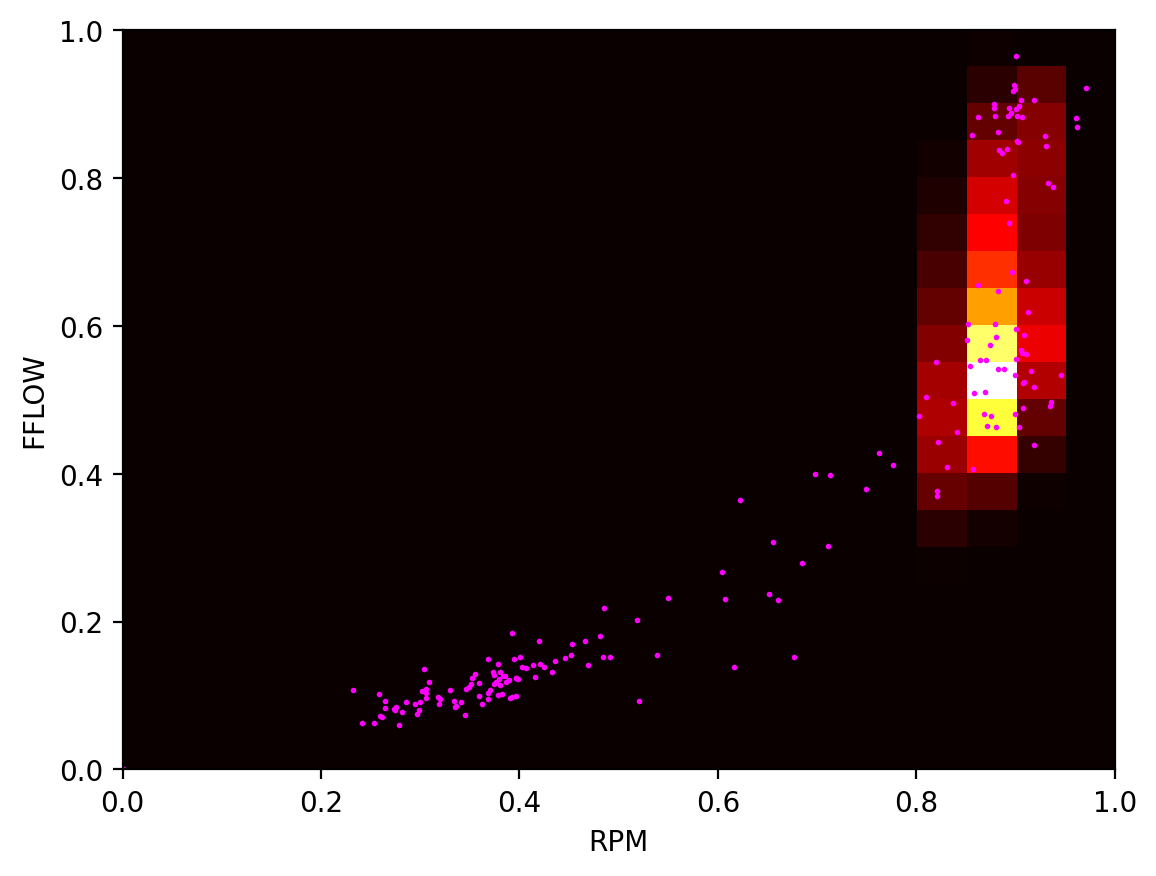

In [14]:
# Define the Causal Jazz transition function
# It takes the name of the python function, the number of inputs, and a flag to say this is a function
# that returns a discretised distribution (as opposed to a single value)
trans_fflow_e = CausalFunction(func_e_fflow, 2)
trans_fflow_noise = CausalFunction(func_fflow_noise, 2, transition_function=True)
trans_oiltstat_e = CausalFunction(func_e_oiltstat, 2)
trans_oiltstat_noise = CausalFunction(func_oiltstat_noise, 2, transition_function=True)
trans_iasstat_e  = CausalFunction(func_e_iasstat, 1)
trans_iasstat_noise  = CausalFunction(func_iasstat_noise, 1, transition_function=True)

# Helper function to sum the inputs (in this case, sum the expected value and the noise)
def func_sum(y):
  out = np.reshape(np.sum(y, axis=-1), (np.array(y).shape[0],1))
  return out

trans_sum = CausalFunction(func_sum, 2)

# Make a function to perform the euler integration y = y + alpha(stat - y)
# In this case, we just use a single value for all applications with an
# alpha that we hard code.
# Generally, you'll need different values for each application of the function.
def func_euler(y):
  alpha = 0.5
  y = np.array(y)
  stat = y[:,0]
  v = y[:,1]
  out = np.reshape(v + (alpha * (stat - v)), (np.array(y).shape[0],1))
  return out

trans_euler = CausalFunction(func_euler, 2)

# All our functions are trained on normalised data so every output template
# should look the same.
out_template = pmf(np.array([]), np.array([0.0]), np.array([1.0 / output_res]), 0.000001)

# Define the variable names for each function in TEDAG
tedag_func_fflow_e = TEDAG_FUNCTION(['RPM', 'IAS'], 'FFLOW_E', 0, trans_fflow_e, out_template)
tedag_func_fflow_noise = TEDAG_FUNCTION(['RPM', 'IAS'], 'FFLOW_N', 0, trans_fflow_noise, out_template)
tedag_func_fflow = TEDAG_FUNCTION(['FFLOW_E', 'FFLOW_N'], 'FFLOW', 0, trans_sum, out_template)

tedag_func_oiltstat_e = TEDAG_FUNCTION(['RPM', 'FFLOW'], 'OILTSTAT_E', 0, trans_oiltstat_e, out_template)
tedag_func_oiltstat_noise = TEDAG_FUNCTION(['RPM', 'FFLOW'], 'OILTSTAT_N', 0, trans_oiltstat_noise, out_template)
tedag_func_oiltstat = TEDAG_FUNCTION(['OILTSTAT_E', 'OILTSTAT_N'], 'OILTSTAT', 0, trans_sum, out_template)

tedag_func_iasstat_e  = TEDAG_FUNCTION(['RPM'], 'IASSTAT_E', 0, trans_iasstat_e, out_template)
tedag_func_iasstat_noise  = TEDAG_FUNCTION(['RPM'], 'IASSTAT_N', 0, trans_iasstat_noise, out_template)
tedag_func_iasstat = TEDAG_FUNCTION(['IASSTAT_E', 'IASSTAT_N'], 'IASSTAT', 0, trans_sum, out_template)

# The euler functions
tedag_func_ias = TEDAG_FUNCTION(['IASSTAT', 'IAS'], 'IAS', 1, trans_euler, out_template)
tedag_func_oilt = TEDAG_FUNCTION(['OILTSTAT', 'OILT'], 'OILT', 1, trans_euler, out_template)

# RPM and ALT remain constant from one timestep to the next so we create a
# function (with None as the actual transition) to simply pass the value on to
# the next timestep
tedage_func_rpm = TEDAG_FUNCTION(['RPM'], 'RPM', 1, None, out_template)
tedage_func_alt = TEDAG_FUNCTION(['ALT'], 'ALT', 1, None, out_template)

# Initialise the TEDAG
tedag = TEDAG(1, [tedag_func_fflow_e,
                  tedag_func_fflow_noise,
                  tedag_func_fflow,
                  tedag_func_oiltstat_e,
                  tedag_func_oiltstat_noise,
                  tedag_func_oiltstat,
                  tedag_func_iasstat_e,
                  tedag_func_iasstat_noise,
                  tedag_func_iasstat,
                  tedag_func_ias,
                  tedag_func_oilt,
                  tedage_func_rpm,
                  tedage_func_alt], observables=['RPM', 'ALT', 'FFLOW', 'OILT', 'IAS', 'IASStat'], verbose=True)

# Build a PMF from the first timestep of the original data as a starting point
number_of_points = 10000

data_items = training_data_after[::100,:].T
red_rpm_input_data = data_items[0][:number_of_points]
red_fflow_input_data = data_items[1][:number_of_points]
red_alt_input_data = data_items[2][:number_of_points]
red_ias_input_data = data_items[3][:number_of_points]
red_oilp_input_data = data_items[4][:number_of_points]
red_oilt_input_data = data_items[5][:number_of_points]


# Generate normal distributions for RPM and ALT to get a greater spread of values
rpm_normal_data = red_rpm_input_data#np.random.normal(loc=np.mean(red_rpm_input_data), scale=np.std(red_rpm_input_data), size=number_of_points)
alt_normal_data = red_alt_input_data#np.random.normal(loc=np.mean(red_alt_input_data), scale=np.std(red_alt_input_data), size=number_of_points)

# OILTSTAT and IASSTAT are initialised the same as OILT and IAS
initial_sample = np.array([rpm_normal_data, red_oilt_input_data, red_ias_input_data, alt_normal_data, red_oilt_input_data, red_ias_input_data])
# A Causal Jazz PMF can be generated from data
initial_pmf = pmf([], np.zeros(6), np.ones(6)/output_res, 0.000001)
initial_pmf.generateInitialDistribtionFromSample(initial_sample.T)

# We use an intervention to set the initial distribution
tedag.addIntervention(['RPM', 'OILT', 'IAS', 'ALT', 'OILTSTAT', 'IASSTAT'], 0, initial_pmf)

# Add an intervention at i=3 : RPM to 90%
rpm_pmf = generateGaussianNoisePmf(0.0, 1.0, 0.9, 0.05, output_res)
rpm_pmf = pmf(rpm_pmf, np.zeros(1), np.ones(1)/output_res, 0.000001)

tedag.addIntervention(['RPM'], 3, rpm_pmf)

num_iterations = 12

for i in range(num_iterations):
  # Forward calculate the distributions
  while tedag.findNextFunctionAndApply(i):
      continue
  plotDistribution(['RPM', 'IAS'],[red_rpm_input_data[::10],red_ias_input_data[::10]], i)
  plotDistribution(['RPM', 'IASSTAT'],[red_rpm_input_data[::10],red_ias_input_data[::10]], i)
  plotDistribution(['RPM', 'OILT'],[red_rpm_input_data[::10],red_oilt_input_data[::10]], i)
  # There's a bug in the tedag code to get the correct variable order
  # For now, just use a transpose flag to flip them here - needs fixing though
  plotDistribution(['FFLOW', 'OILT'],[red_fflow_input_data[::10],red_oilt_input_data[::10]], i, transpose=True)
  plotDistribution(['FFLOW', 'OILT'],[red_fflow_input_data[::10],red_oilt_input_data[::10]], i, transpose=False)
  plotDistribution(['RPM', 'FFLOW'],[red_rpm_input_data[::10],red_fflow_input_data[::10]], i)



Monte Carlo alternative

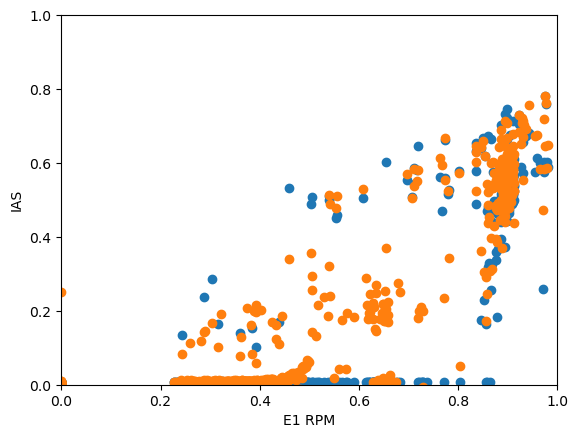

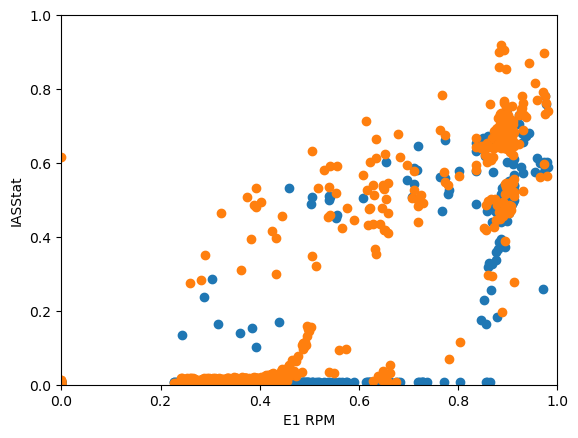

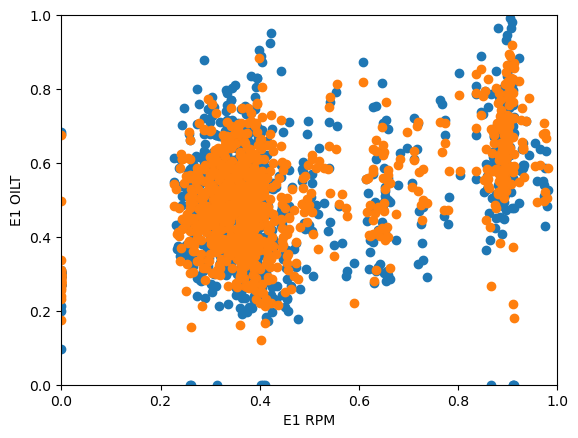

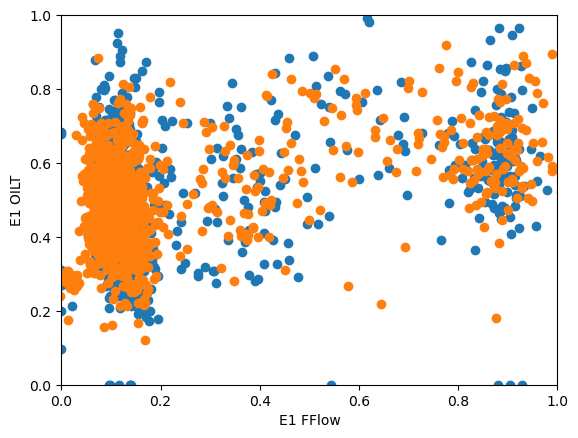

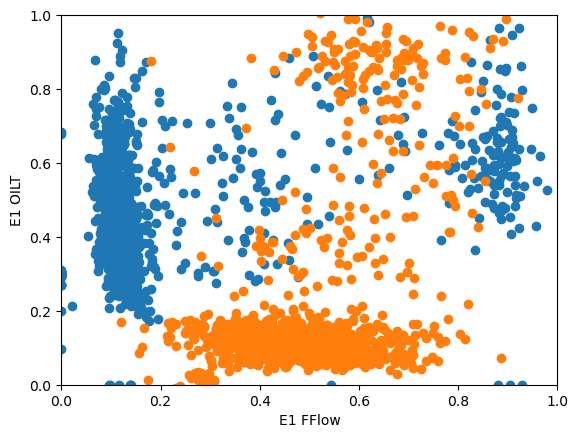

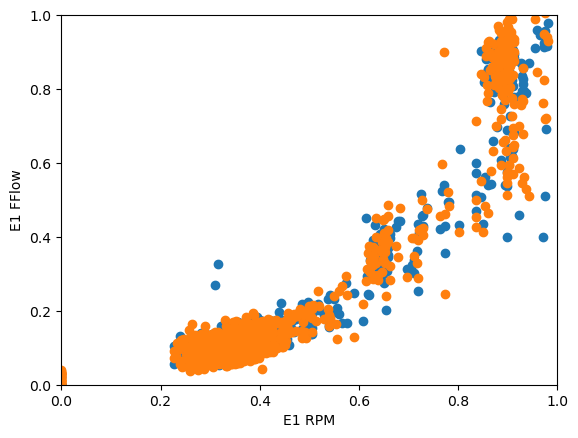

next


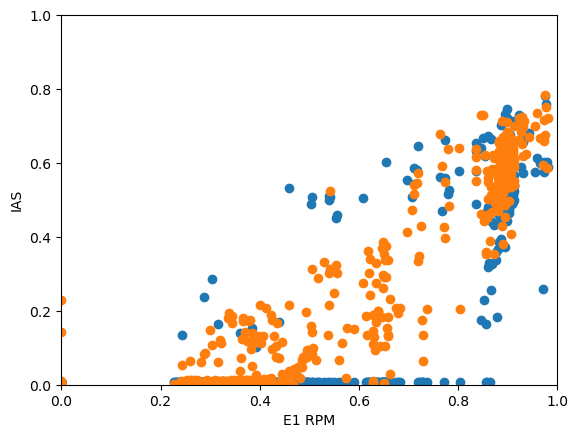

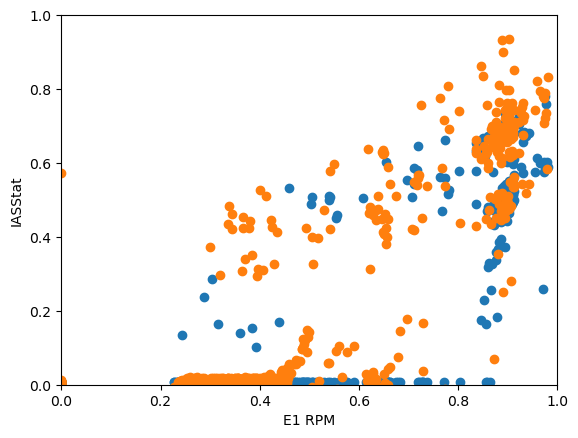

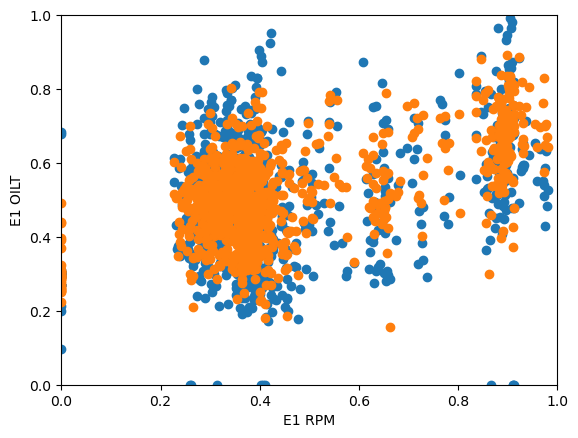

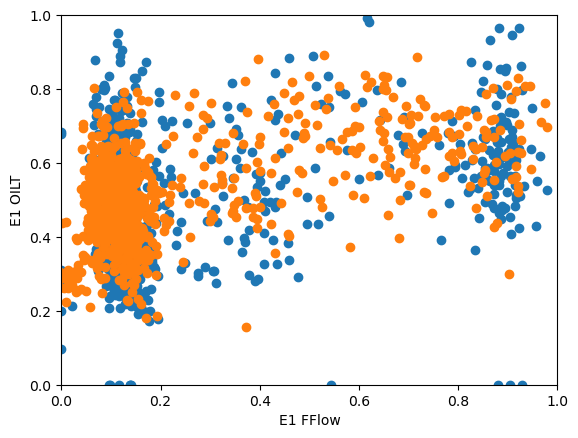

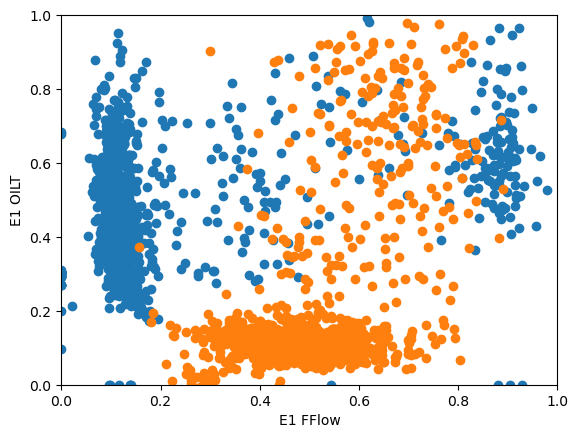

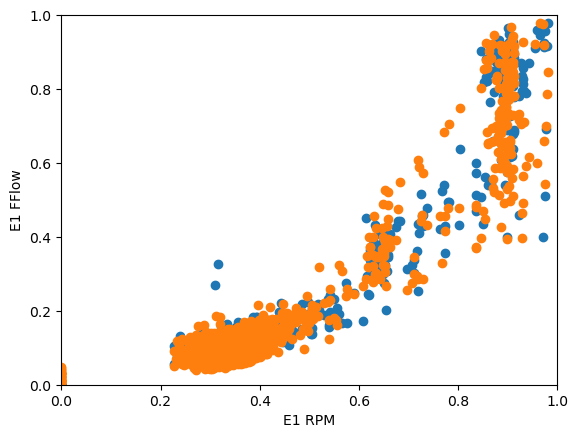

next


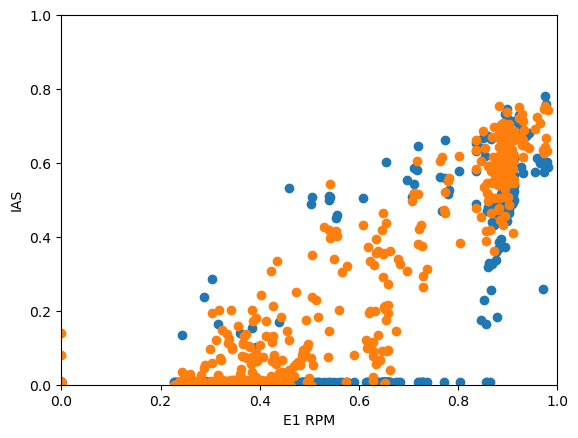

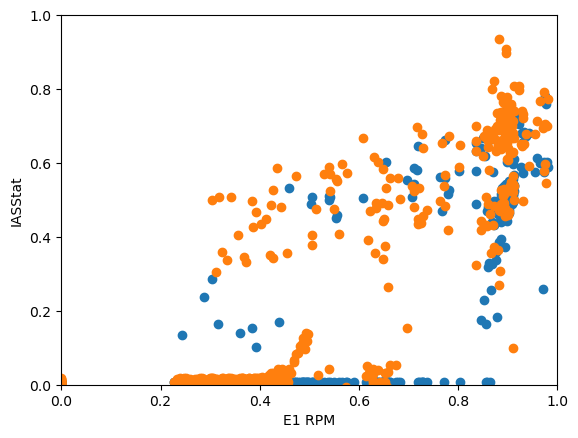

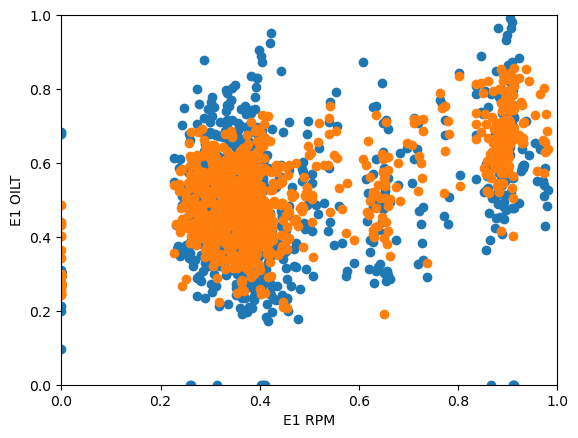

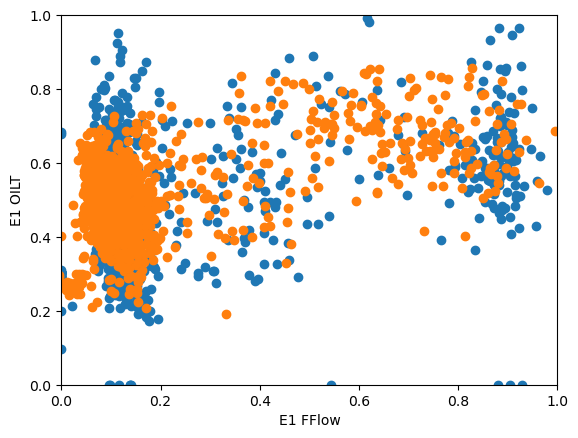

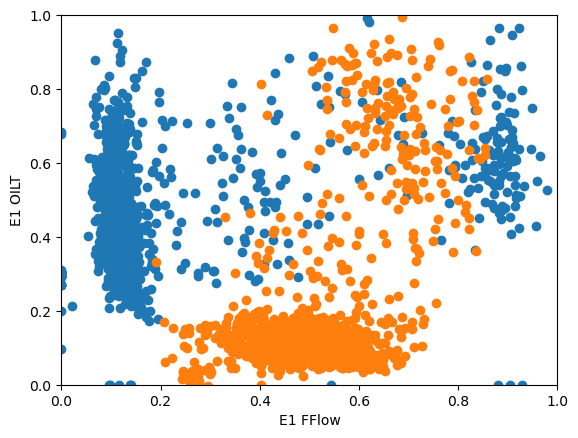

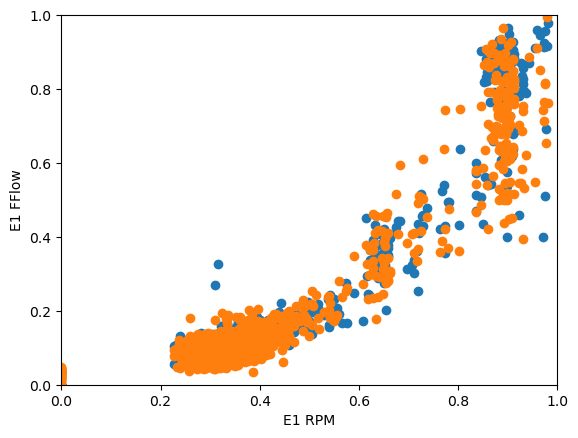

next


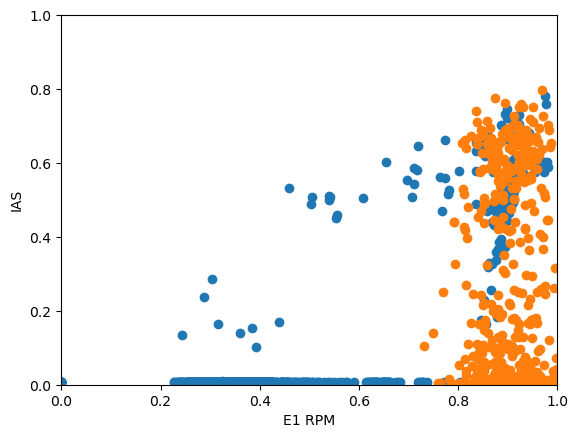

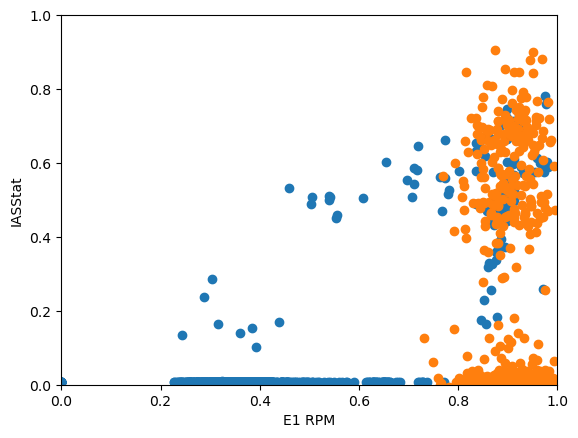

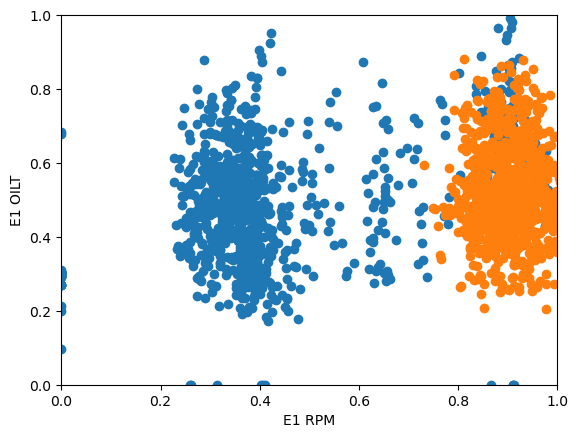

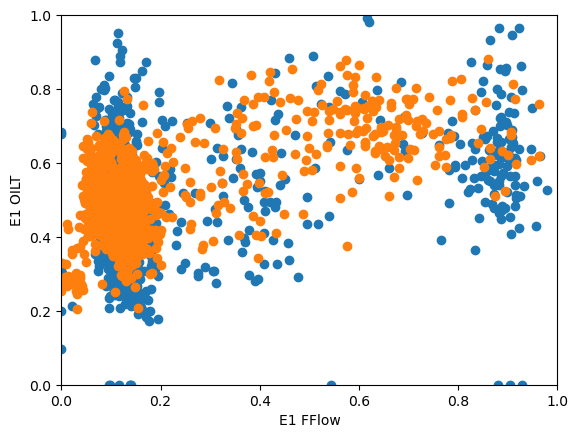

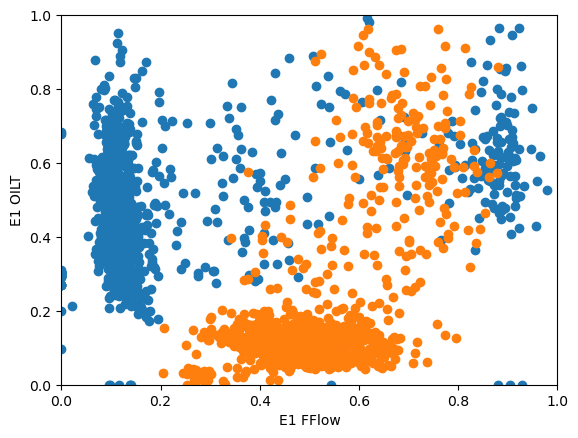

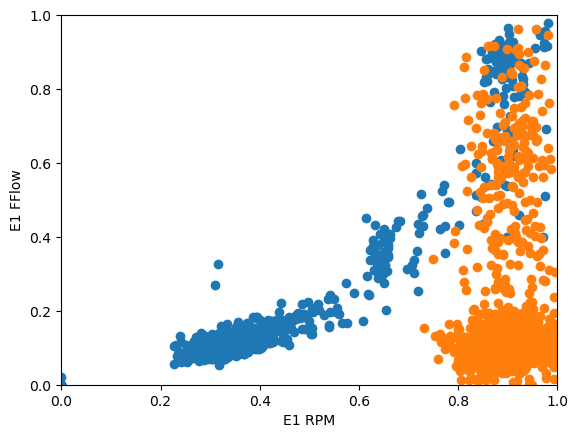

next


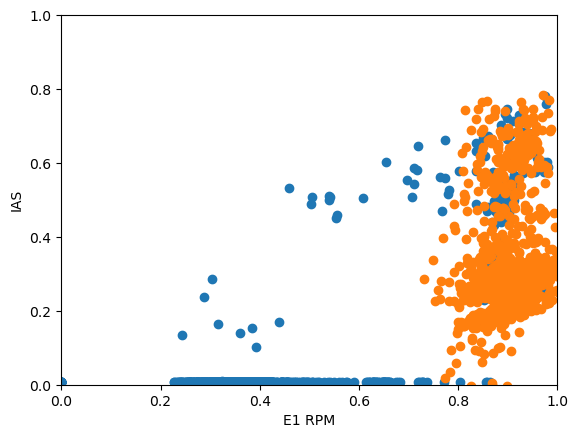

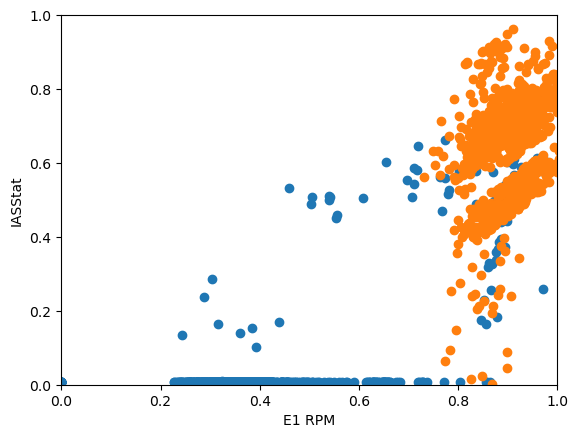

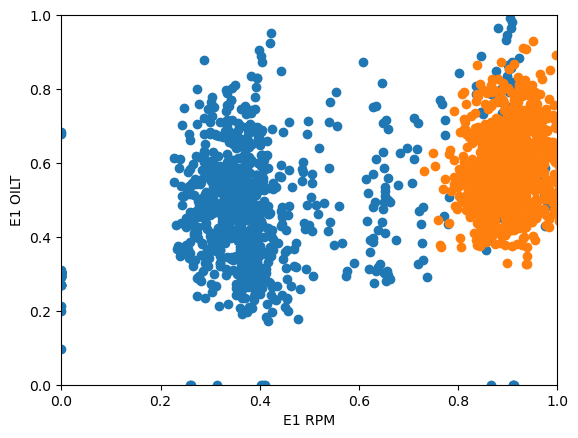

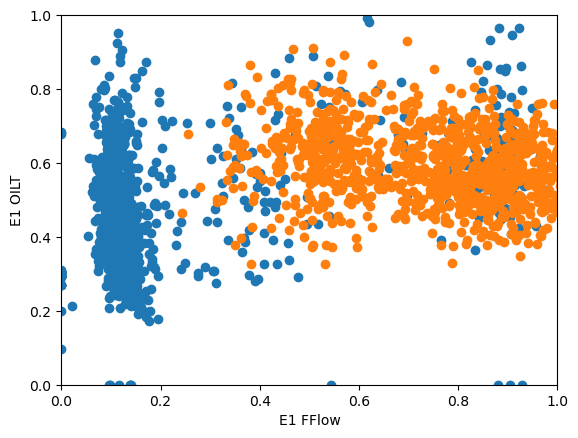

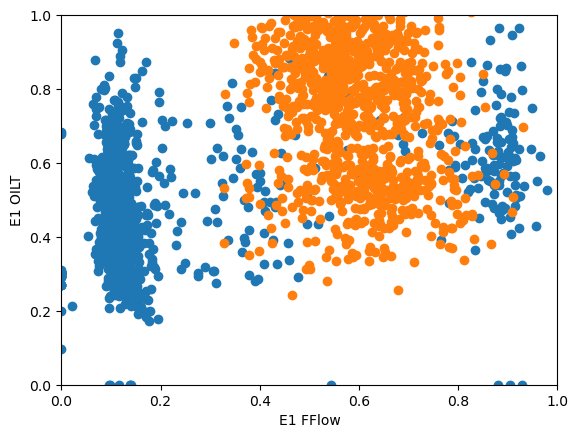

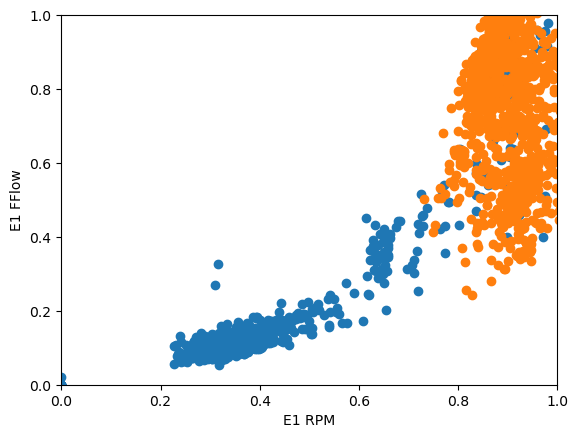

next


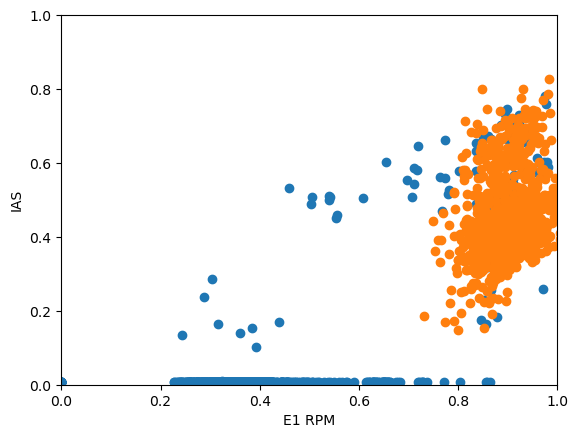

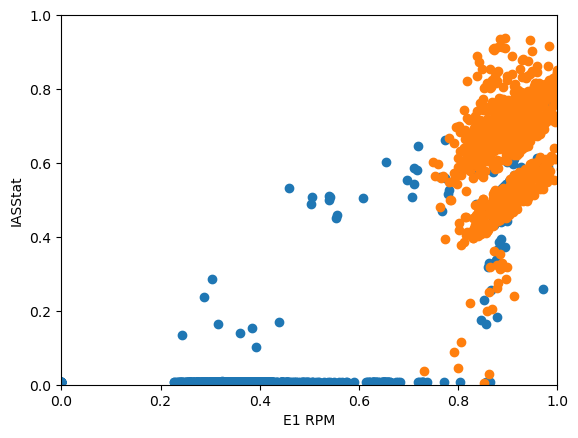

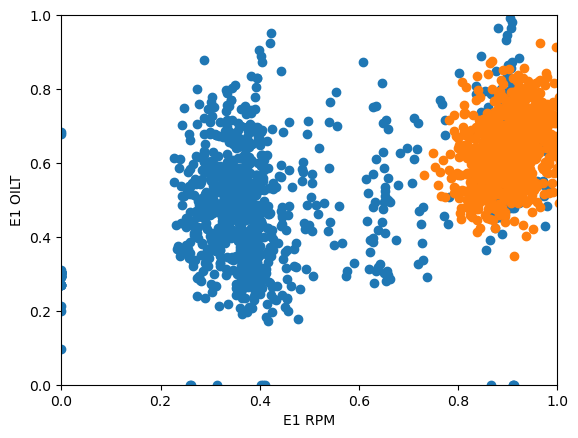

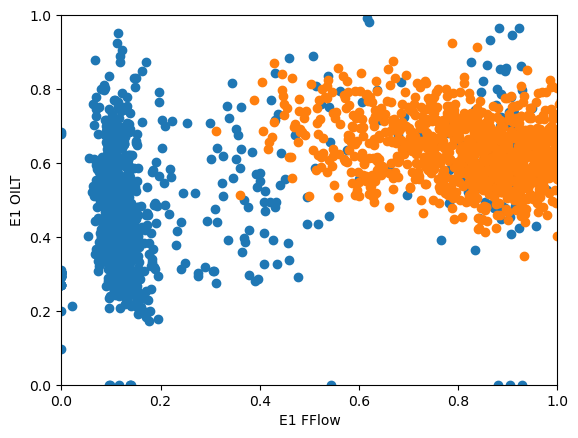

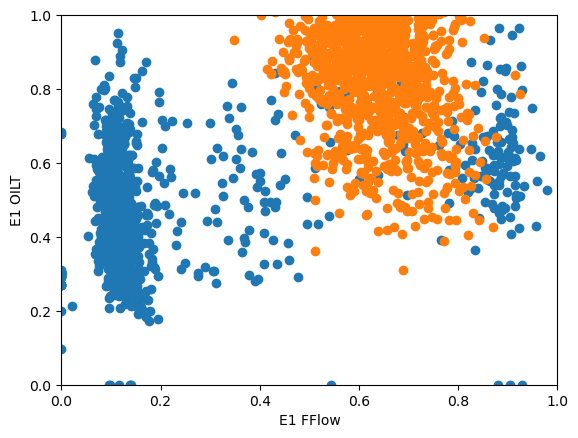

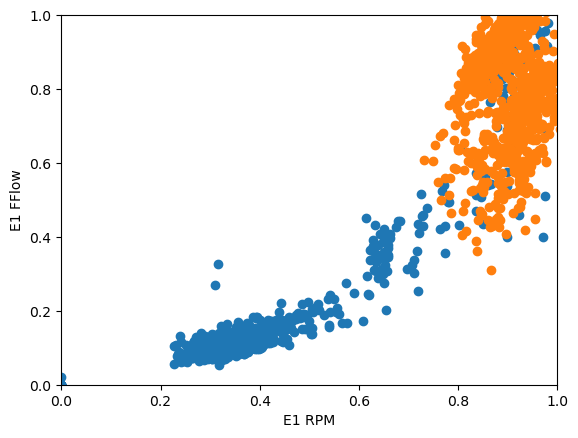

next


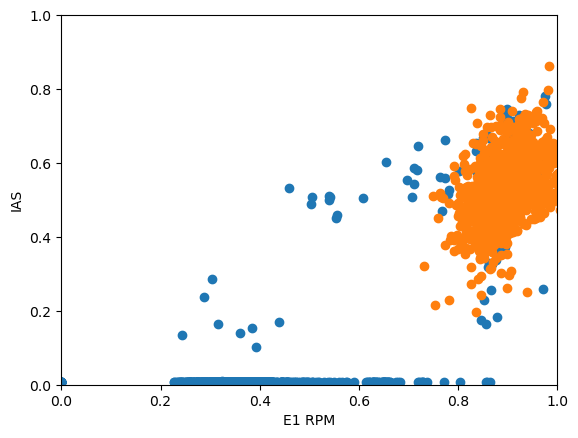

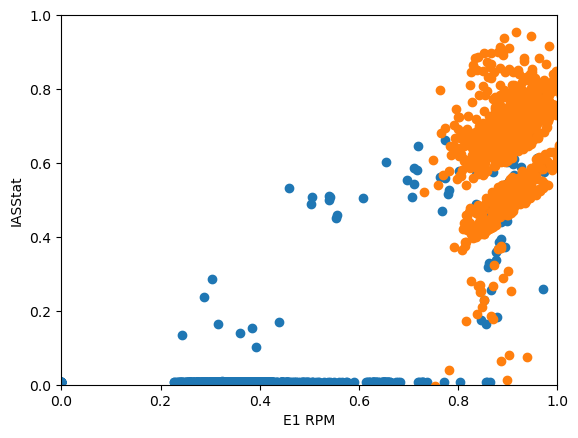

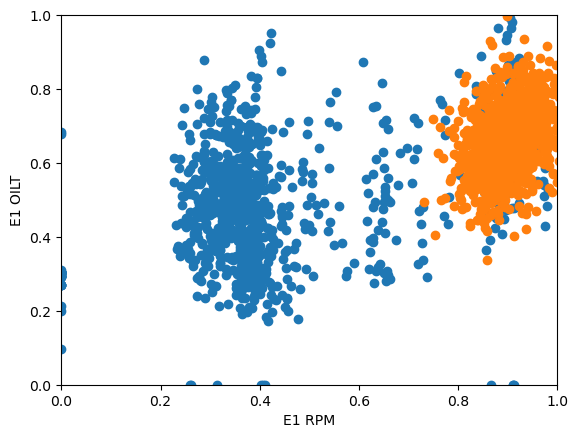

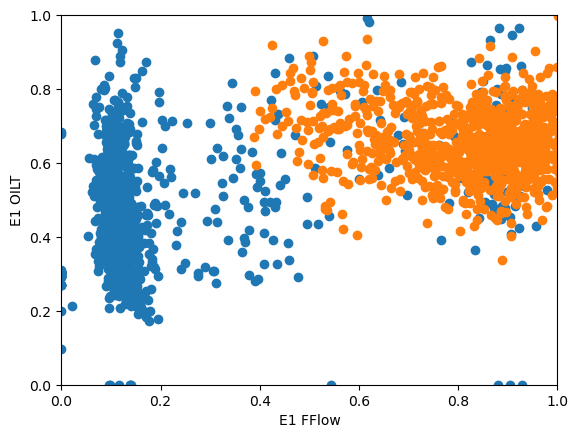

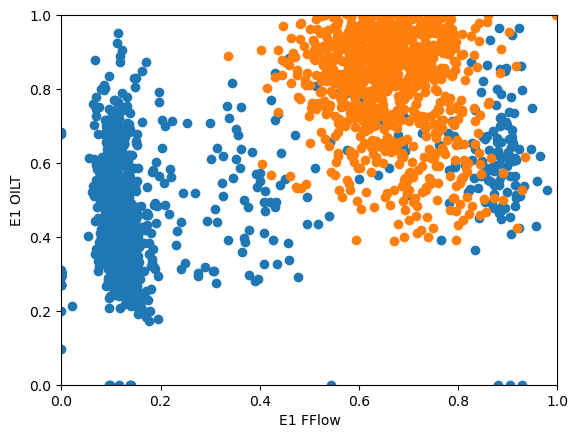

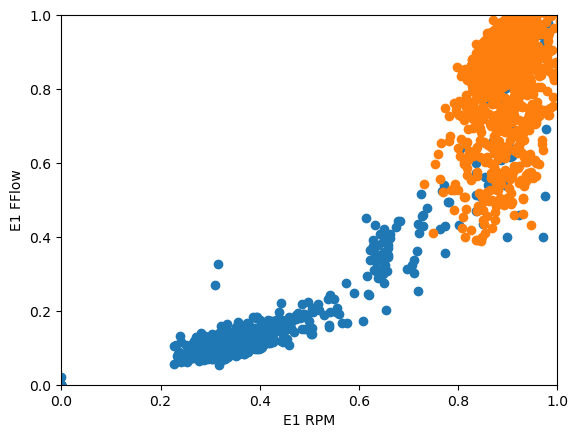

next


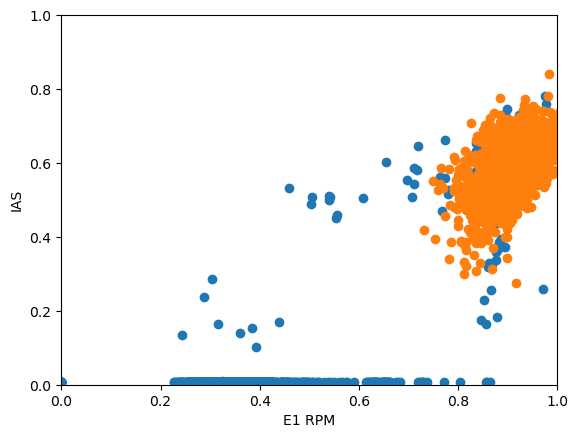

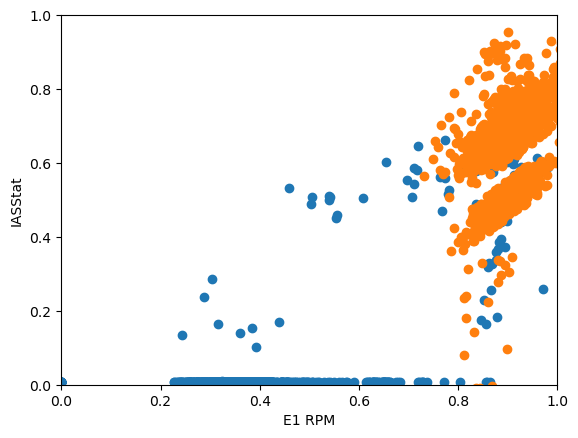

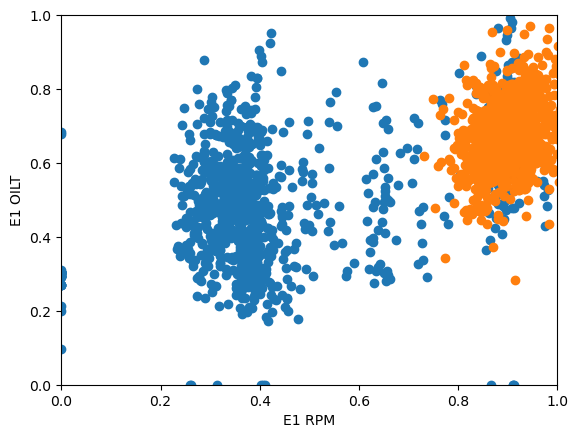

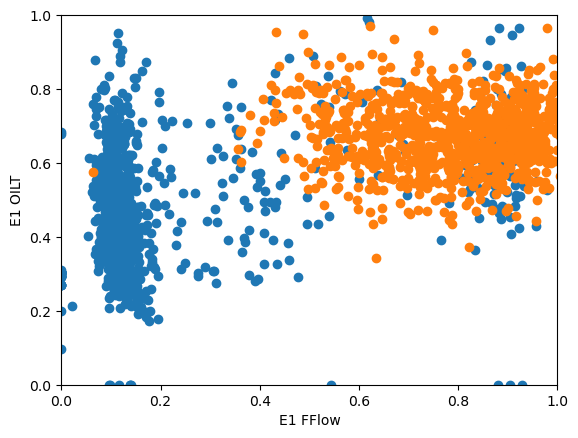

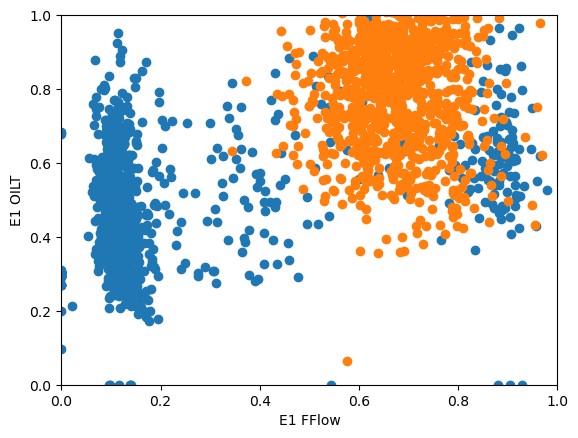

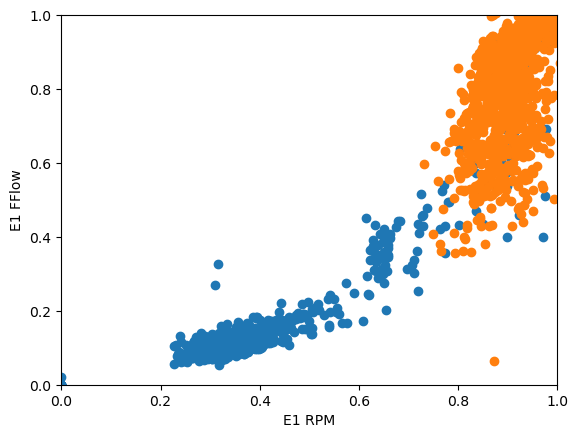

next


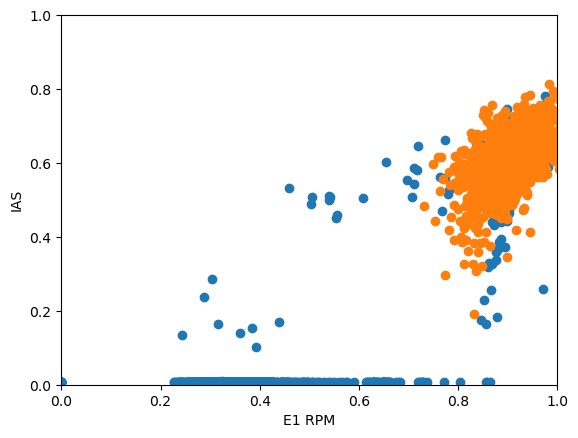

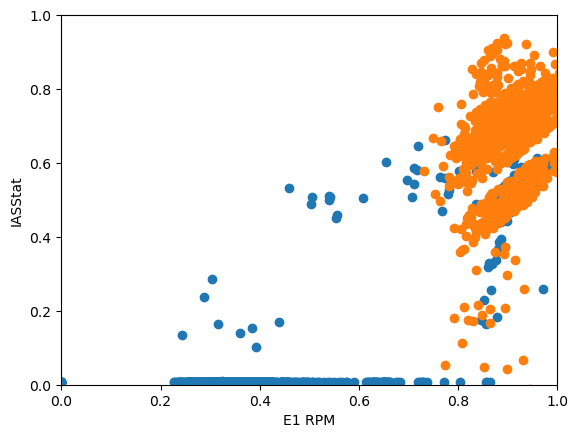

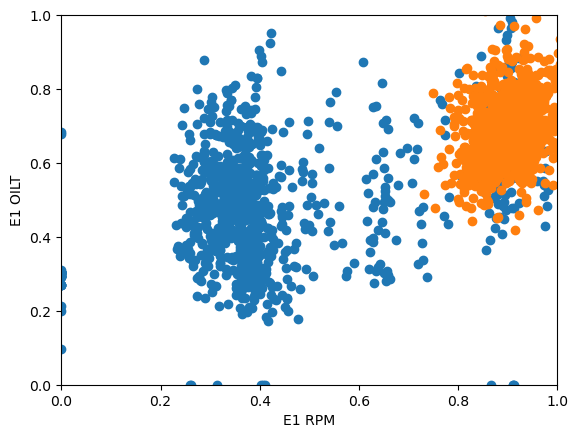

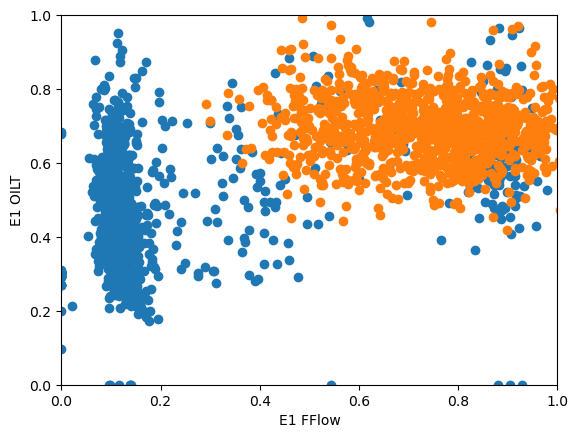

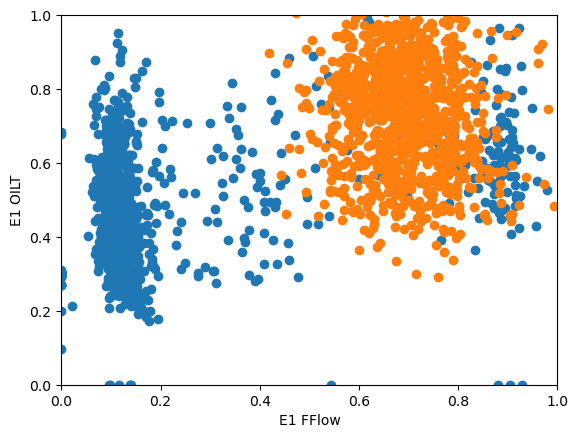

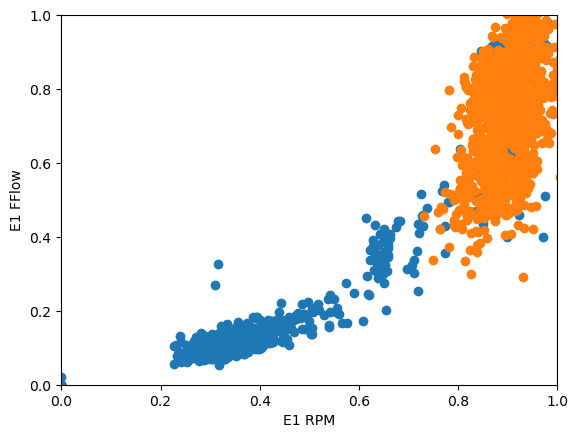

next


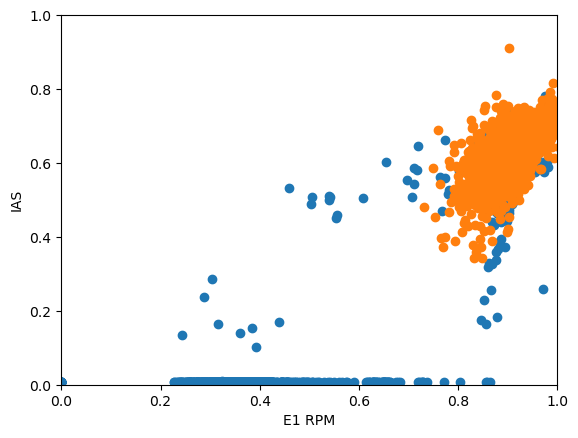

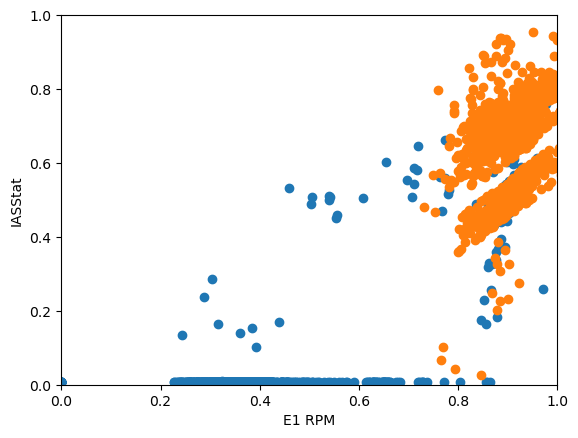

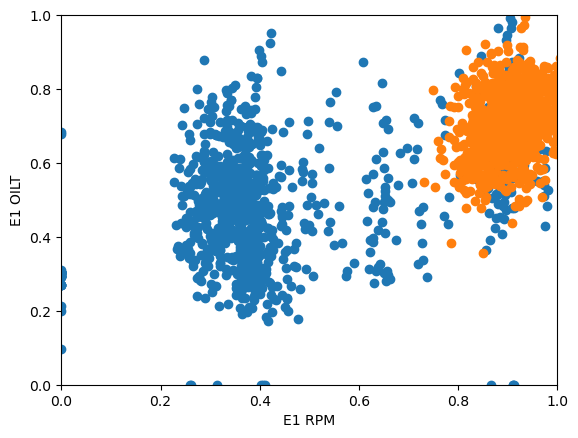

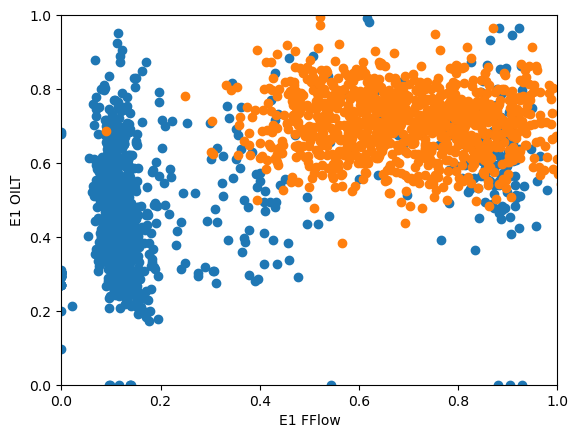

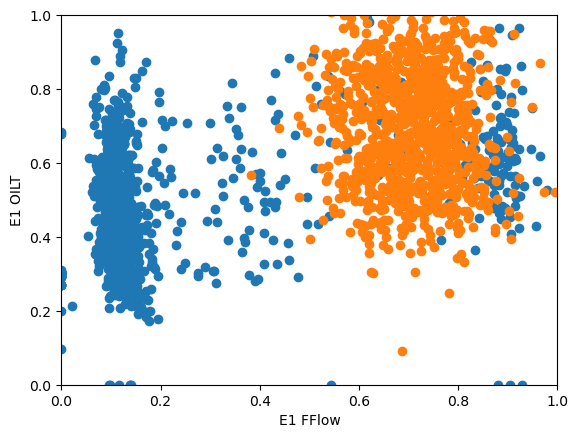

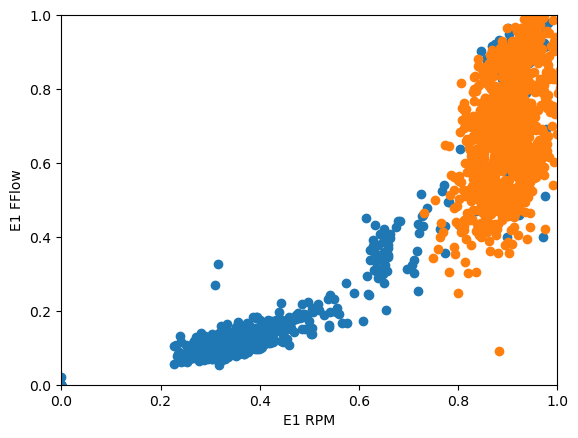

next


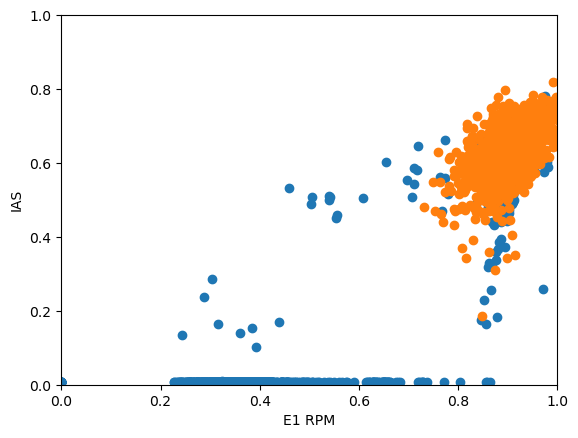

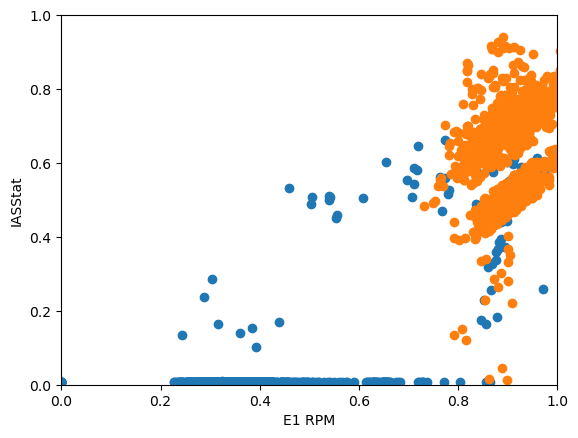

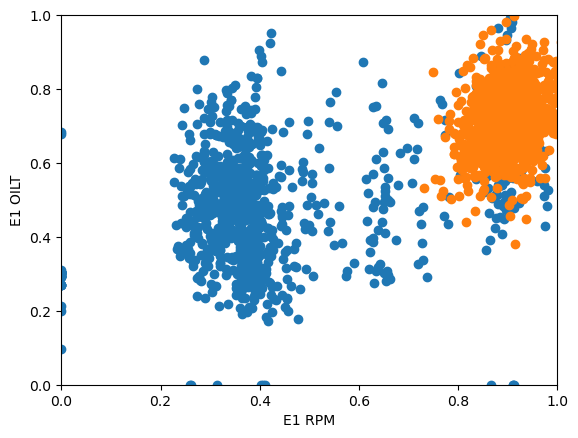

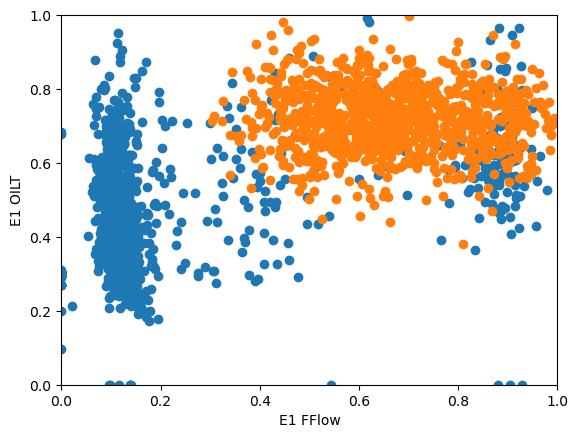

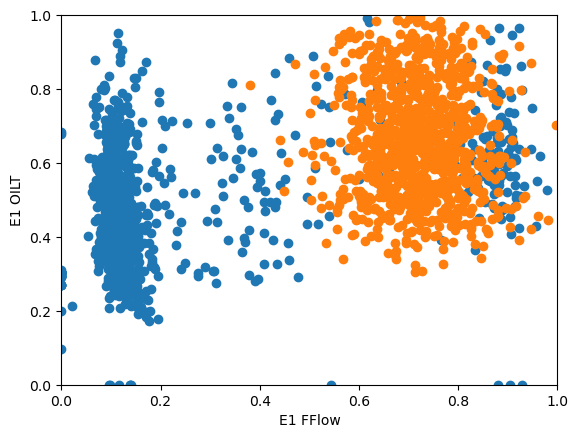

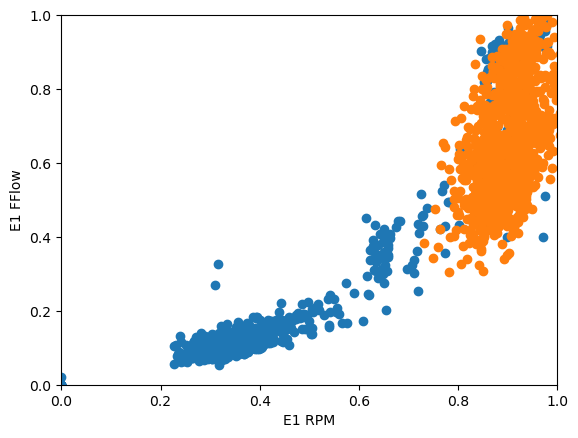

next


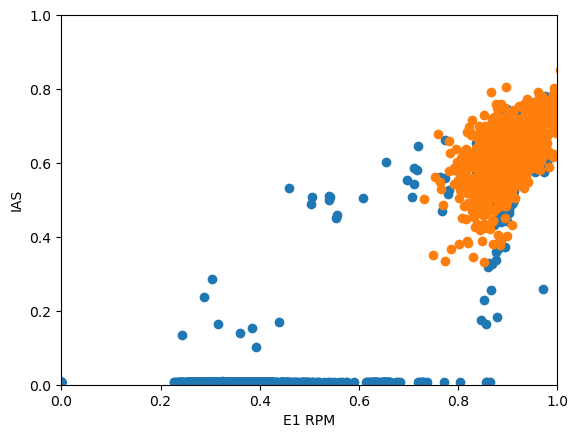

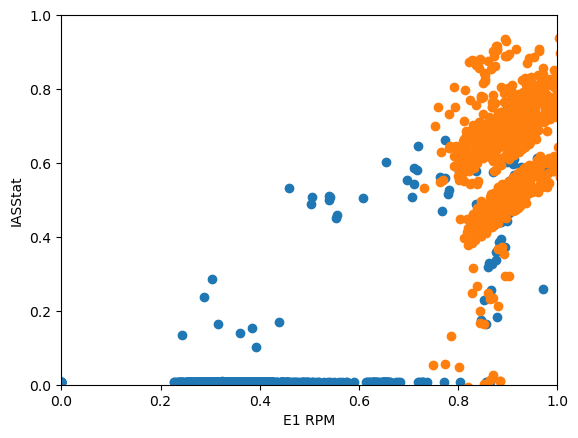

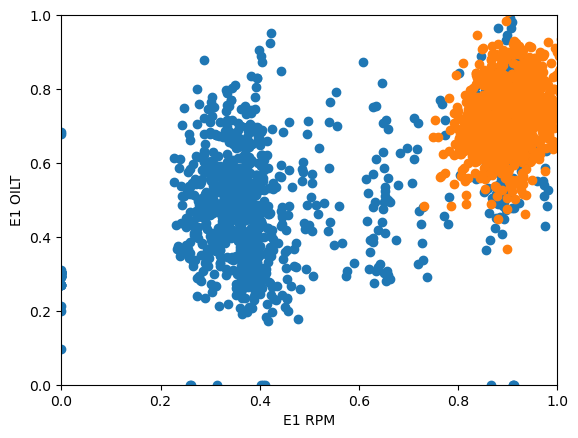

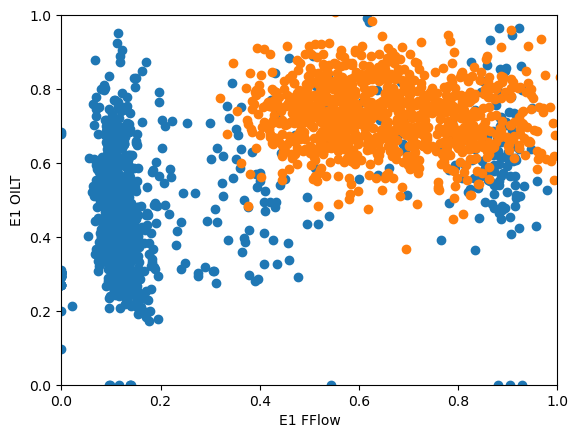

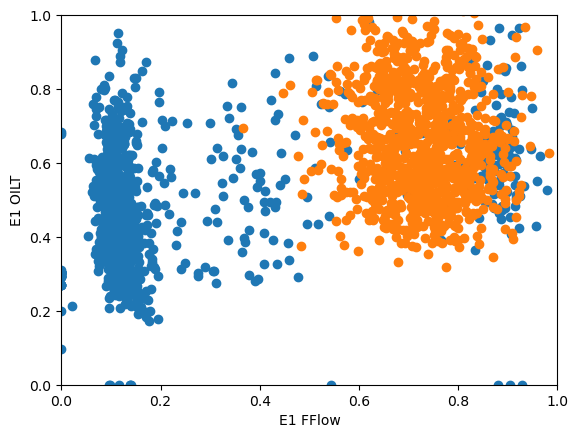

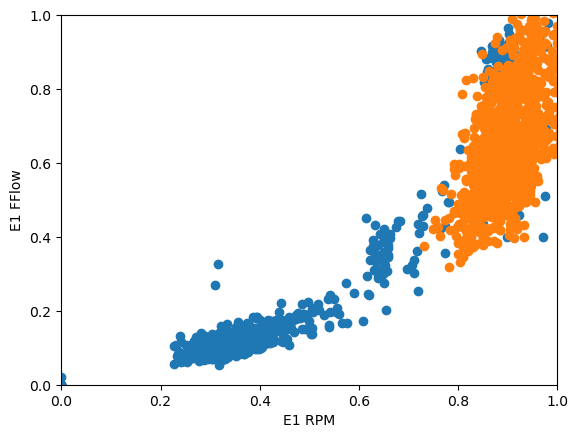

next


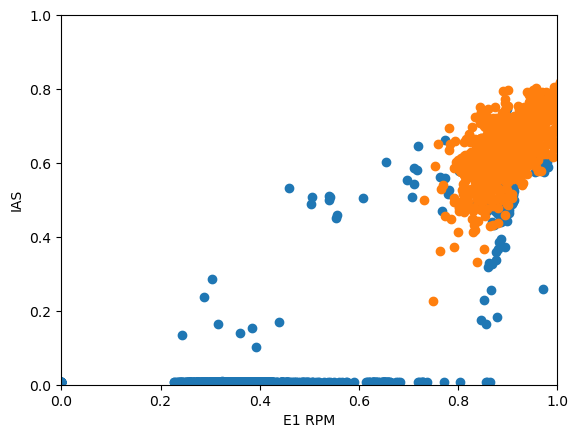

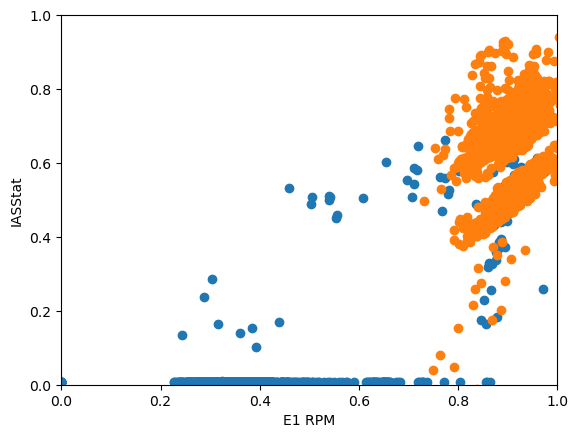

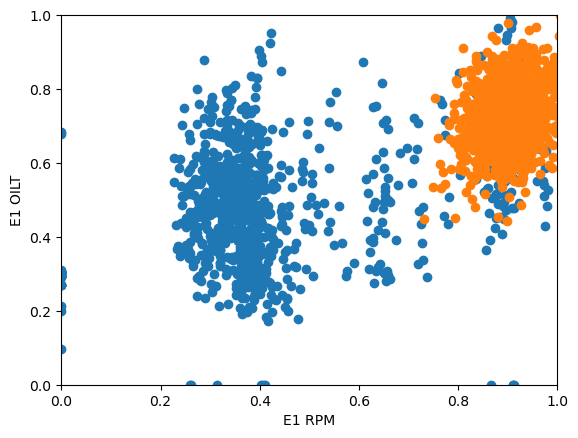

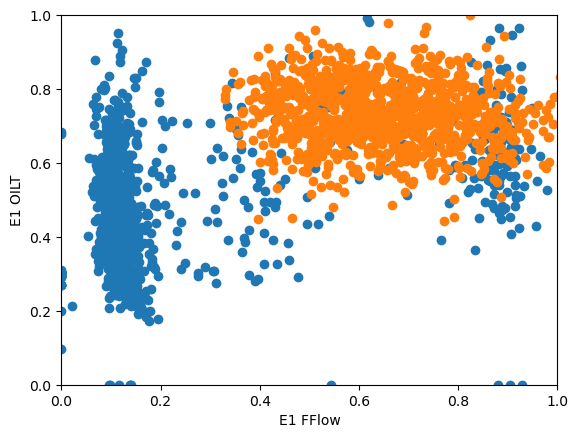

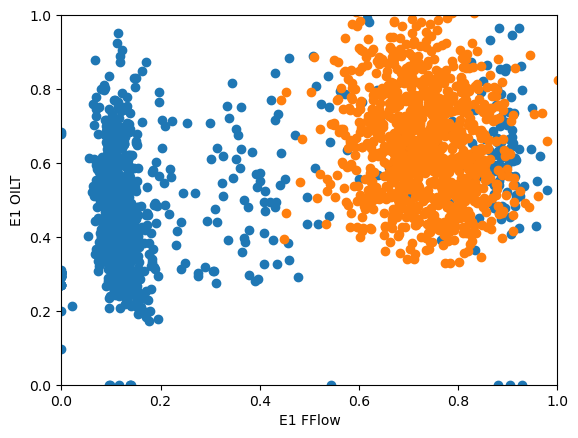

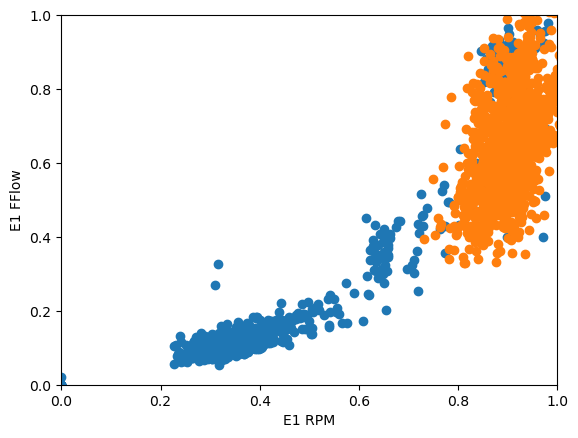

next


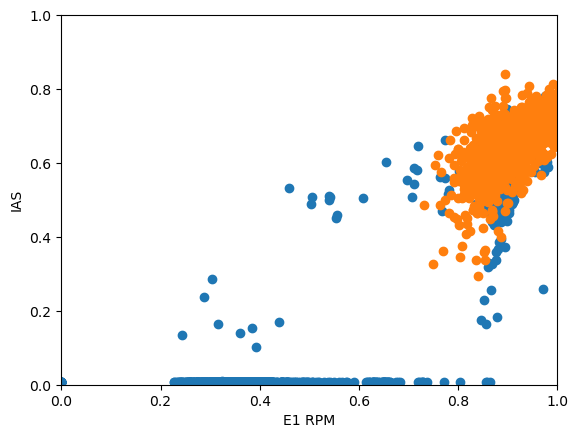

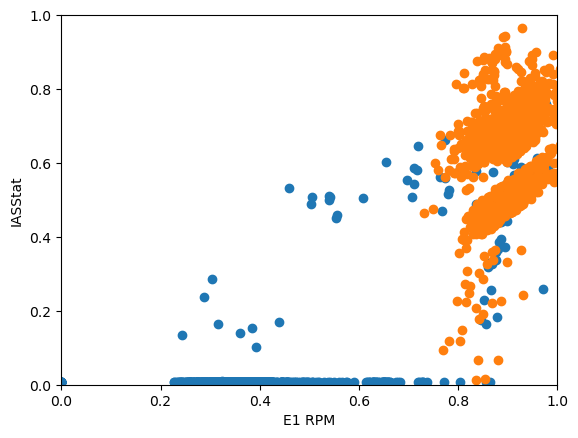

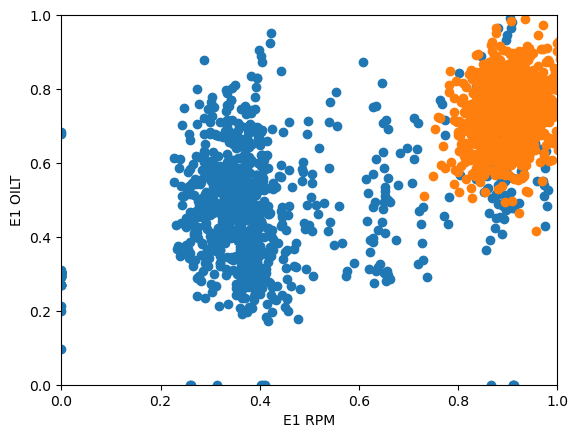

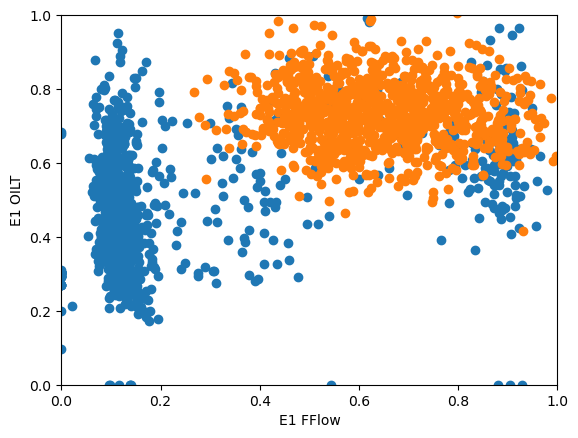

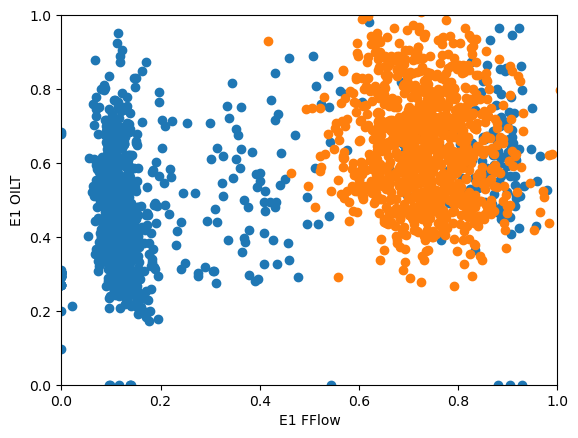

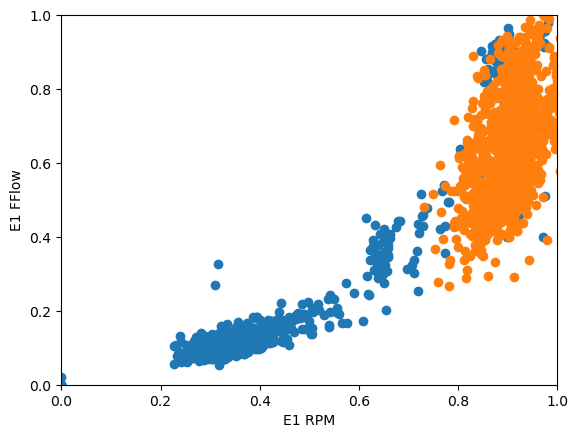

next


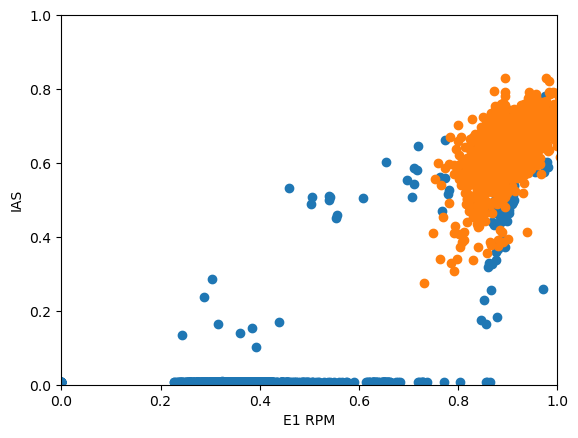

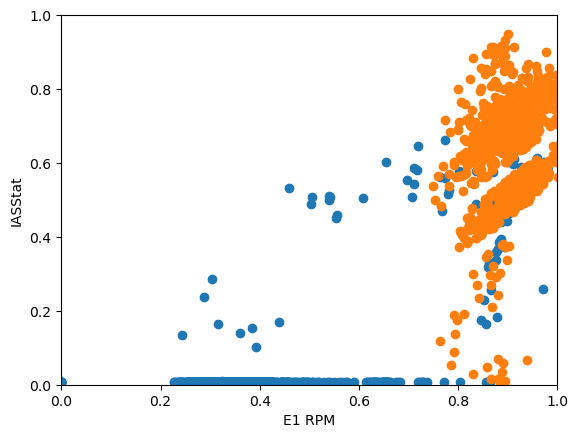

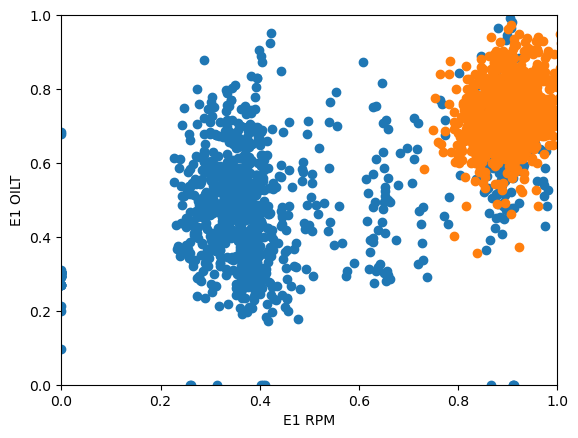

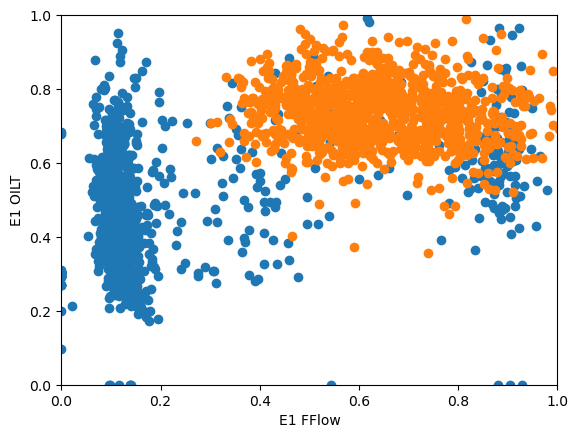

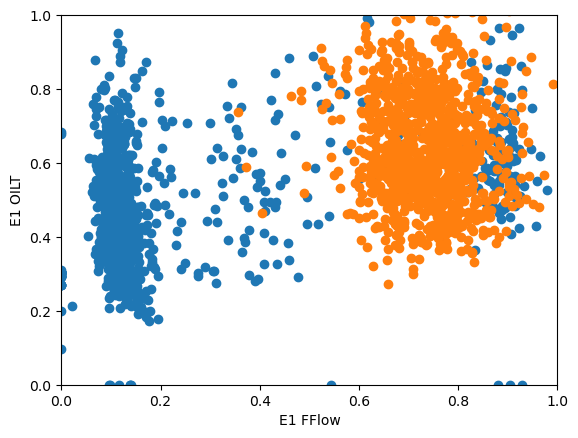

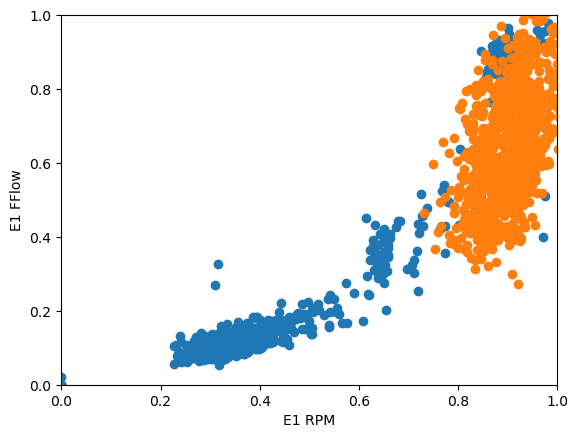

next


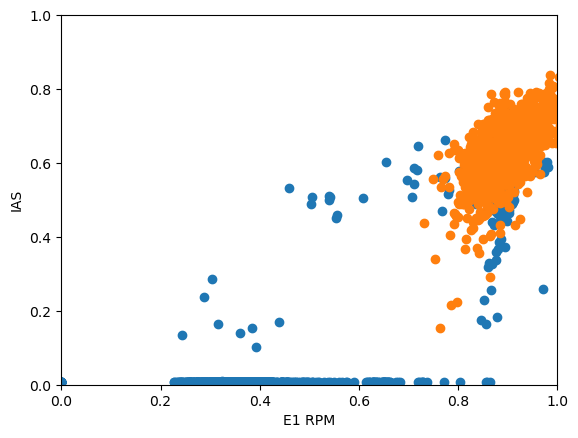

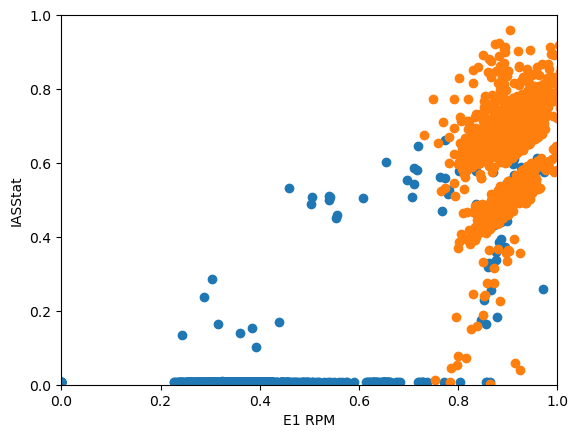

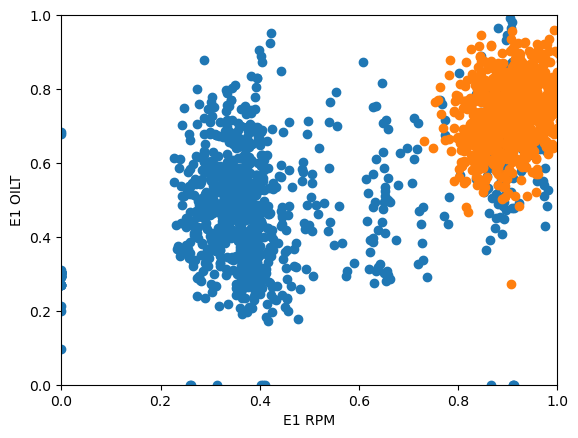

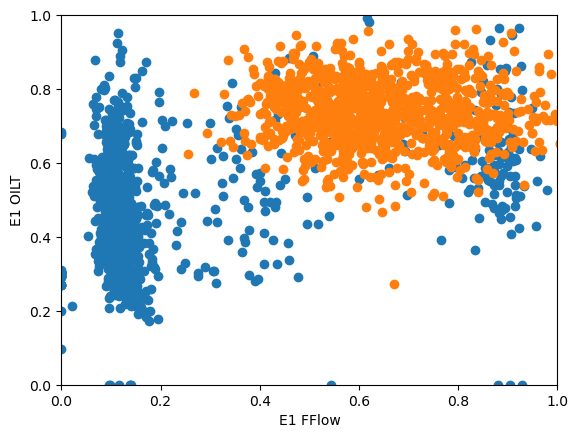

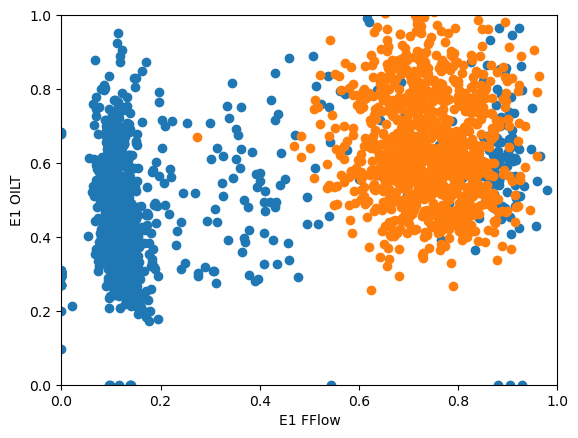

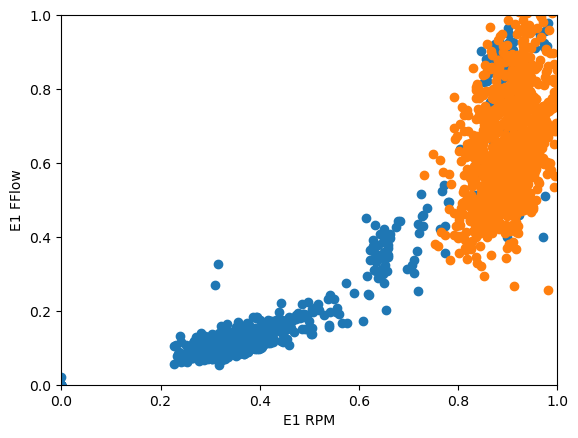

next


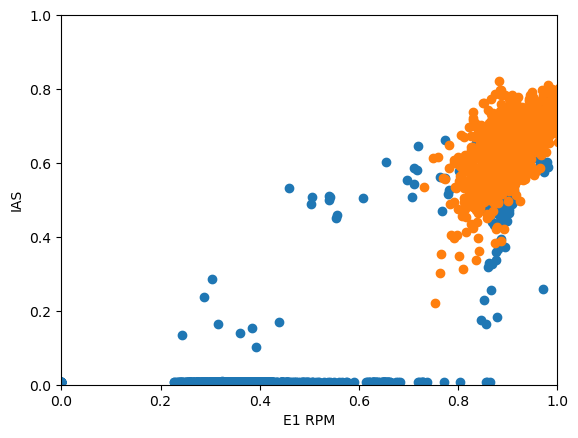

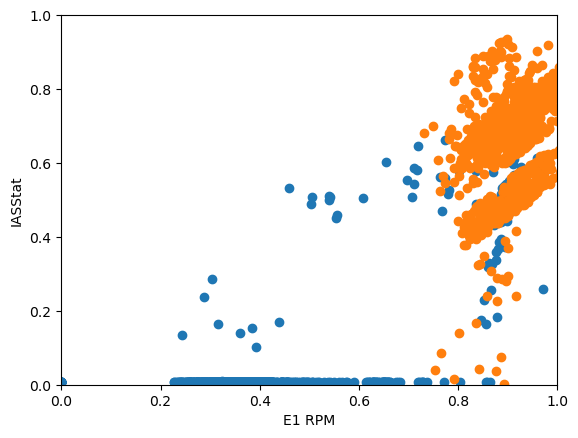

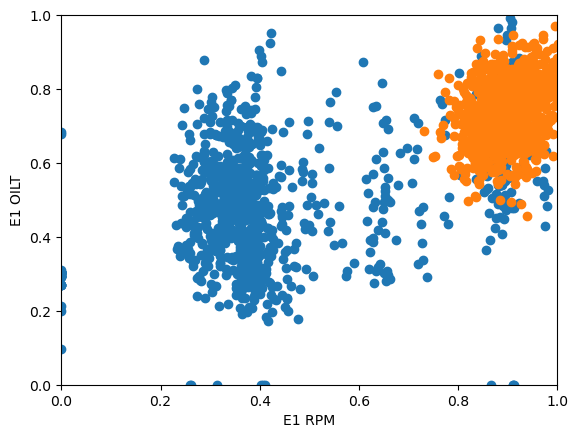

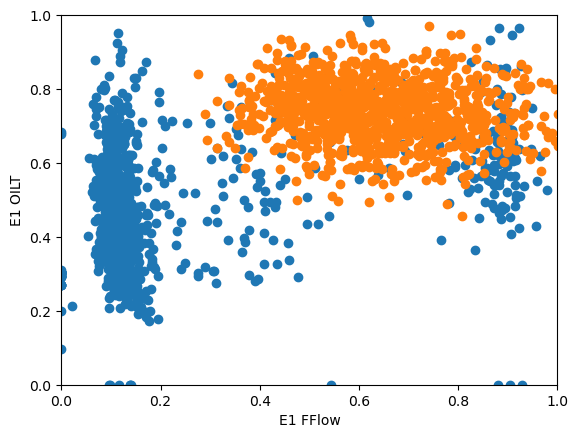

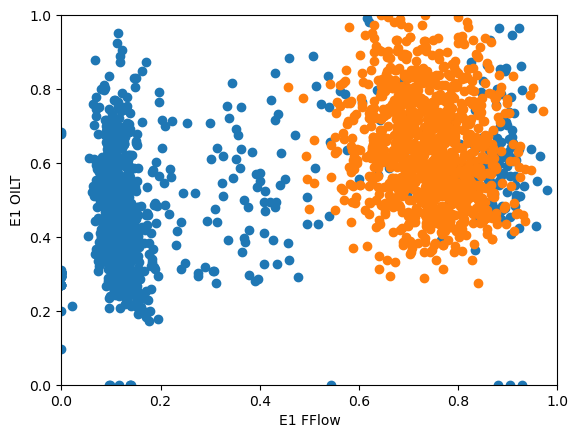

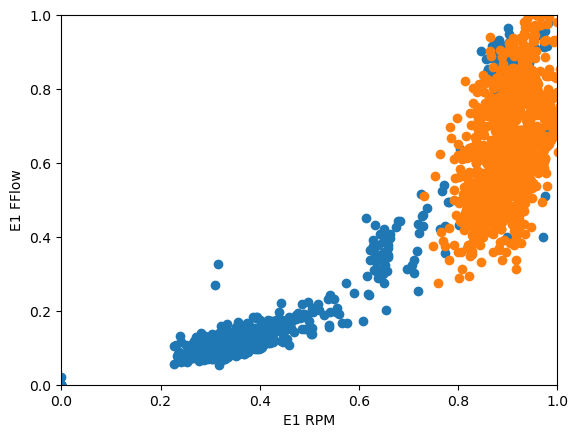

next


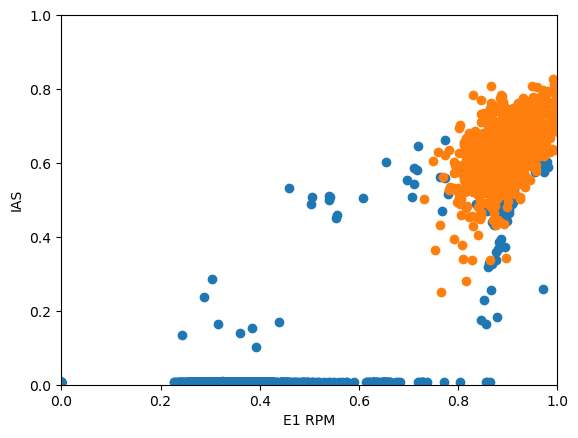

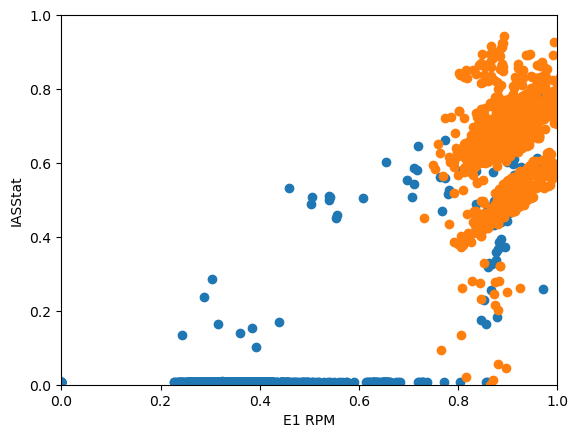

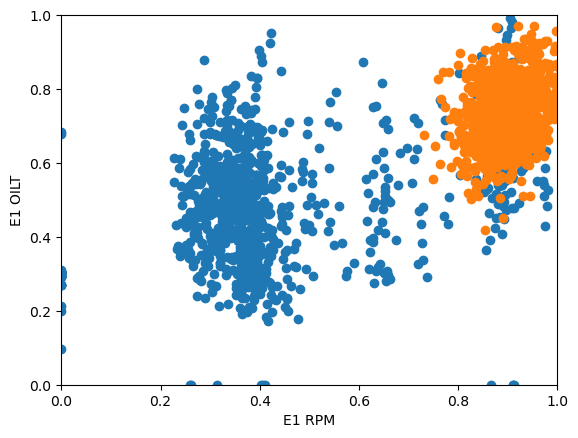

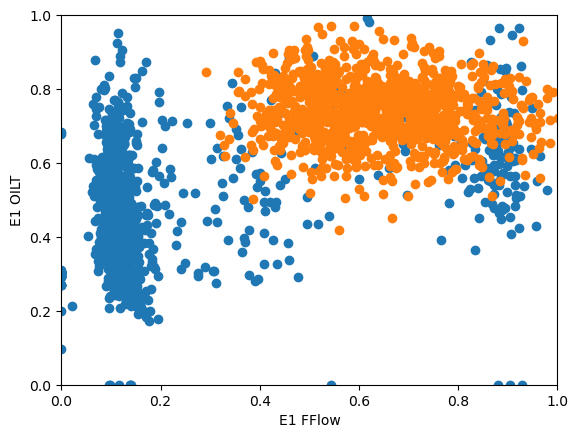

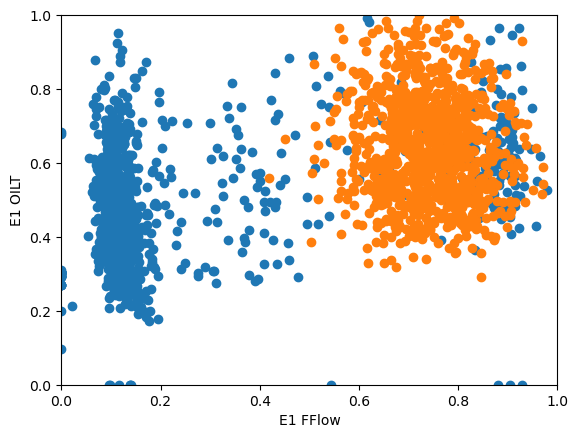

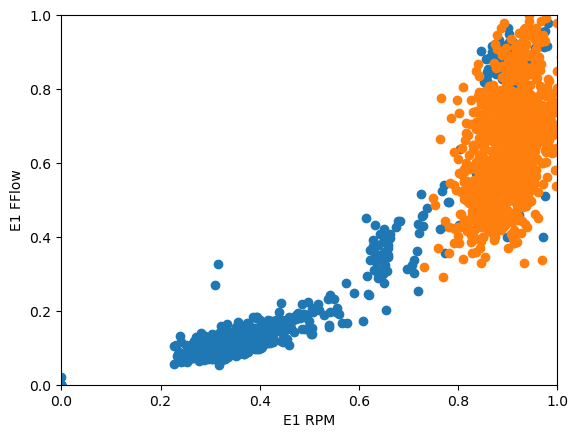

next


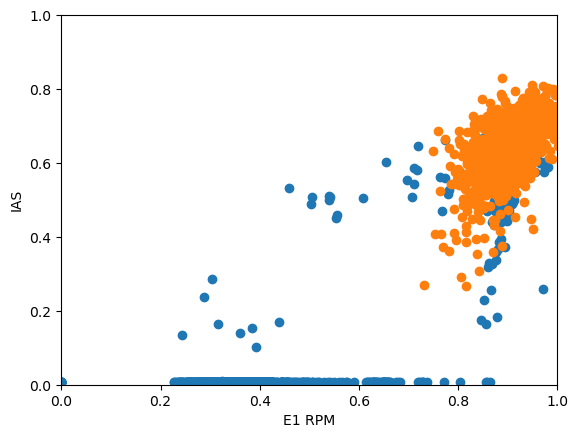

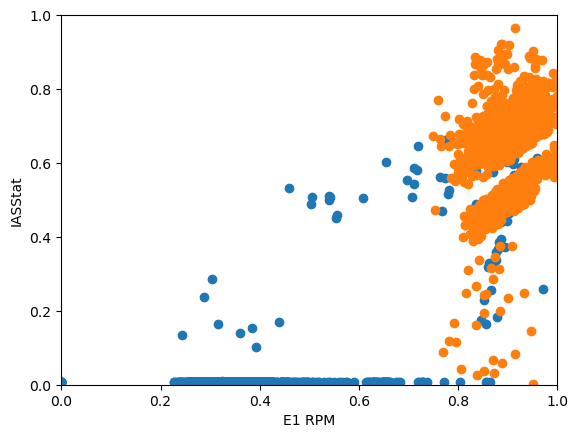

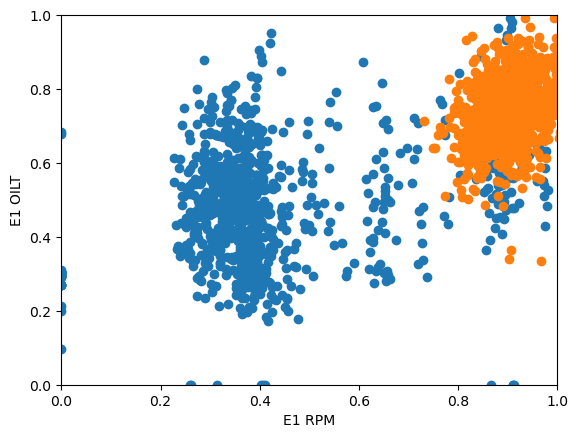

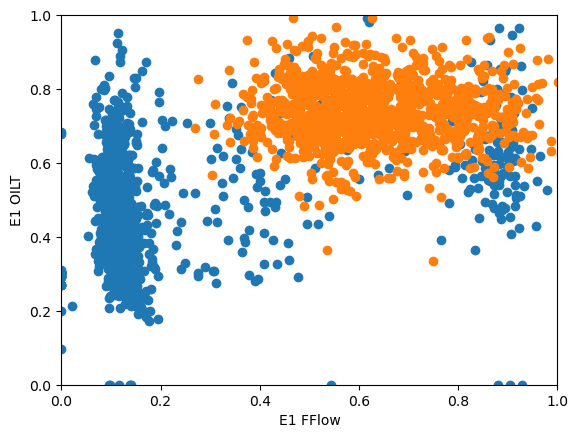

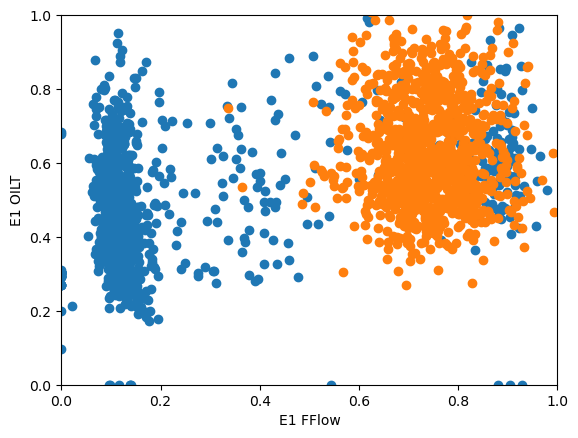

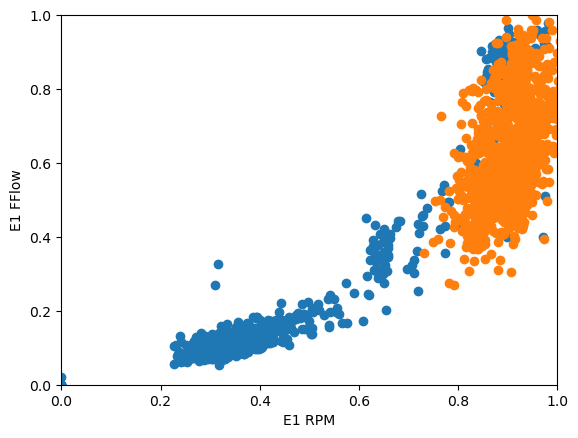

next


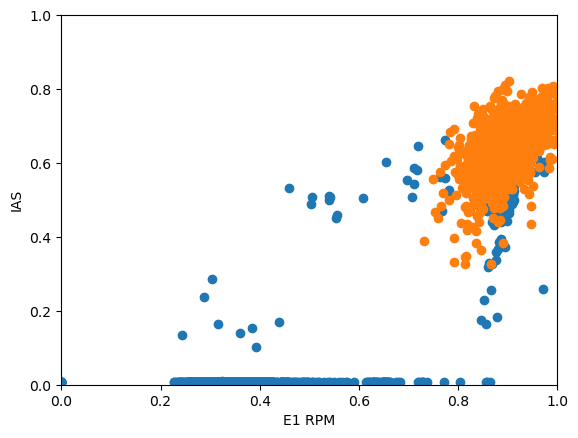

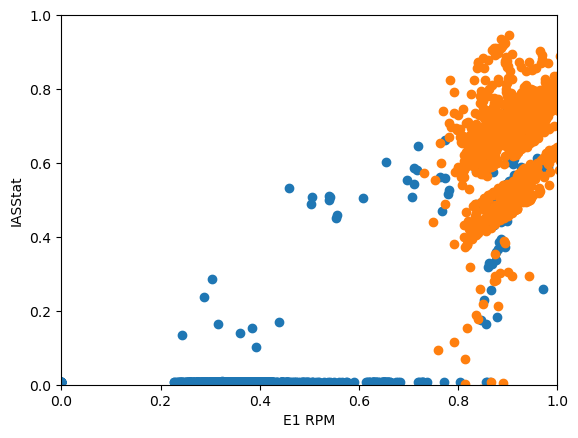

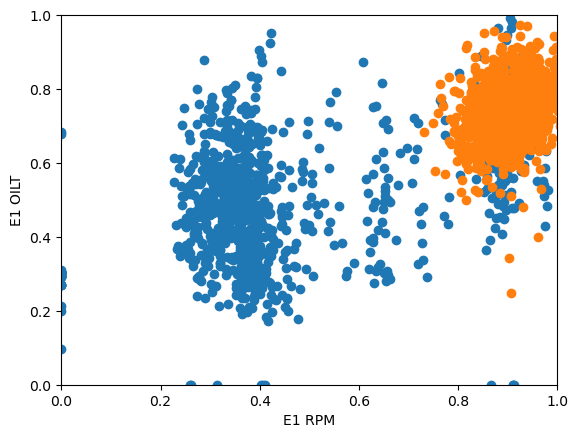

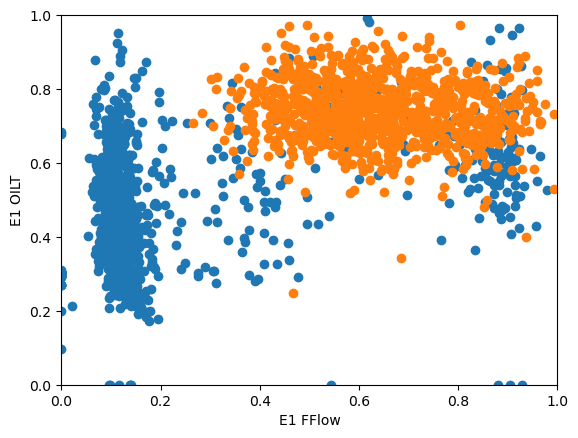

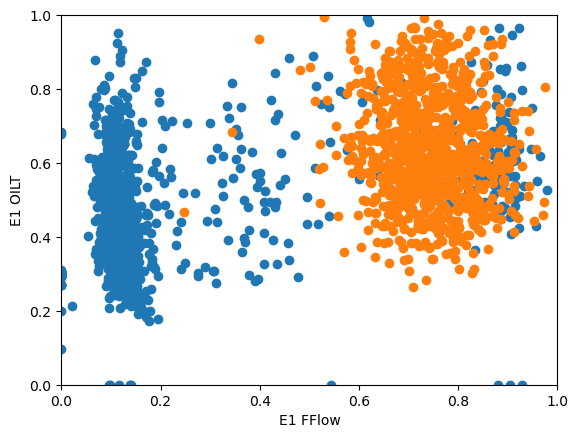

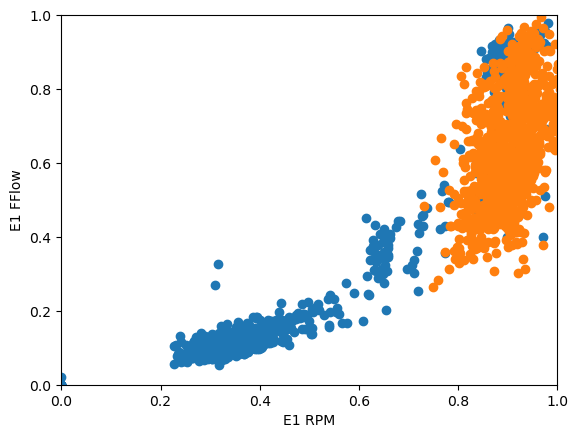

next


In [16]:
number_of_points = 1000

data_items = training_data_after[::100,:].T
red_rpm_input_data = data_items[0][:number_of_points]
red_fflow_input_data = data_items[1][:number_of_points]
red_alt_input_data = data_items[2][:number_of_points]
red_ias_input_data = data_items[3][:number_of_points]
red_oilp_input_data = data_items[4][:number_of_points]
red_oilt_input_data = data_items[5][:number_of_points]

state = [[a for a in red_rpm_input_data], [a for a in red_oilt_input_data], [a for a in red_ias_input_data], [a for a in red_alt_input_data], np.zeros(number_of_points), np.zeros(number_of_points), [a for a in red_oilt_input_data], [a for a in red_ias_input_data]]


for i in range(20):
  #data_items = normaliseAndFormatData(getFlightDataAtTimestep(flight_data_df_after, start_timesteps + 2 + i), min_vals, max_vals)
  #state[0] = data_items[0][:number_of_points,0]
  # Predict FFlow
  fflow_e = func_e_fflow(np.array([state[0], state[2]]).T)
  fflow_noise = func_fflow_noise(np.array([state[0], state[2]]).T).T

  fflow = []
  width = 1.0/output_res
  for p in range(number_of_points):
      cmf = data.build_cmf(fflow_noise.tolist()[p])
      f = data.sample_from_cmf(cmf, 1, -(total_output_size/2)*width, (total_output_size/2)*width)
      fflow += [f]

  state[4] = fflow_e[:,0] + np.array(fflow)[:,0]

  # Predict OilTStat
  oiltstat_e = func_e_oiltstat(np.array([state[0], state[4]]).T)
  oiltstat_noise = func_oiltstat_noise(np.array([red_rpm_input_data, red_fflow_input_data]).T).T

  oiltstat = []
  width = 1.0/output_res
  for p in range(number_of_points):
      cmf = data.build_cmf(oiltstat_noise.tolist()[p])
      e = data.sample_from_cmf(cmf, 1, -(total_output_size/2)*width, (total_output_size/2)*width)
      oiltstat += [e]

  state[6] = oiltstat_e[:,0] + np.array(oiltstat)[:,0]

  # Predict IASStat
  iasstat_e = func_e_iasstat(np.array([state[0]]).T)
  iasstat_noise = func_iasstat_noise(np.array([state[0]]).T).T

  iasstat = []
  width = 1.0/output_res
  for p in range(number_of_points):
      cmf = data.build_cmf(iasstat_noise.tolist()[p])
      e = data.sample_from_cmf(cmf, 1, -(total_output_size/2)*width, (total_output_size/2)*width)
      iasstat += [e]

  state[7] =  iasstat_e[:,0] + np.array(iasstat)[:,0]

  # Estimate change in IAS and OilT over time
  # Guess the values of the time scales - in reality we would run a search to approximate optimal values

  state[1] += 0.4 * (state[6] - state[1])
  state[2] += 0.4 * (state[7] - state[2])

  # intervention
  if i == 3:
      state[0] = np.random.normal(loc=0.9, scale=0.05, size=number_of_points)

  # plot RPM vs IAS
  fig = plt.figure()
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])
  plt.xlabel("E1 RPM")
  plt.ylabel("IAS")
  plt.scatter(red_rpm_input_data, red_ias_input_data)

  plt.scatter(state[0], state[2])
  plt.show()

  # plot RPM vs IAS
  fig = plt.figure()
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])
  plt.xlabel("E1 RPM")
  plt.ylabel("IASStat")
  plt.scatter(red_rpm_input_data, red_ias_input_data)

  plt.scatter(state[0], state[7])
  plt.show()

  # plot RPM vs EGT
  fig = plt.figure()
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])
  plt.xlabel("E1 RPM")
  plt.ylabel("E1 OILT")
  plt.scatter(red_rpm_input_data, red_oilt_input_data)

  plt.scatter(state[0], state[1])
  plt.show()

  # plot RPM vs FFlow
  fig = plt.figure()
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])
  plt.xlabel("E1 FFlow")
  plt.ylabel("E1 OILT")
  plt.scatter(red_fflow_input_data, red_oilt_input_data)

  plt.scatter(state[4], state[1])
  plt.show()

  # plot RPM vs FFlow
  fig = plt.figure()
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])
  plt.xlabel("E1 FFlow")
  plt.ylabel("E1 OILT")
  plt.scatter(red_fflow_input_data, red_oilt_input_data)

  plt.scatter(state[1], state[4])
  plt.show()

  # plot RPM vs FFlow
  fig = plt.figure()
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])
  plt.xlabel("E1 RPM")
  plt.ylabel("E1 FFlow")
  plt.scatter(red_rpm_input_data, red_fflow_input_data)

  plt.scatter(state[0], state[4])
  plt.show()

  print("next")

